<a href="https://colab.research.google.com/github/nprzrosas/atp_induced_calcium_oscillations_wang_2007/blob/main/Finalized_Integrate_Ca_singleCell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook analyze the calcium activity for a single cell using the model publised in the paper "From spikes to intercellular waves: Tuning intercellular calcium signaling dynamics modulates organ size control" PLoS Comput Biol. 2021 Nov; 17(11): e1009543.

**Notebook Authors**:
Emmanuel Gichaba,
Norma Perez &
Adrian Buganza

In [ ]:
from IPython import get_ipython;
get_ipython().magic('reset -sf') # Clear the variables present on the namespace

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
import os

from IPython.display import display, HTML



import sys
import numpy

from collections import Counter

#Varying VPLC#
The next blocks of code will vary VPLC values  

#VPLC = 0.75

 These are the 4 ODES for calcium in the cytoplasm, IP3R, IP3, and Calcium in the ER. These stay the same for all simulations

In [ ]:

## This is the equation for the rate of change of Calcium in the cytoplasm
#This is one of the equations in which VPLC varies
# Eq. 6 in Politi et al. (2006)
def Ca_cyt_dot(Ca_cyt, IP3, IP3R,C_ER):
  # Inputs
  # Ca_cyt: calcium concentration in cytoplasm
  # IP3: IP3 concentration in cytoplasm
  # IP3R: how much of IP3 receptor is free to bind to IP3
  # C_ER: calcium concentration in Endoplasmic Reticulum
  # Output
  # dCa_cyt/dt

  #Parameter Values (From Table 1)
  k1 = 1.11
  k2 = 0.0203
  Ka = 0.08
  Kp = 0.13
  k3= 0.4
  k3z = 0.0
  k5 = 0.66
  Kserca = 0.1
  Vserca = 0.9
  # no need to solve Calcium in reticulum with an ODE because total Calcium is constant so
  #Ctot = 2.0
  #beta = 0.185
  #Ca_R = (Ctot-Ca_cyt)/beta we don't need this anymore since we have the actual calcium in reticulum ode
  eps = 0.0
  v0 = 0.0008
  vpm = 0.0
  kpm = 0.01
  phi = 0.0

  # This is the parameter that is being changed throughout the notebook, not a single value in the paper
  vplc = 0.75 # Paramter

  return (k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt) - Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)+eps*(v0+(phi*vplc)/((k3z+k5))-(vpm*Ca_cyt**2/(kpm**2+Ca_cyt**2))) #added in the calcium in the reticulum


## This is the equation for the rate of change of the fraction of IP3 receptors that are not inactivated by calcium
# Eq. 7 in Soundarrajan et al. (2021)
def IP3R_dot(Ca_cyt, IP3, IP3R):
  # Inputs
  # Ca_cyt: calcium concentration in cytoplasm
  # IP3: IP3 concentration in cytoplasm
  # IP3R: how much of IP3 receptor is free to bind to IP3
  # Output
  # dIP3R/dt

  #Parameter Values(From Table 1)
  tau_max = 1000
  k_tau = 1
  tau_new_update = tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4) #Is based off Calcium in cytoplasm value
  ki = 0.4
  #This function finds the IP3R using varying cytoplasmic calcium values
  return (1.0/tau_new_update)*(1-IP3R*(ki+Ca_cyt)/ki)


## This is the equation for the rate of change of IP3 in the cytoplasm
#This is one of the equations in which VPLC varies
# Eq. 1,2,3 in Politi et al. (2006)
def IP3_dot(Ca_cyt, IP3, IP3R):
  # Inputs
  # Ca_cyt: calcium concentration in cytoplasm
  # IP3: IP3 concentration in cytoplasm
  # IP3R: how much of IP3 receptor is free to bind to IP3
  # Output
  # dIP3/dt

  #Parameter Values (From Table 1)
  k5 = 0.66
  k3 = 0.4
  k3z= 0.0
  VPLC = 0.75 # This is the parameter that is being changed throughout the notebook, not a single value in the paper
  K_PLC = 0.2
  tau_p = 1
  vplc = (VPLC*Ca_cyt**2/(K_PLC**2+Ca_cyt**2))
  vdeg = (k5+(k3z*Ca_cyt**2/(k3**2+Ca_cyt**2)))*IP3
  return tau_p * (vplc - vdeg)

## This is the equation for the rate of change of Caclium in the ER
# Eq. 7 in Politi et al. (2006)
def C_ER_dot(Ca_cyt, IP3, IP3R, C_ER):
  # Inputs
  # Ca_cyt: calcium concentration in cytoplasm
  # IP3: IP3 concentration in cytoplasm
  # IP3R: how much of IP3 receptor is free to bind to IP3
  # C_ER: calcium concentration in Endoplasmic Reticulum
  # Output
  # dC_ER/dt

  #Parameter Values (From Table 1)
  beta = 0.185
  Kserca = 0.1
  Vserca = 0.9
  k1 = 1.11
  Ka = 0.08
  Kp = 0.13
  k2 = 0.0203
  Ctot = 2.0
  Ca_R = (Ctot-Ca_cyt)/beta
  return (1.0/beta)*((((Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)))-(k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt)))

Forward Eulers method to integrate the ODE in time

In [ ]:
dt = 0.01 #s
t_final = 3600 # s
n_steps = int(t_final/dt)
# create arrays to store solution
Ca_cyt_vec = np.zeros((n_steps))
IP3_vec = np.zeros((n_steps))
C_ER_vec = np.zeros((n_steps))
IP3R_vec = np.zeros((n_steps))
time_vec = np.zeros((n_steps))
# Initial conditions
Ca_cyt_vec[0] = .05
IP3_vec[0] = 1
C_ER_vec[0] = (2.0 - .05)/0.185
IP3R_vec[0] = 0.5
# forward Euler loop
for i in range(n_steps-1):
  Ca_cyt_vec[i+1] = Ca_cyt_vec[i]+dt*Ca_cyt_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3_vec[i+1] = IP3_vec[i]+dt*IP3_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  C_ER_vec[i+1] = C_ER_vec[i]+dt*C_ER_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3R_vec[i+1] = IP3R_vec[i]+dt*IP3R_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  time_vec[i+1] = time_vec[i]+dt #This is a time list to keep track when graphing

Plots with VPLC value of 0.75

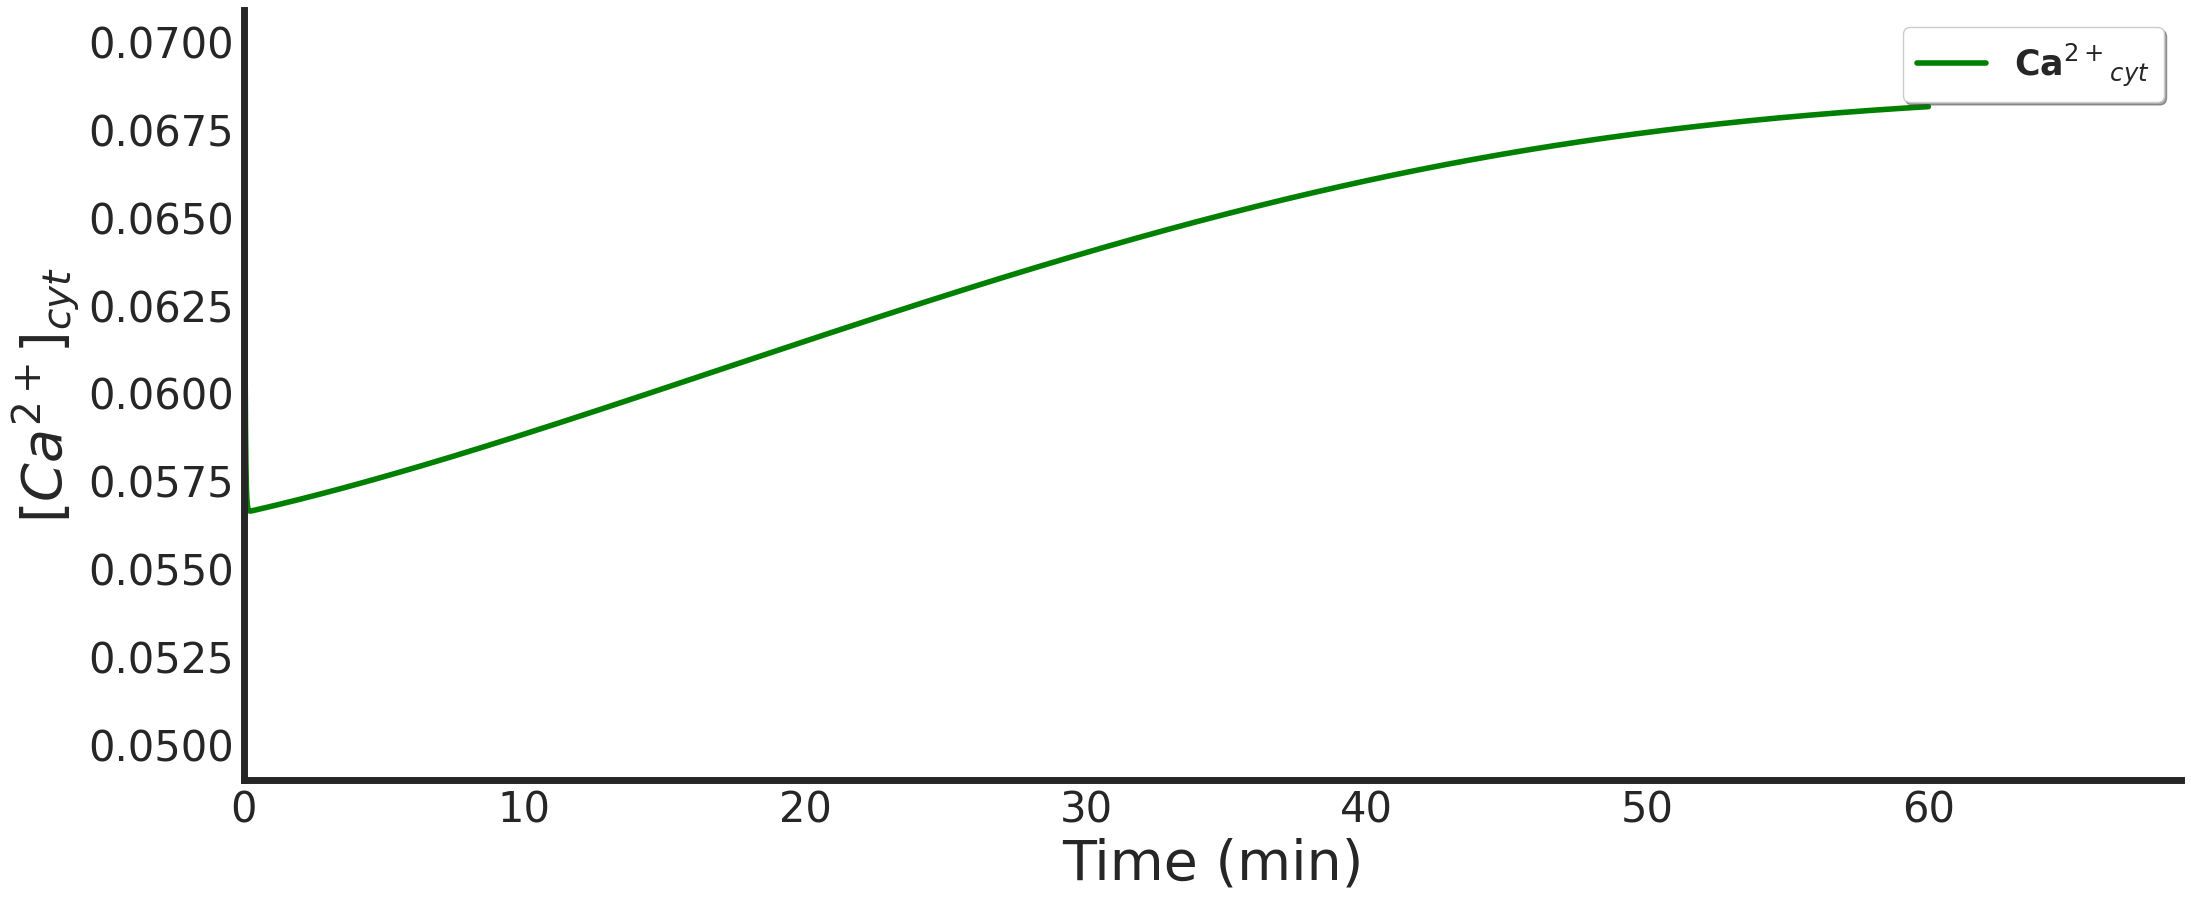

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[$Ca^{2+}$]$_{cyt}$',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

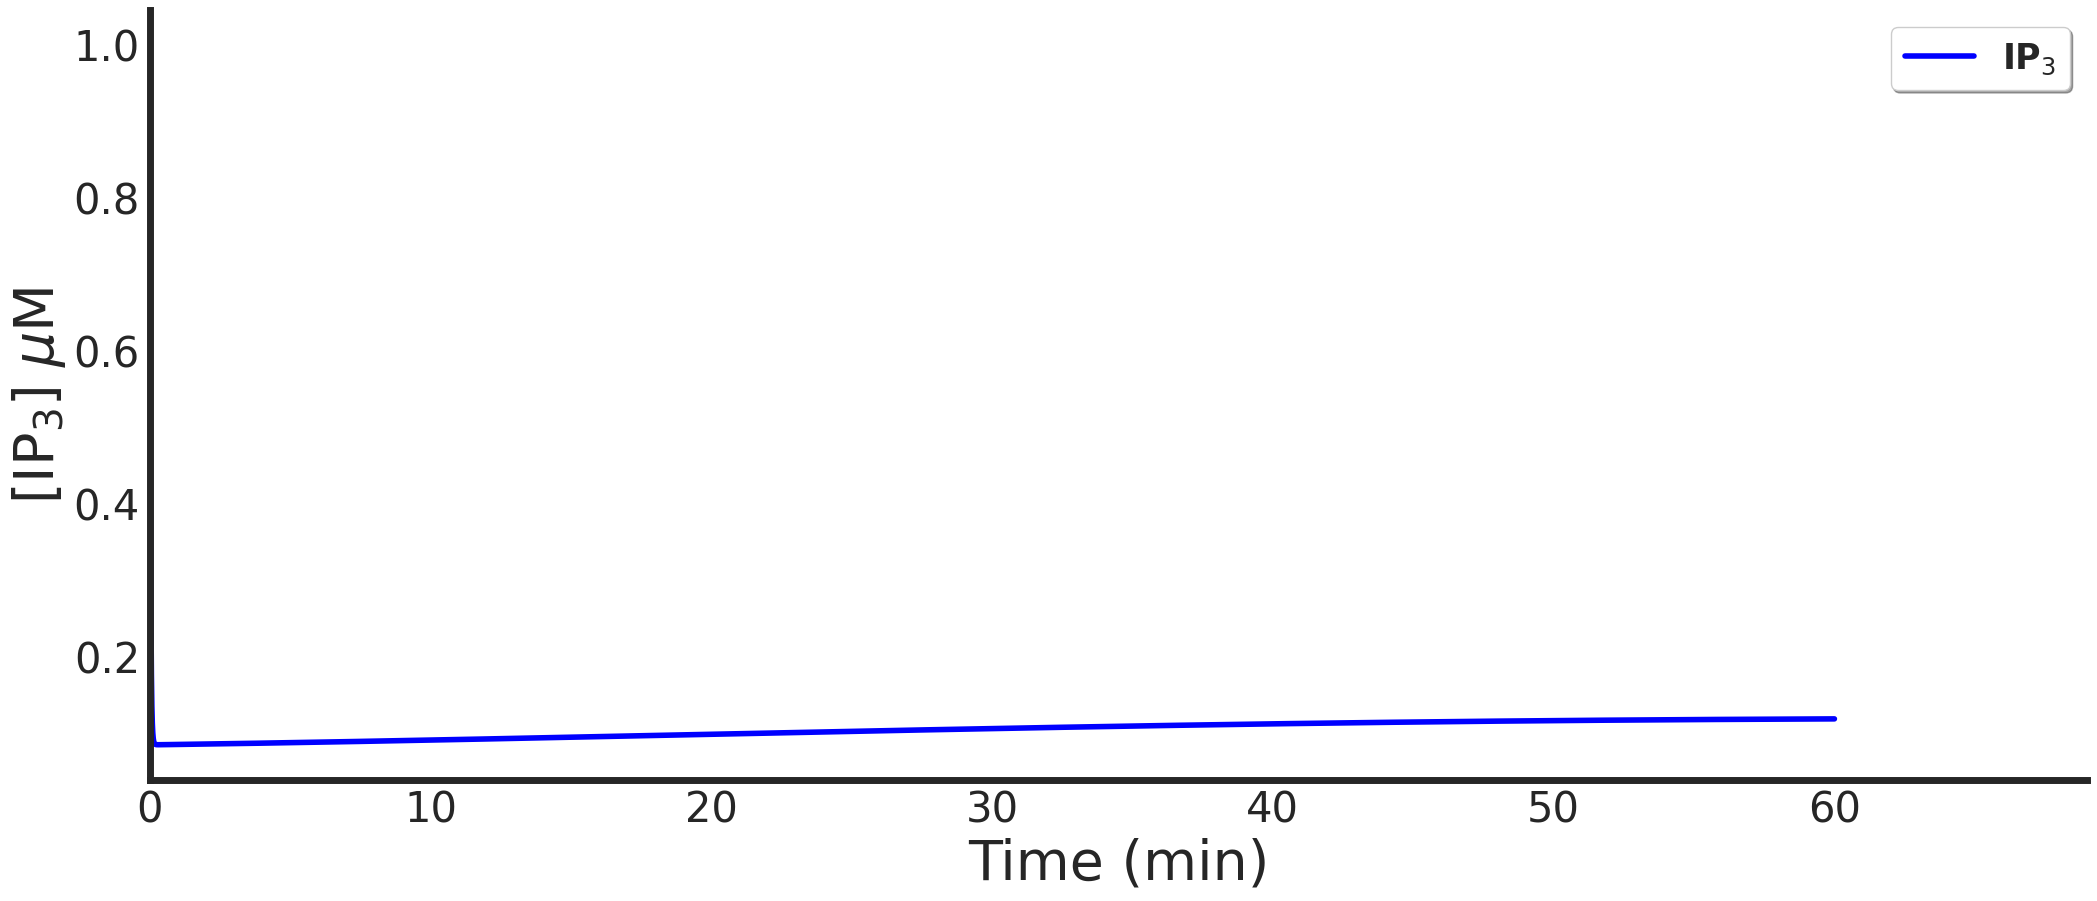

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

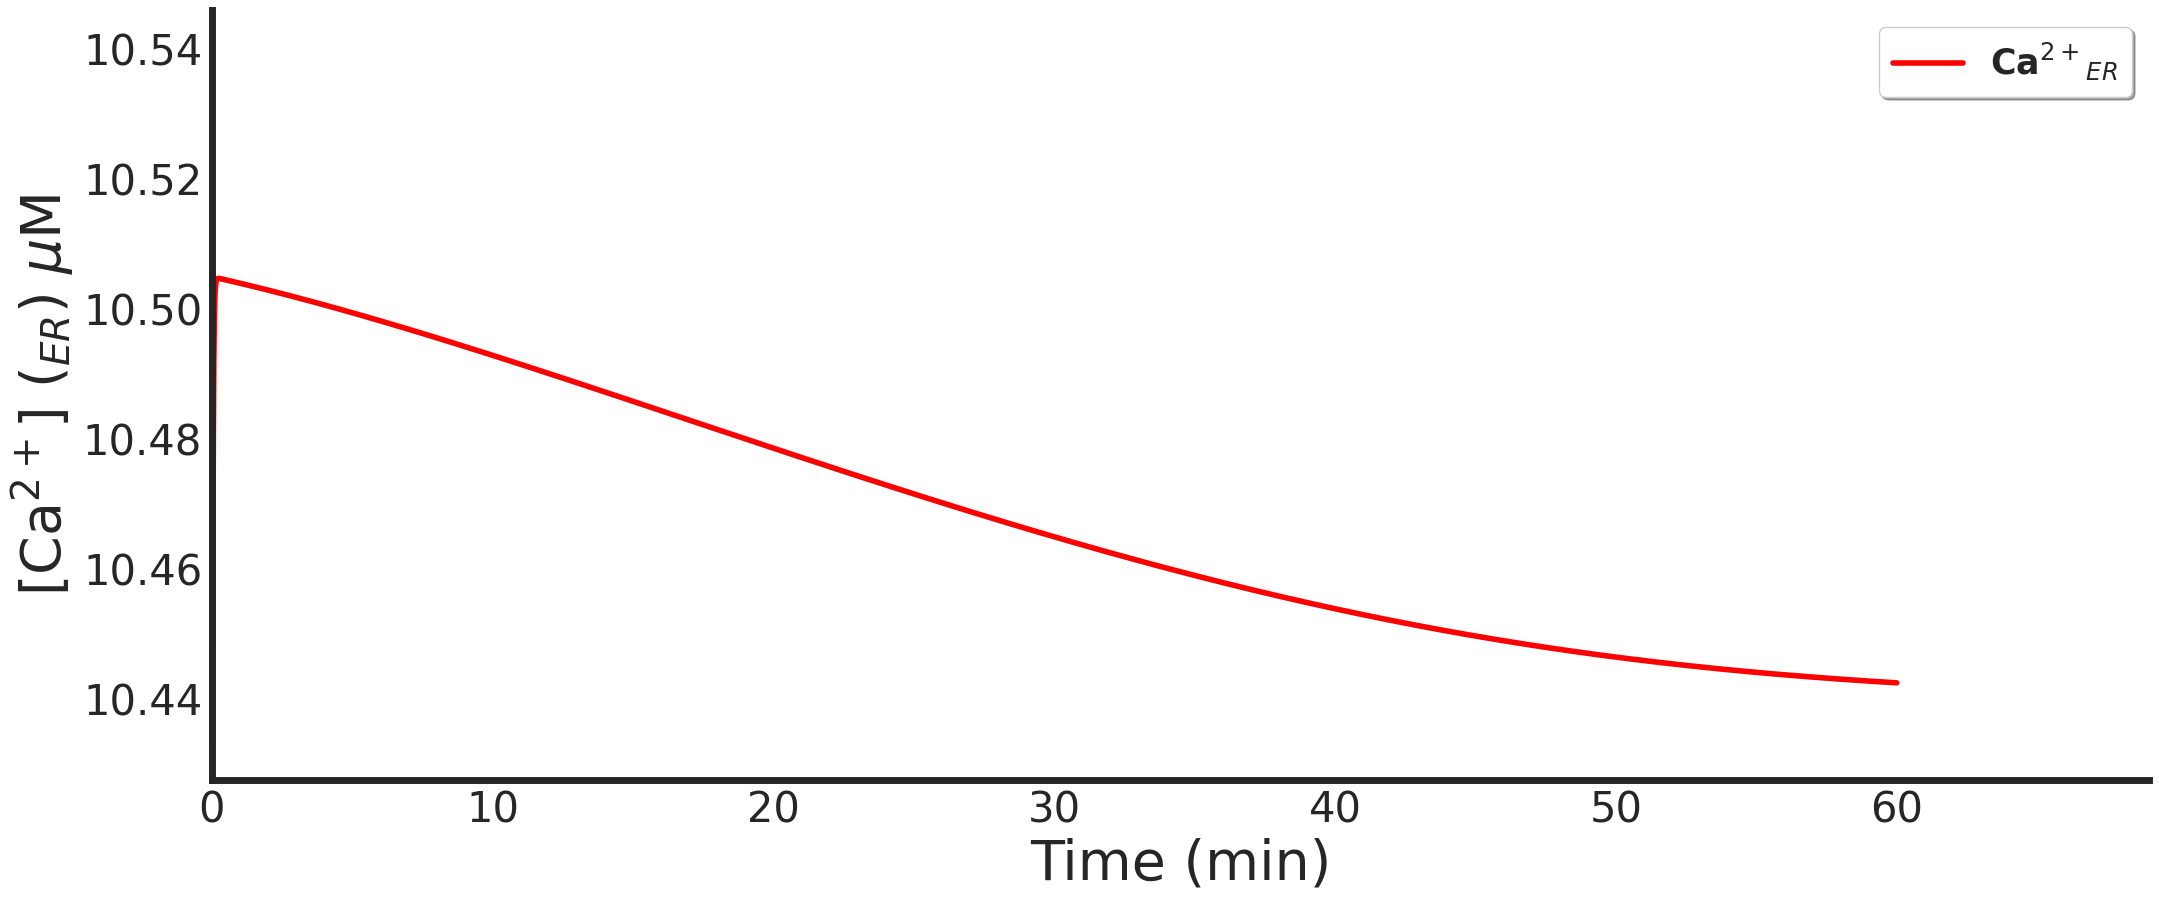

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$] ($_{ER}$) $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

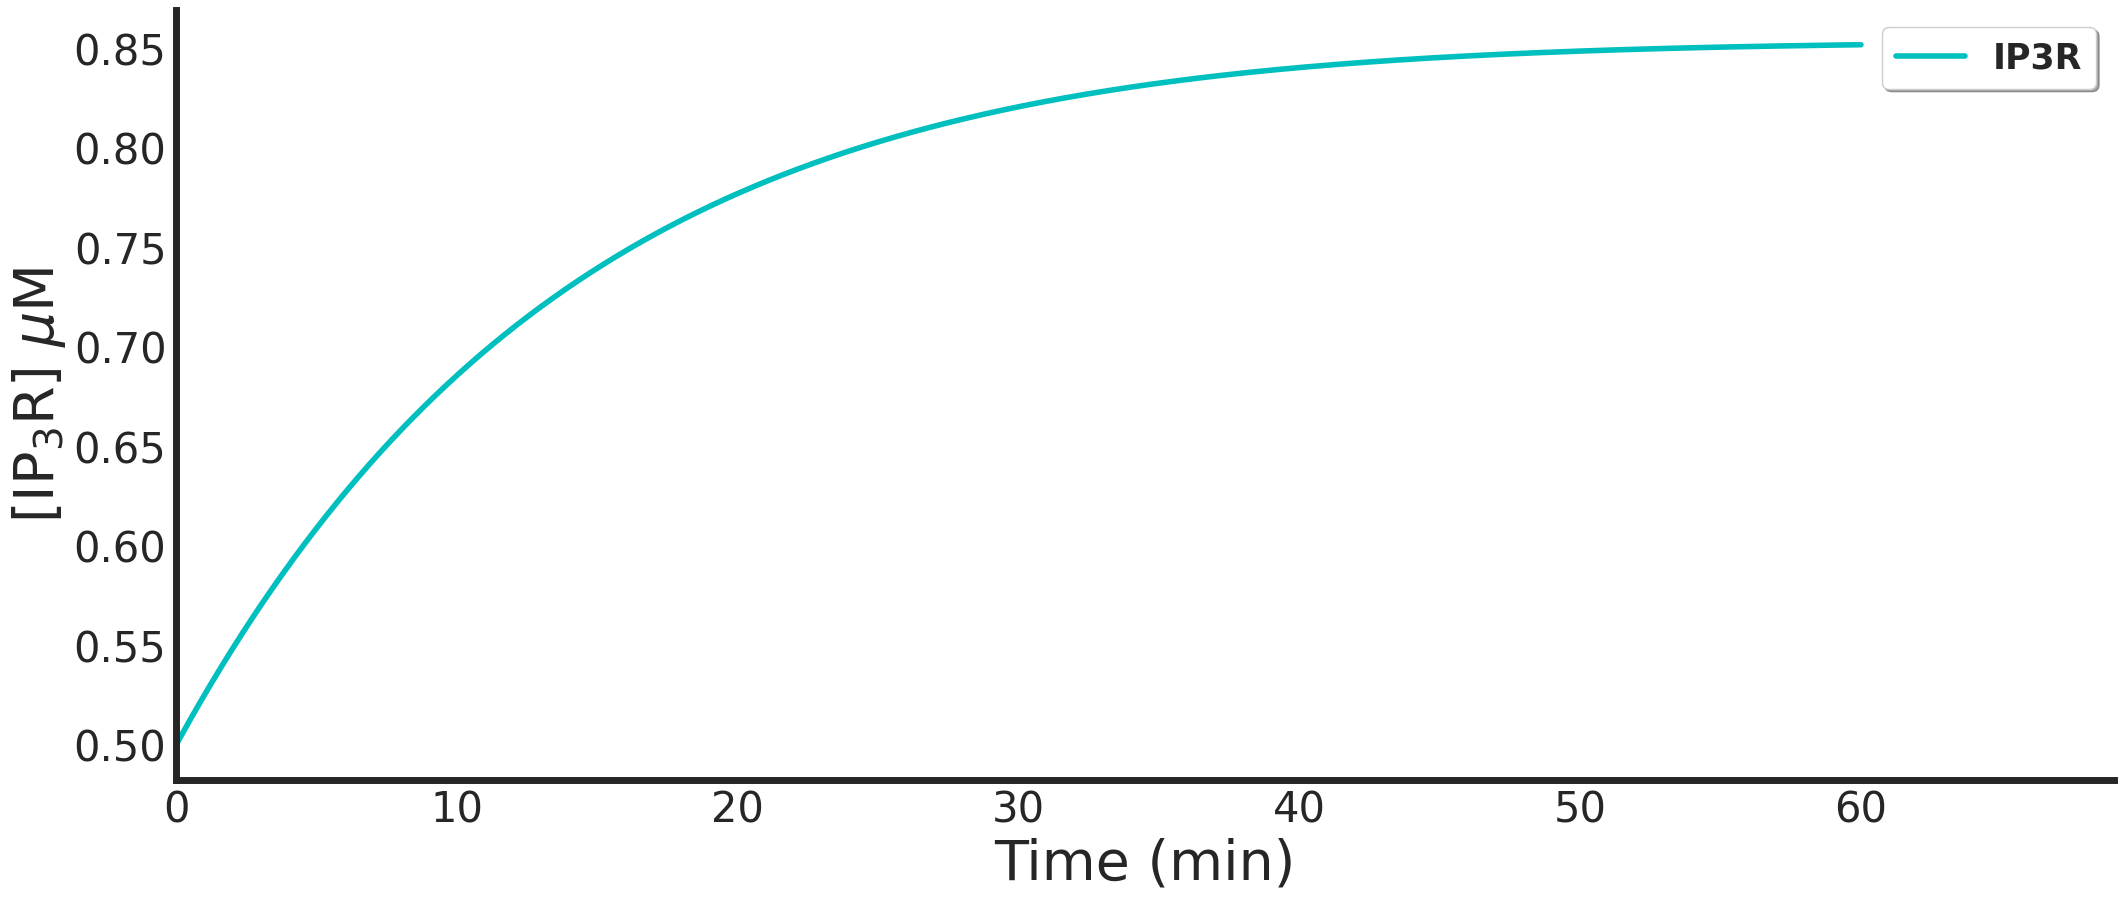

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$R] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

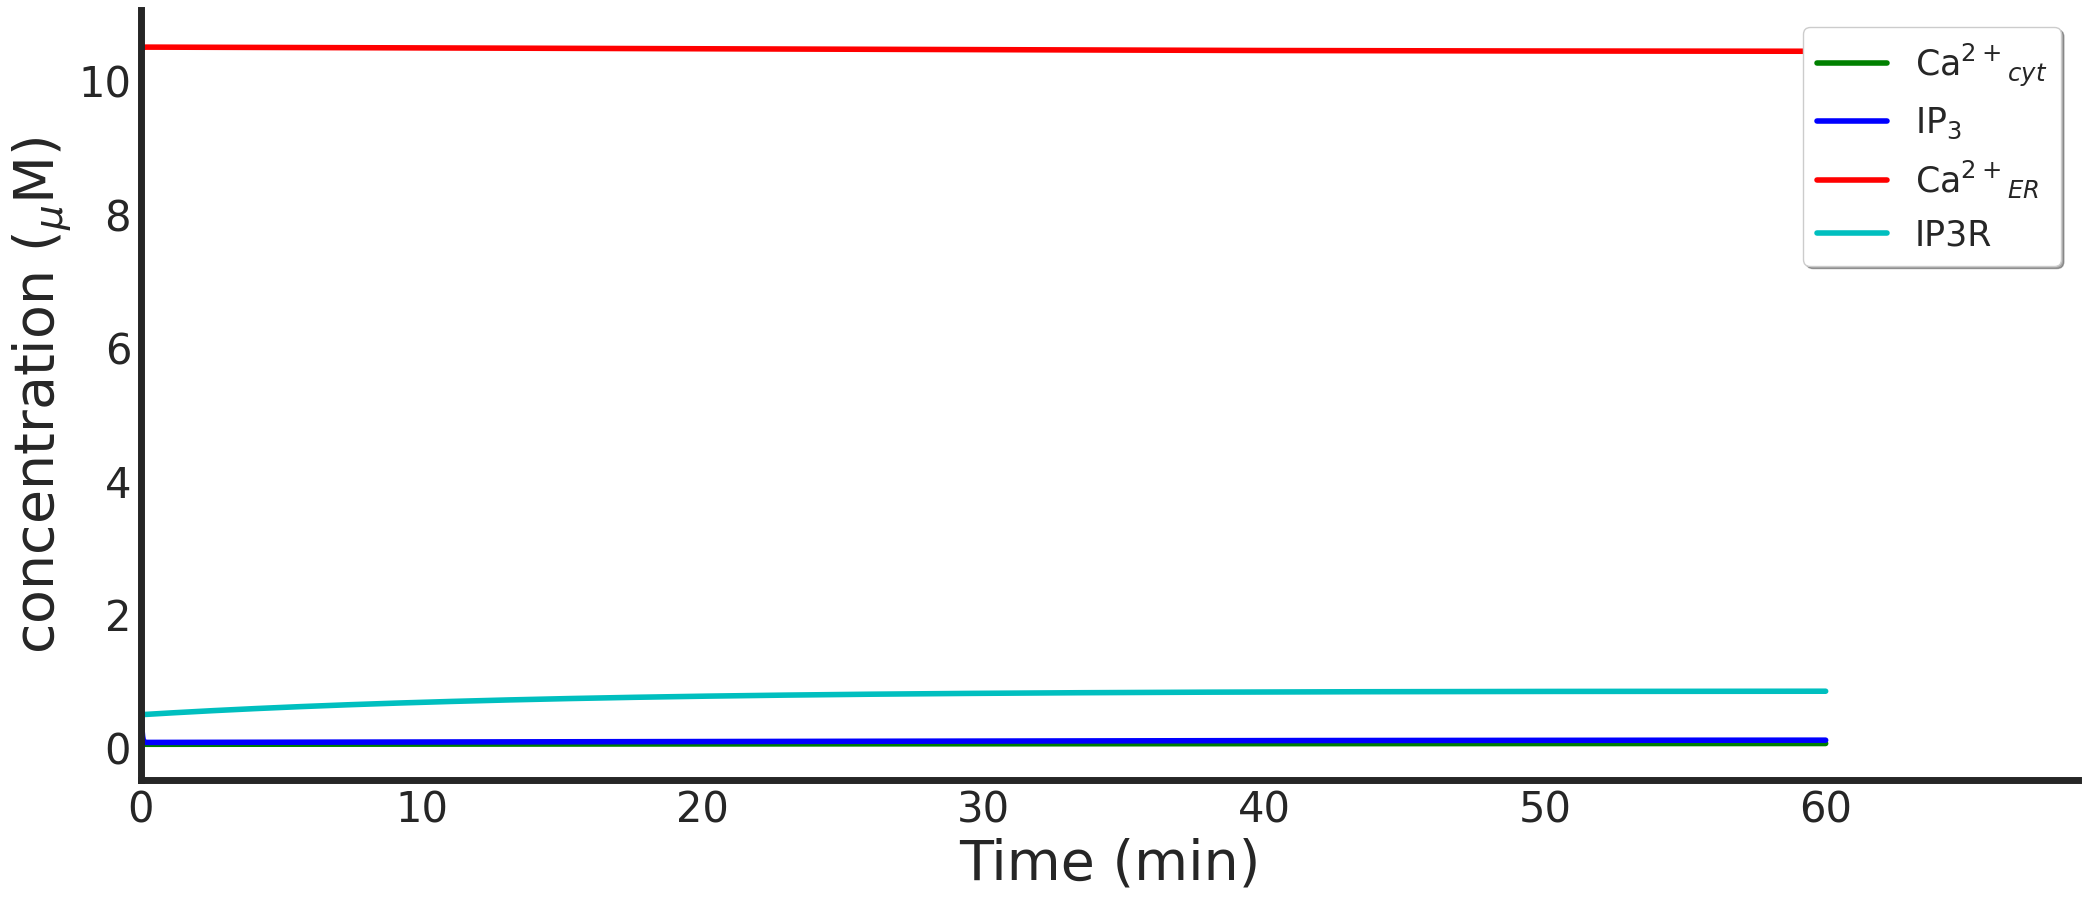

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

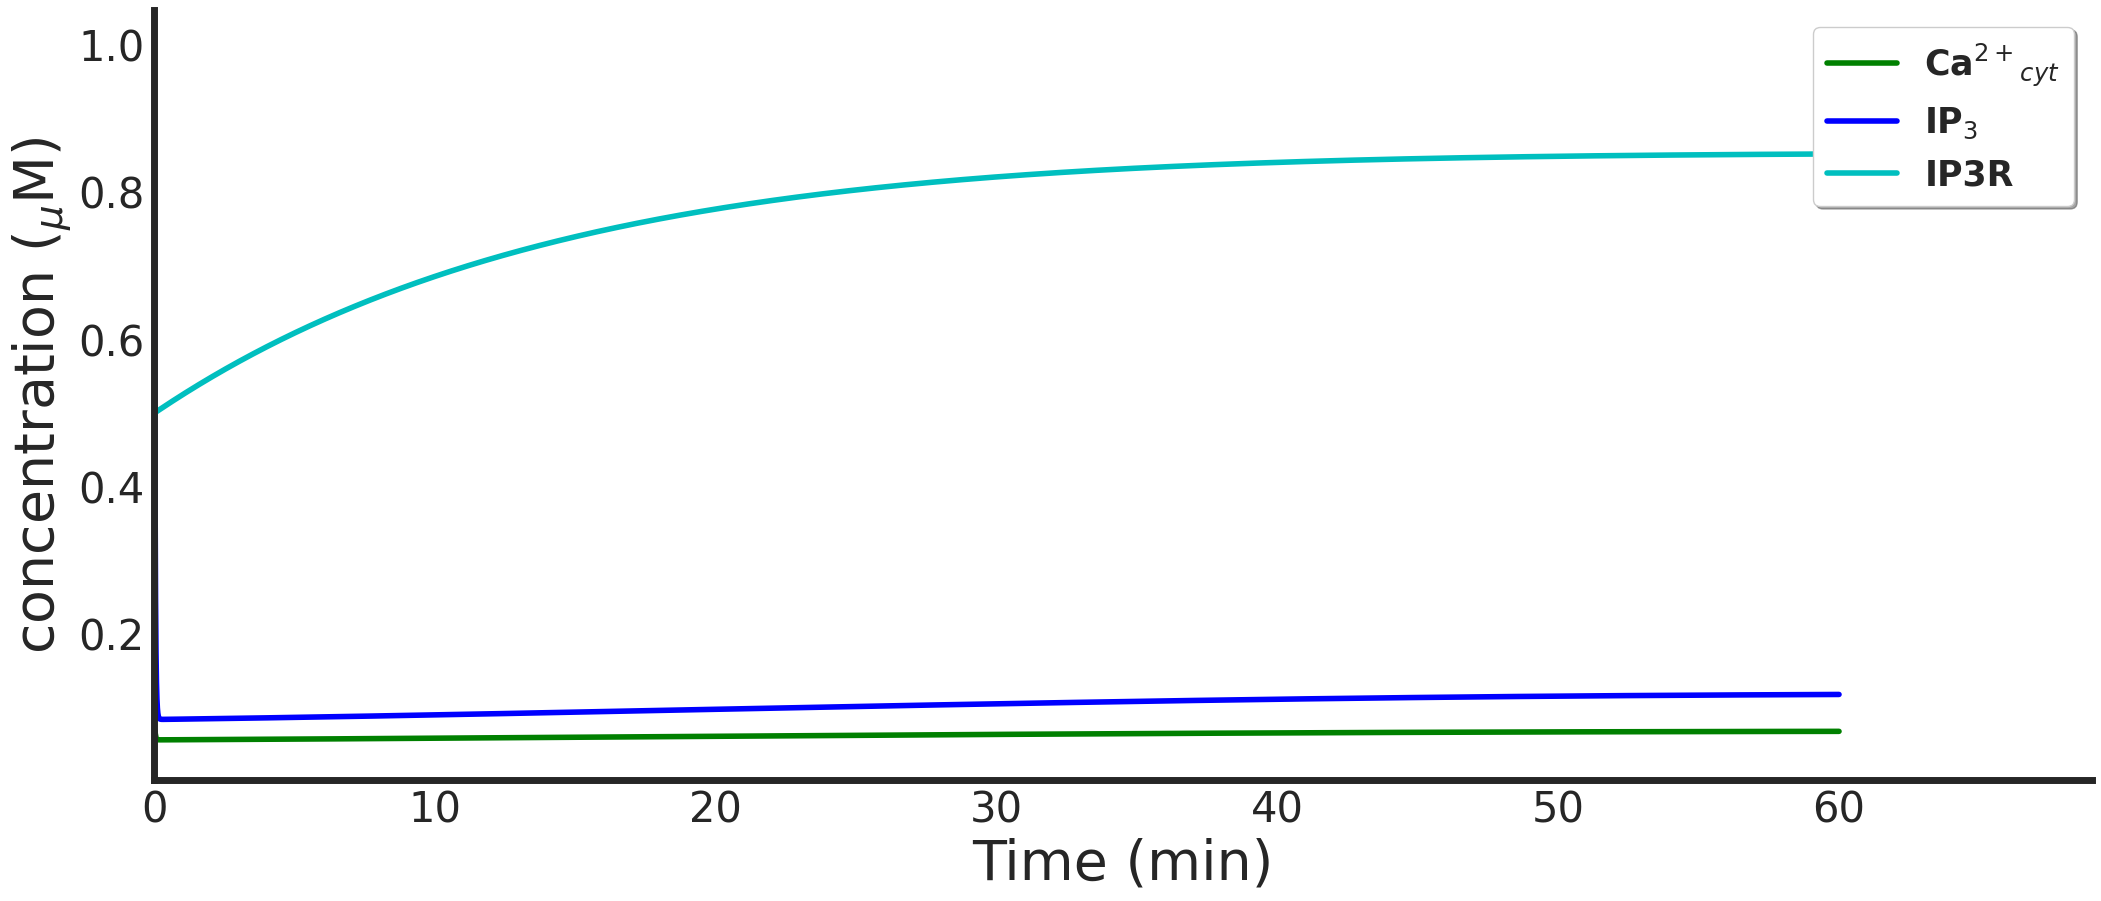

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

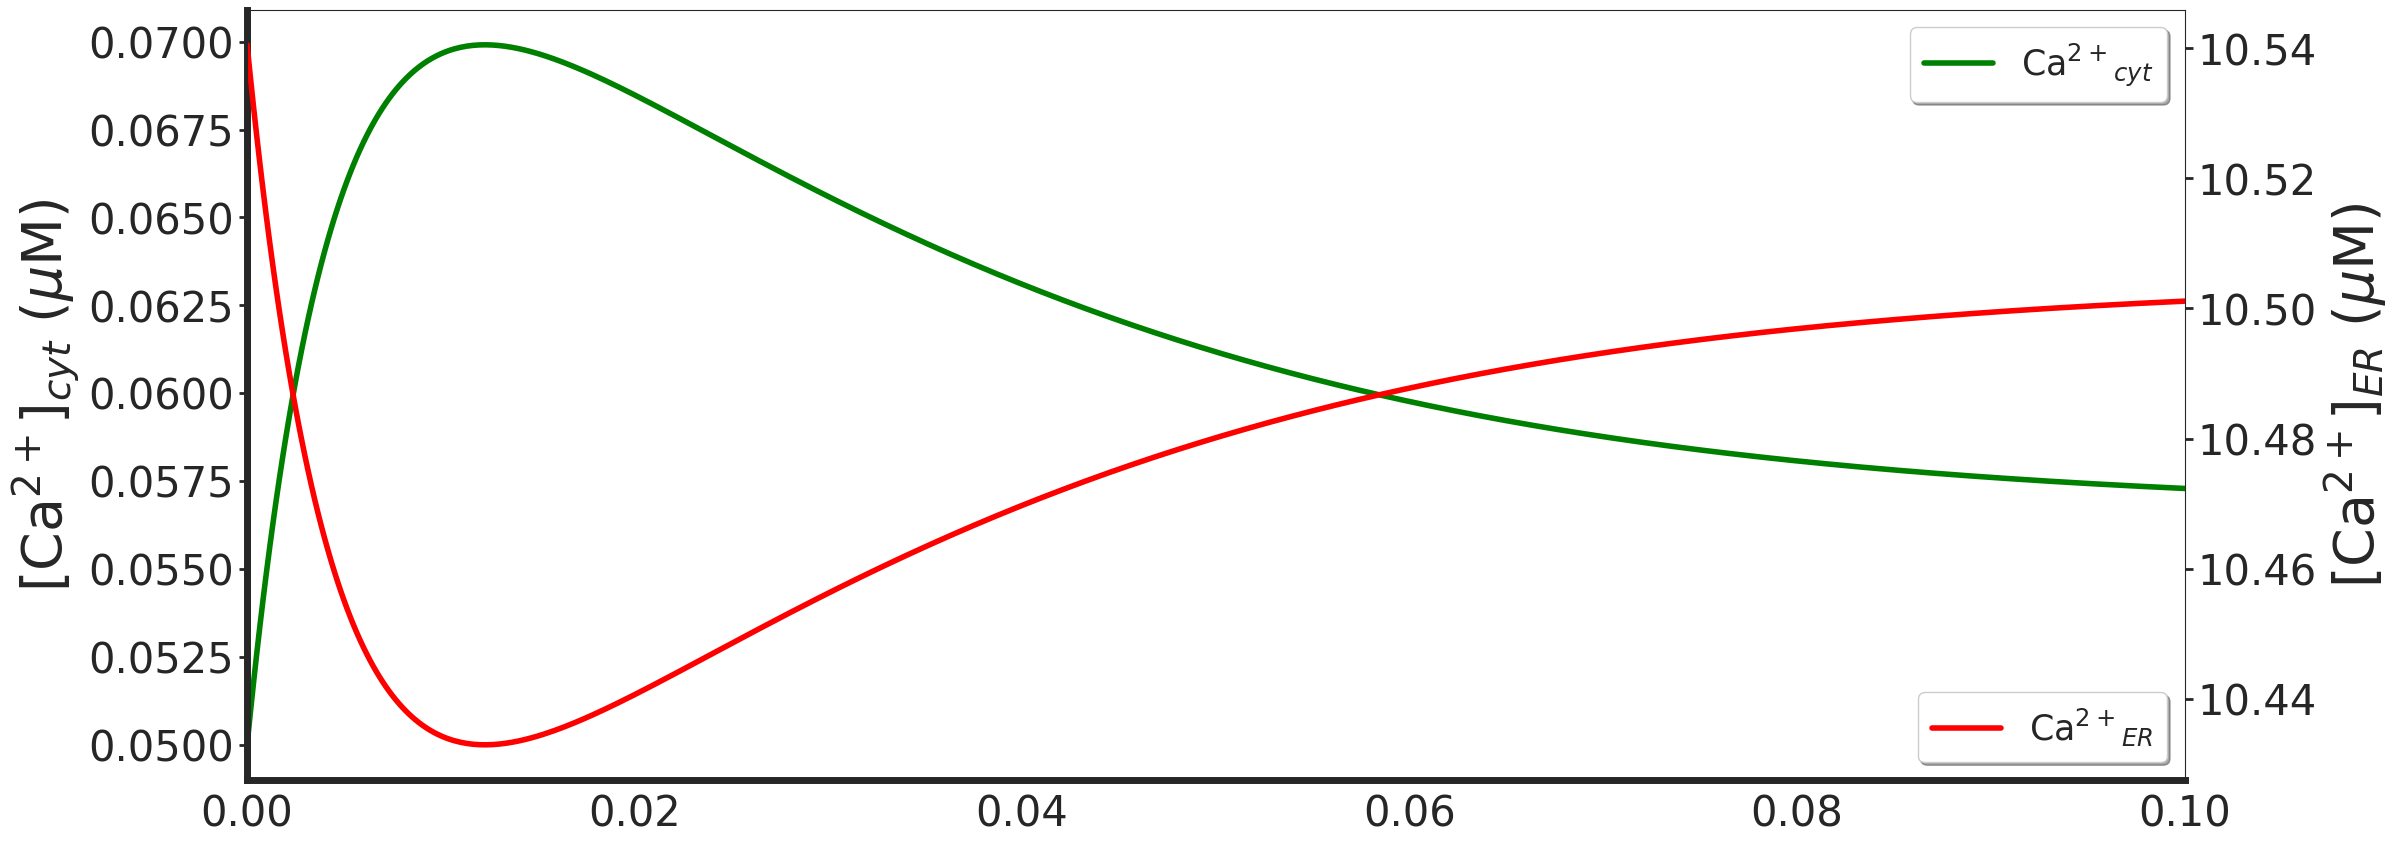

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax1 = ax.twinx()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    ax.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax1.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax1.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax.tick_params(axis='x', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='x', which='minor', labelsize=30, length=4, width=1)


    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)


    ax.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    ax1.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$]$_{cyt}$ ($\mu$M)',fontsize=40)
    ax1.set_ylabel(r'[Ca$^{2+}$]$_{ER}$ ($\mu$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax1.legend(loc=4, shadow=True, prop=legend_properties)
    ax.set_xlim([0,0.1])

#VPLC = 0.8

Same equations as used in the previous block, only changing the value of VPLC. Refer to previous block for detailed comments of the equations

In [ ]:
def Ca_cyt_dot(Ca_cyt, IP3, IP3R,C_ER):
  k1 = 1.11
  k2 = 0.0203
  Ka = 0.08
  Kp = 0.13
  k3= 0.4
  k3z = 0.0
  k5 = 0.66

  Kserca = 0.1
  Vserca = 0.9
  # no need to solve Calcium in reticulum with an ODE because total Calcium is constant so
  Ctot = 2.0
  beta = 0.185
  #Ca_R = (Ctot-Ca_cyt)/beta we don't need this anymore since we have the actual calcium in reticulum ode
  eps = 0.0
  v0 = 0.0008
  vpm = 0.0
  kpm = 0.01
  phi = 0.0
  vplc = 0.8
  return (k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt) - Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)+eps*(v0+(phi*vplc)/((k3z+k5))-(vpm*Ca_cyt**2/(kpm**2+Ca_cyt**2))) #added in the calcium in the reticulum

def IP3R_dot(Ca_cyt, IP3, IP3R):
  tau_max = 1000 #add tau_new_max and rewrite
  k_tau = 1 #is like vplc and has range from 0.5 to 1.2 but we can only change one (either vplc or ktau)
  tau_new_update = tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4)
  ki = 0.4
  return (1.0/tau_new_update)*(1-IP3R*(ki+Ca_cyt)/ki)

def IP3_dot(Ca_cyt, IP3, IP3R):
  k5 = 0.66 # parameter
  k3 = 0.4
  k3z= 0.0
  VPLC = 0.8 # paramter (is from .1-1.5 micromoles)
  K_PLC = 0.2 # parameter
  tau_p = 1
  vplc = (VPLC*Ca_cyt**2/(K_PLC**2+Ca_cyt**2))
  vdeg = (k5+(k3z*Ca_cyt**2/(k3**2+Ca_cyt**2)))*IP3
  return tau_p * (vplc - vdeg)
def C_ER_dot(Ca_cyt, IP3, IP3R, C_ER):
  beta = 0.185
  Kserca = 0.1
  Vserca = 0.9
  k1 = 1.11
  Ka = 0.08
  Kp = 0.13
  k2 = 0.0203
  Ctot = 2.0
  Ca_R = (Ctot-Ca_cyt)/beta
  return (1.0/beta)*((((Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)))-(k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt)))




In [ ]:
dt = 0.01 #s
t_final = 3600 # s
n_steps = int(t_final/dt)
# create arrays to store solution
Ca_cyt_vec = np.zeros((n_steps))
IP3_vec = np.zeros((n_steps))
C_ER_vec = np.zeros((n_steps))
IP3R_vec = np.zeros((n_steps))
time_vec = np.zeros((n_steps))
# Initial conditions
Ca_cyt_vec[0] = .05
IP3_vec[0] = 1
C_ER_vec[0] = (2.0 - .05)/0.185
IP3R_vec[0] = 0.5

for i in range(n_steps-1):
  Ca_cyt_vec[i+1] = Ca_cyt_vec[i]+dt*Ca_cyt_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3_vec[i+1] = IP3_vec[i]+dt*IP3_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  C_ER_vec[i+1] = C_ER_vec[i]+dt*C_ER_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3R_vec[i+1] = IP3R_vec[i]+dt*IP3R_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  time_vec[i+1] = time_vec[i]+dt

Plots with VPLC values of 0.8

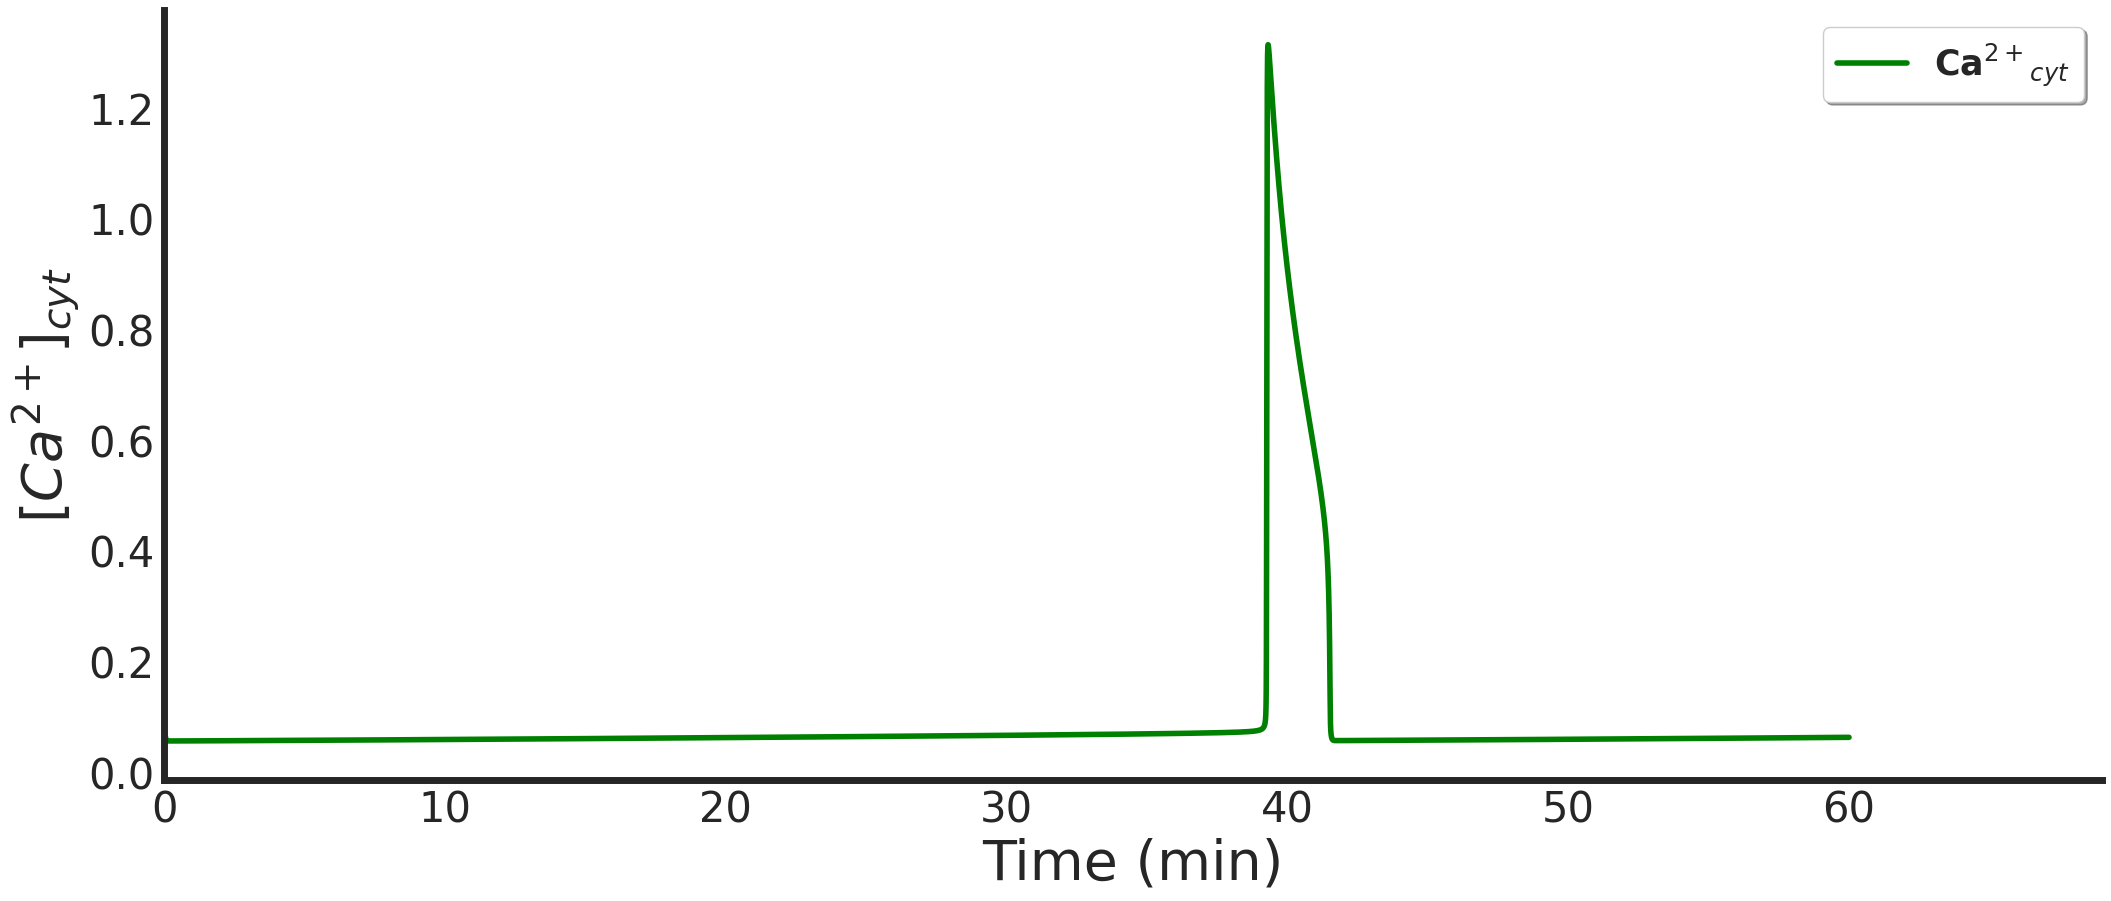

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[$Ca^{2+}$]$_{cyt}$',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

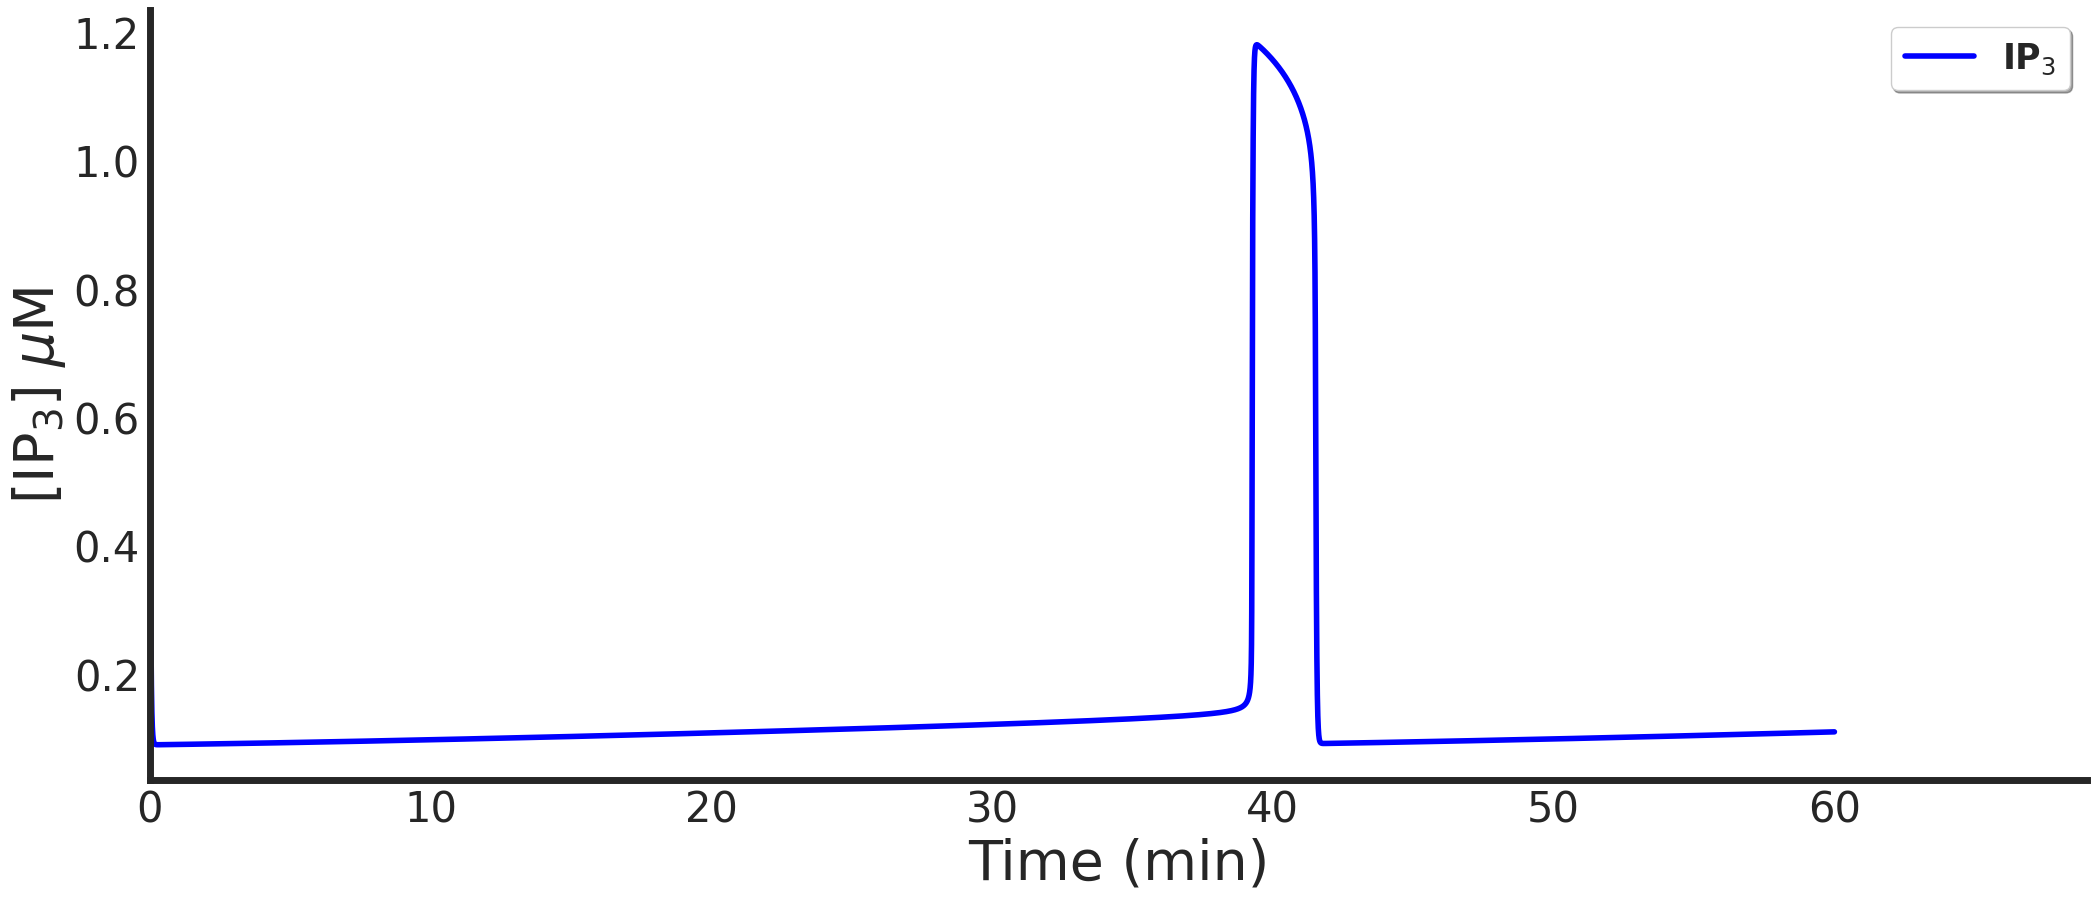

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

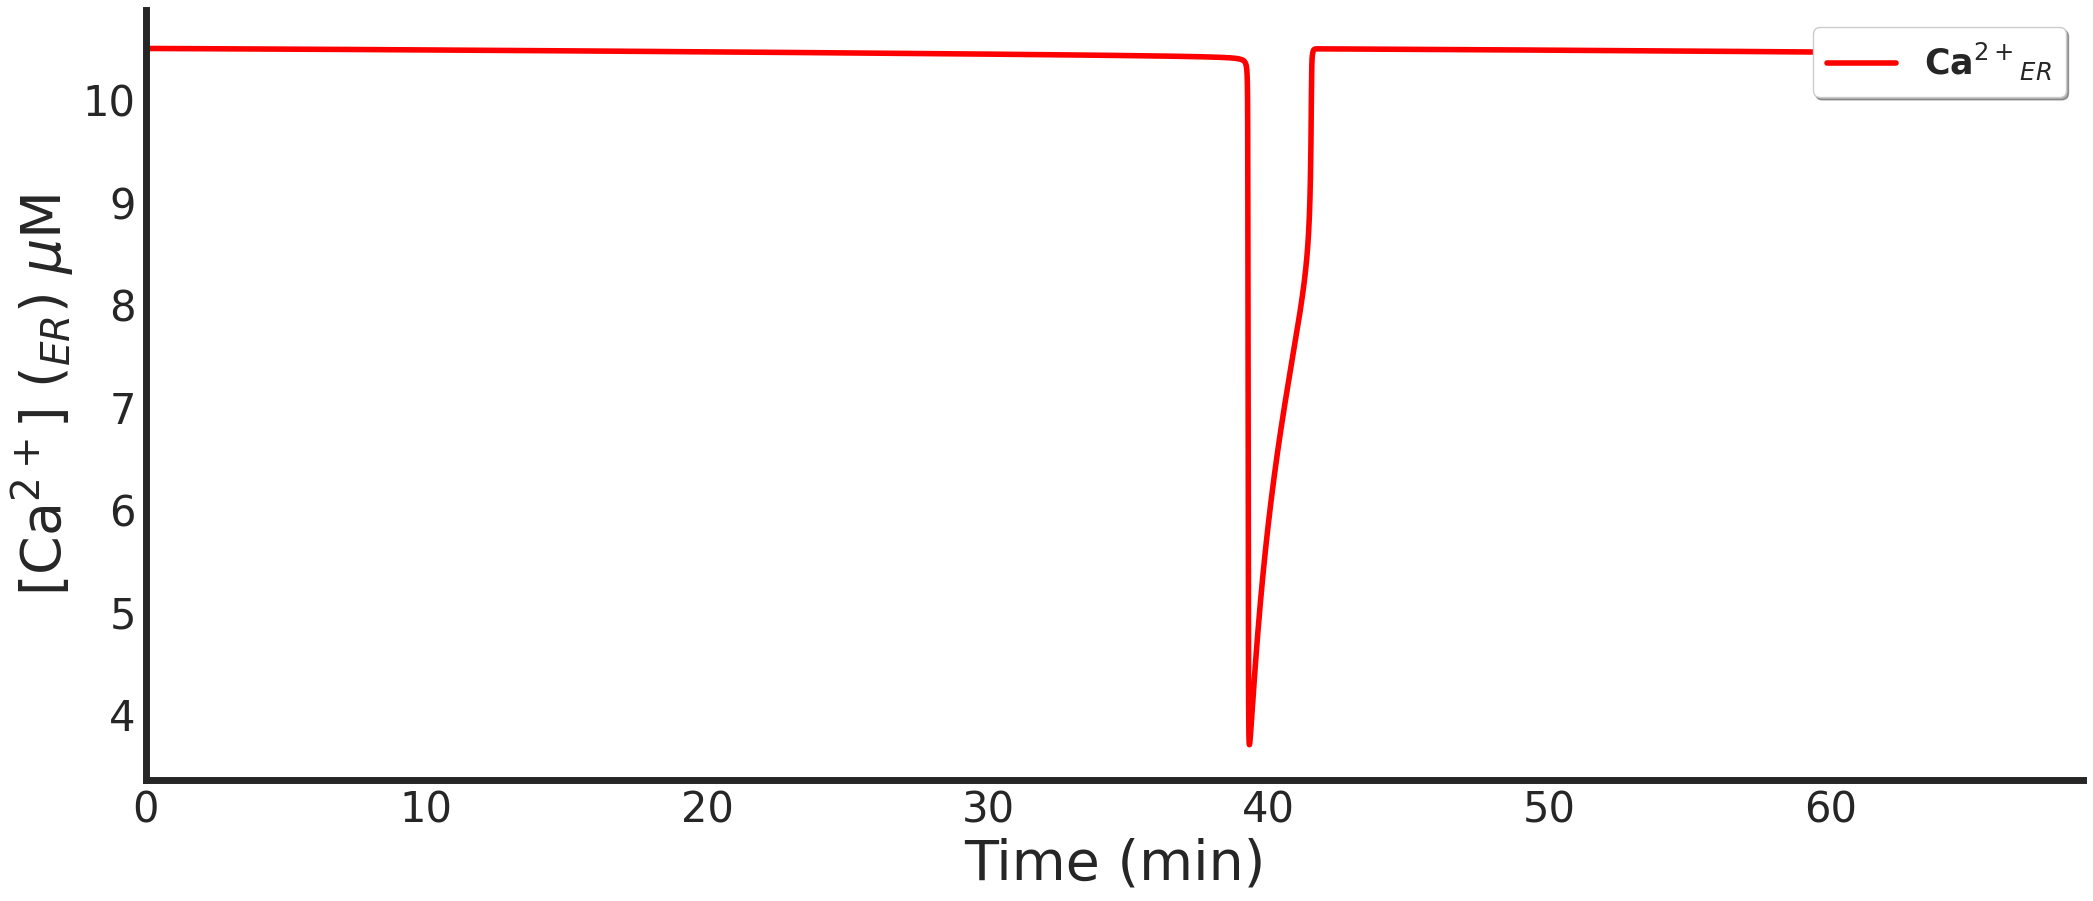

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$] ($_{ER}$) $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

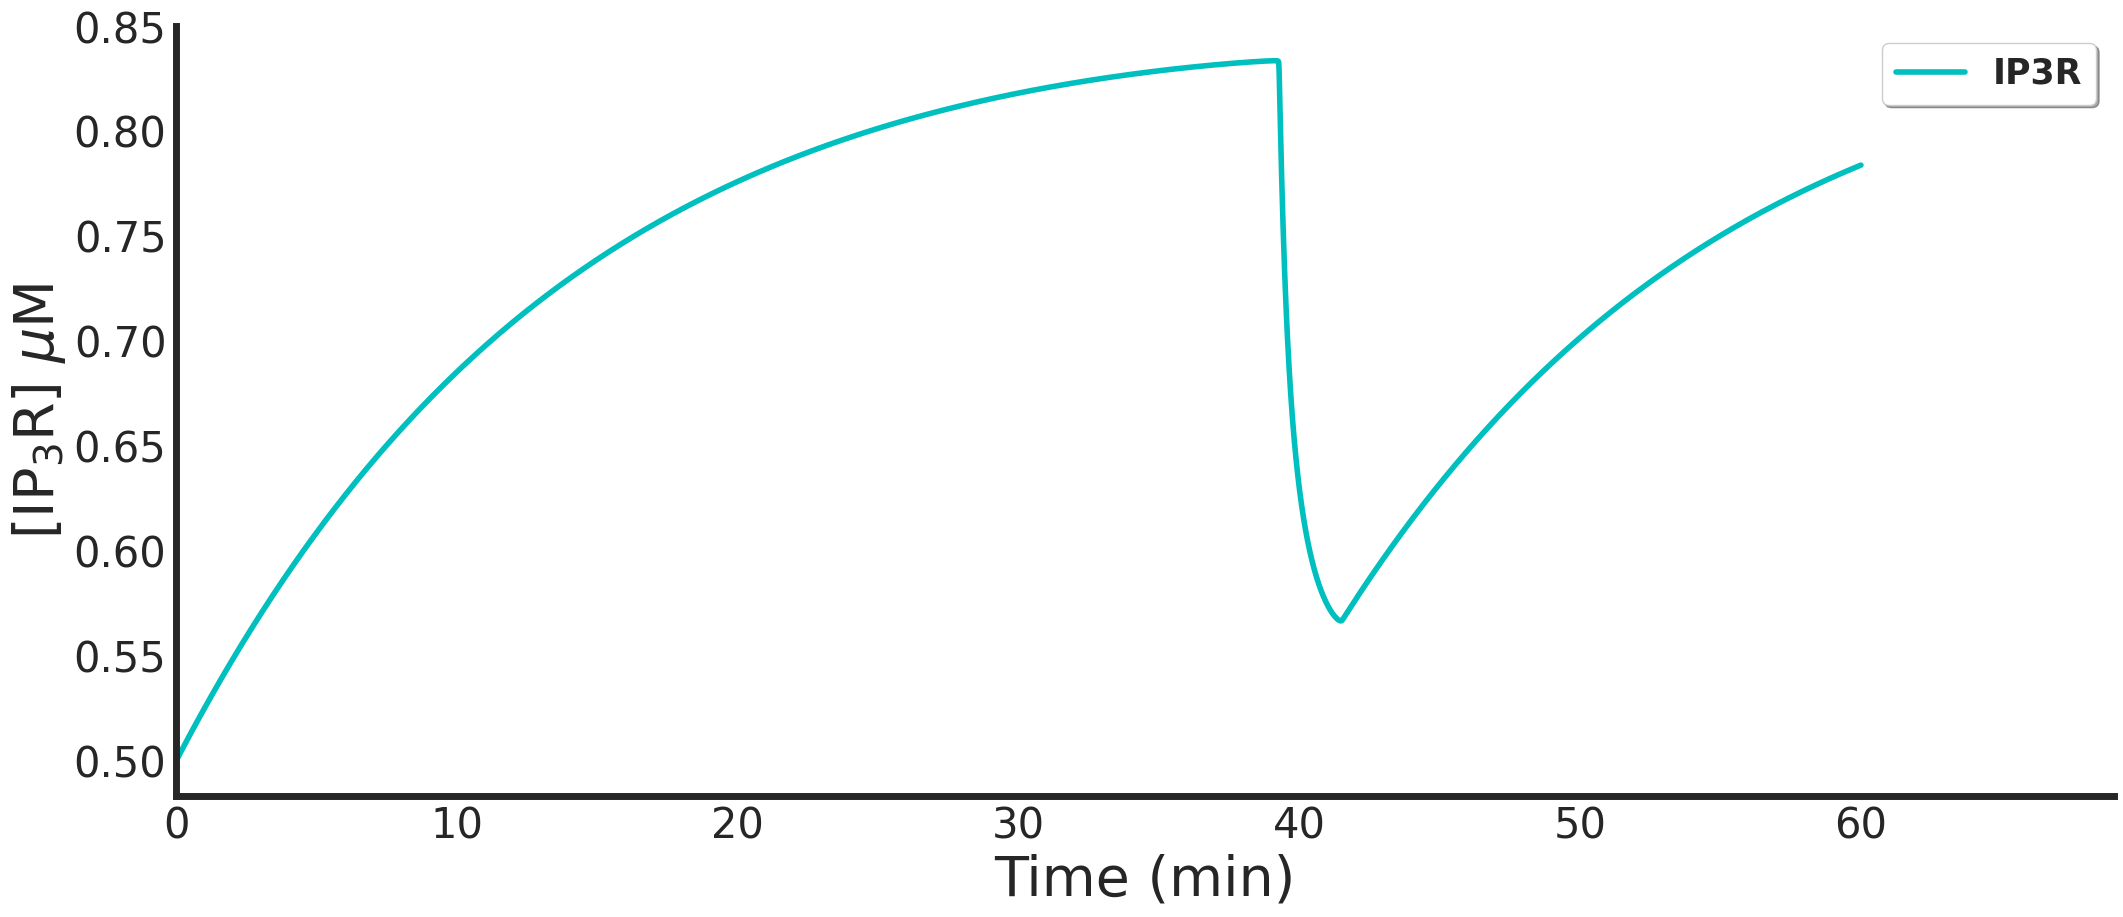

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$R] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

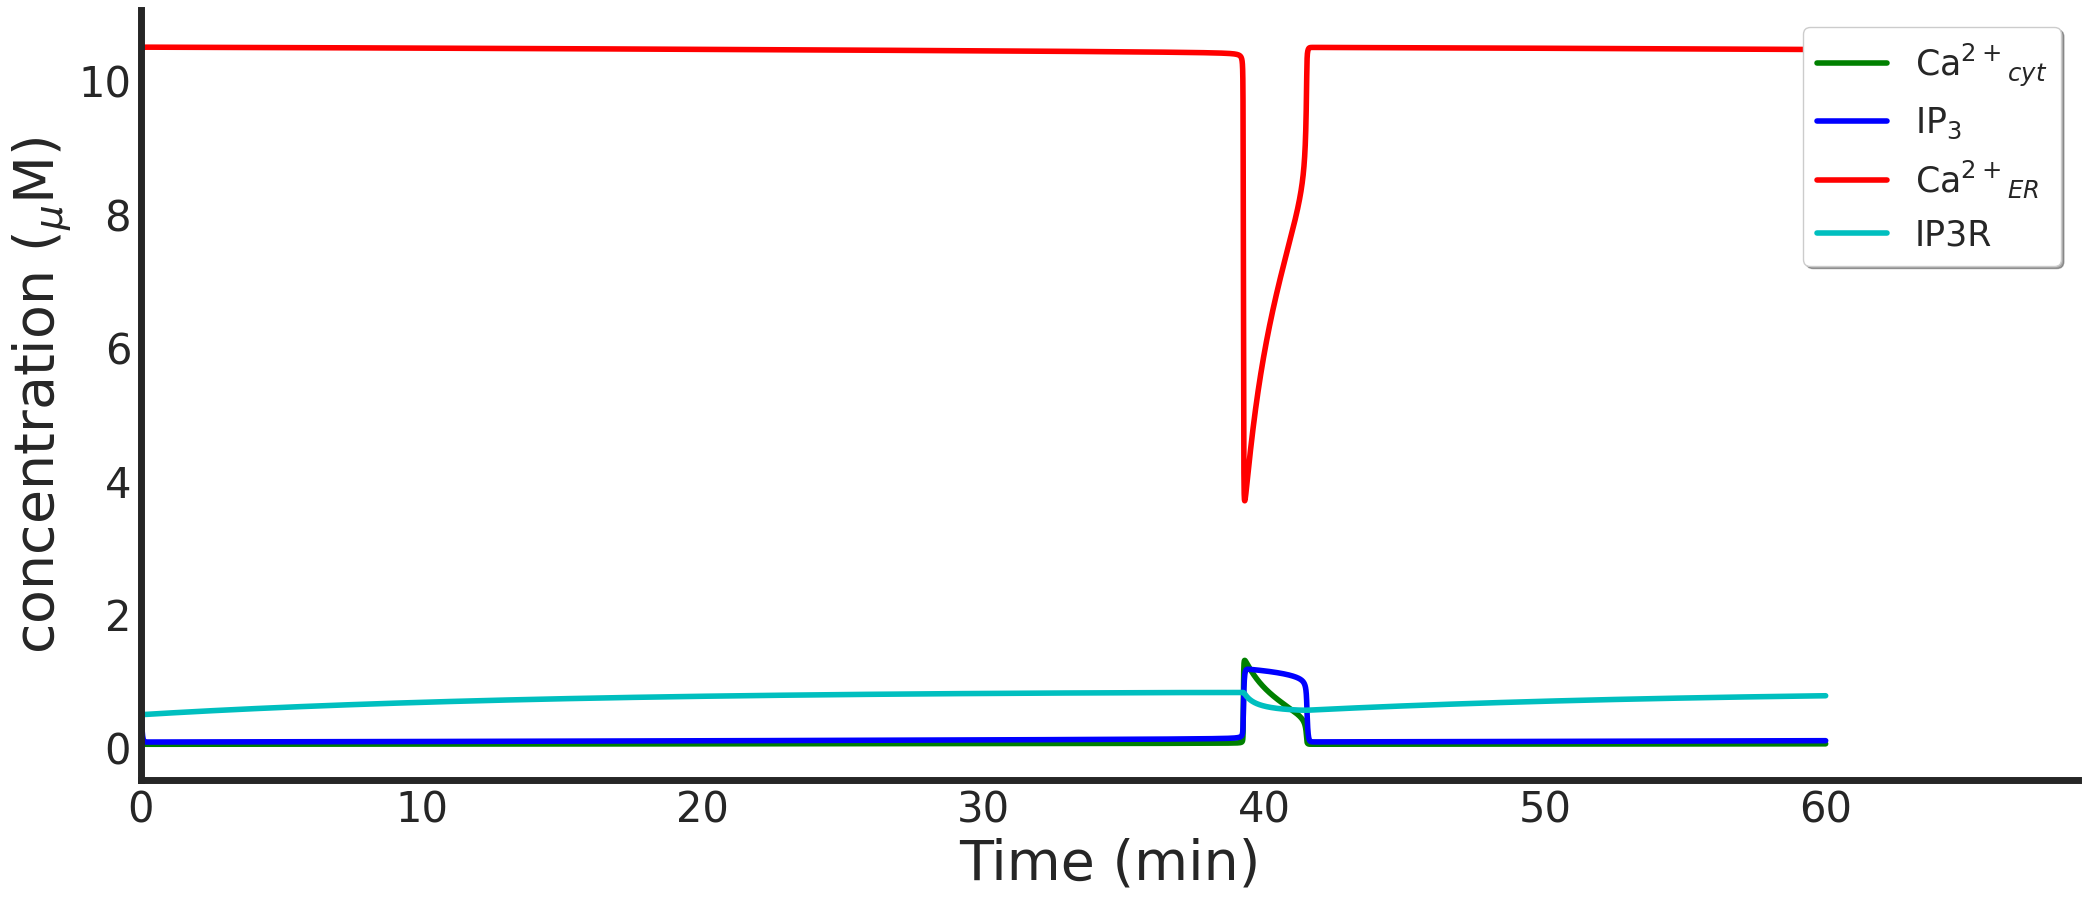

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

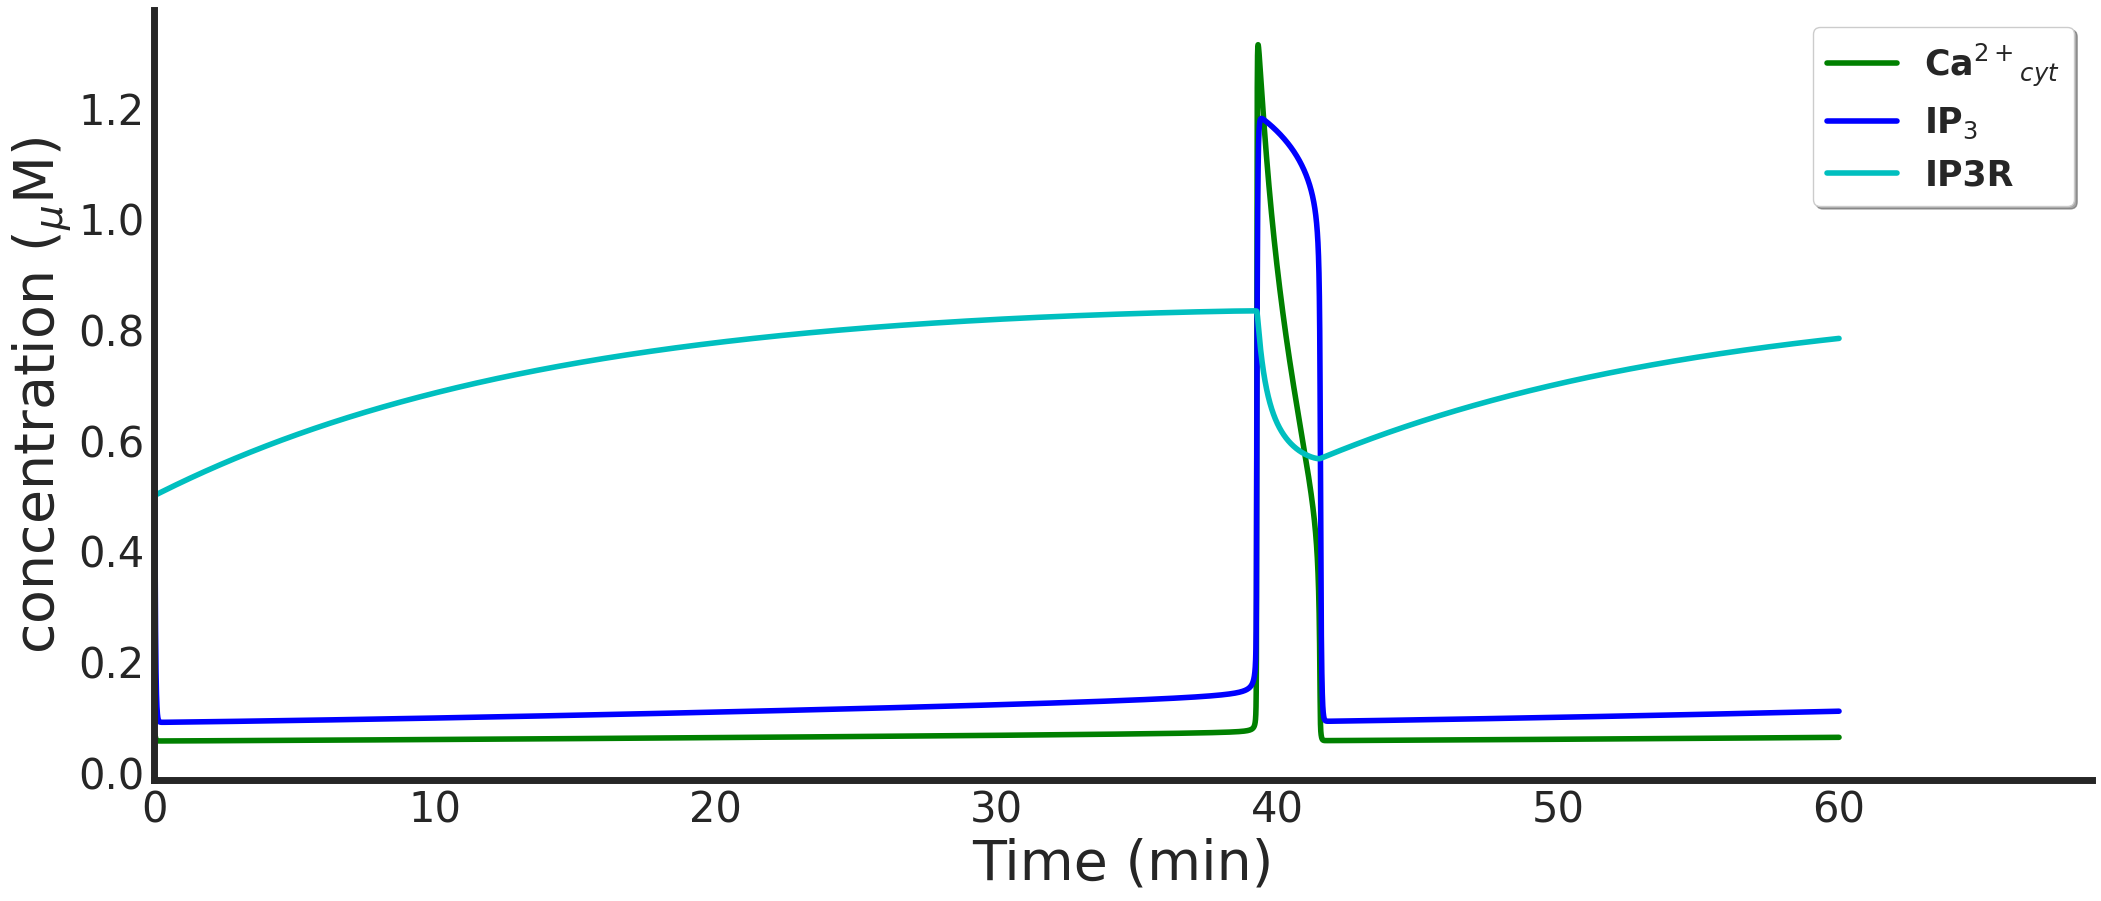

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

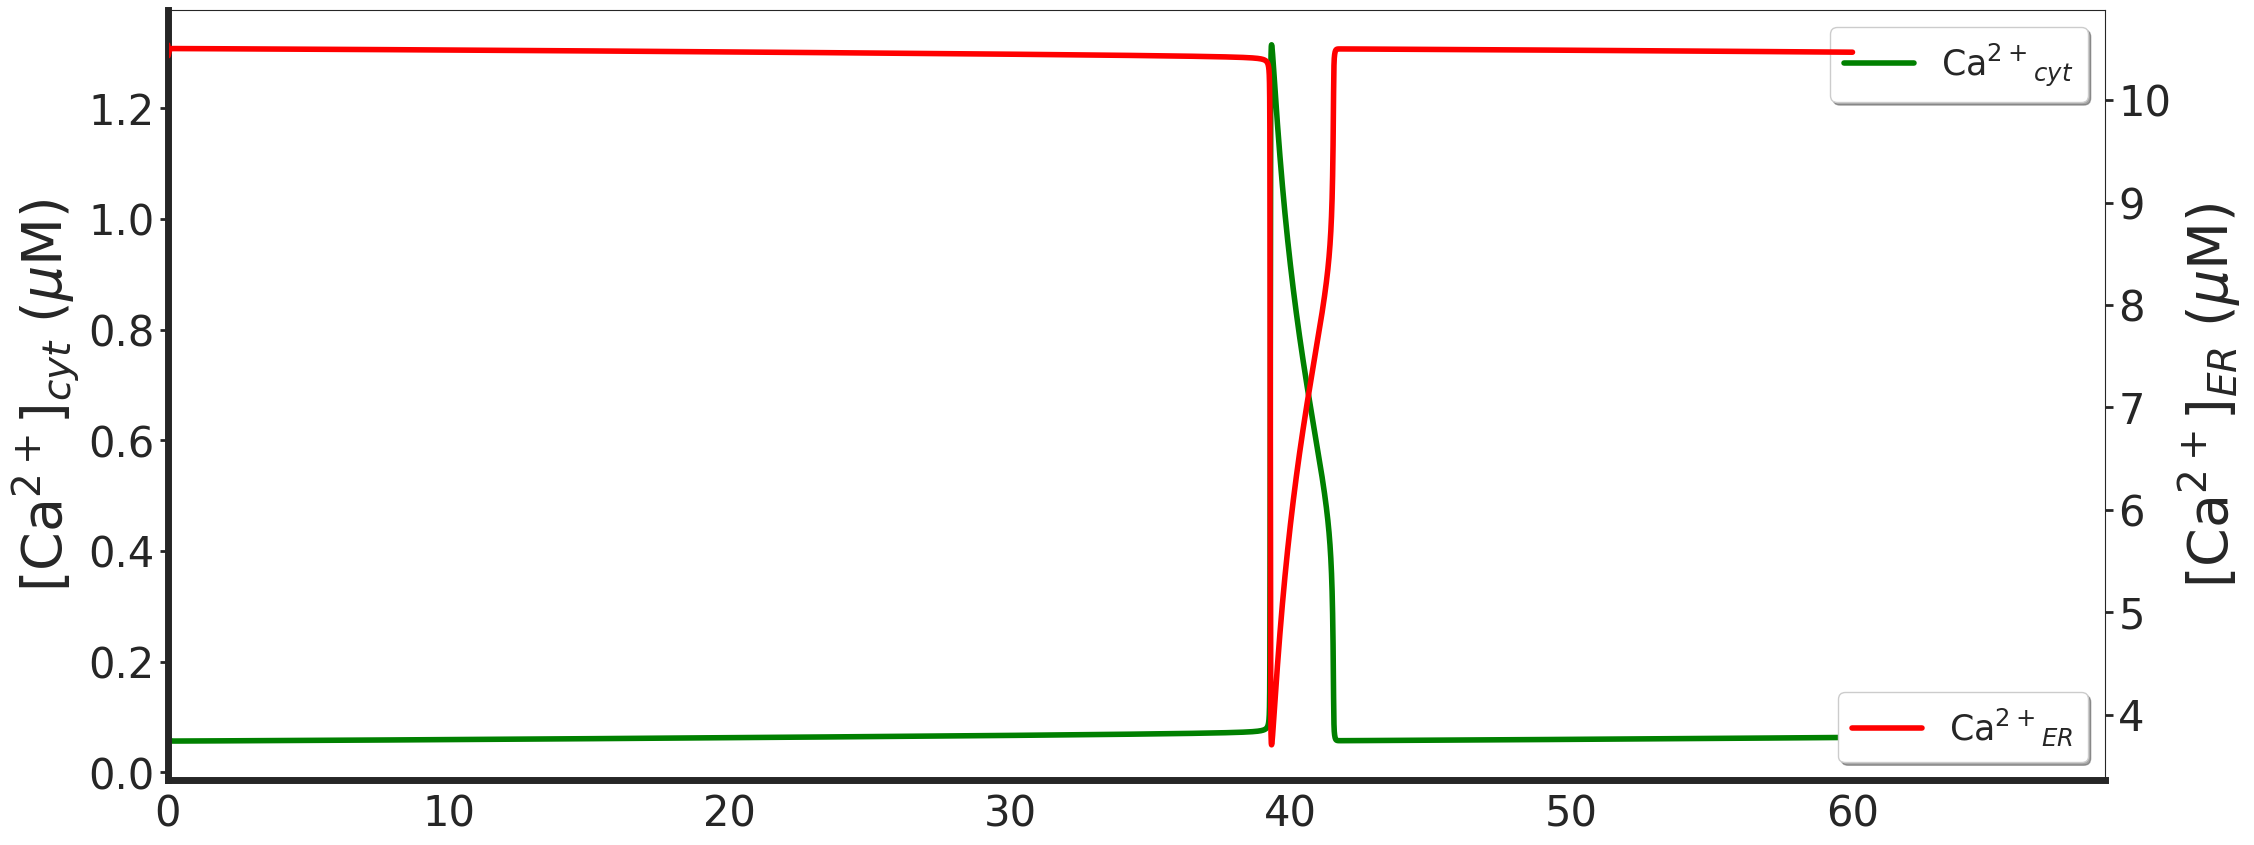

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax1 = ax.twinx()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    ax.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax1.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax1.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax.tick_params(axis='x', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='x', which='minor', labelsize=30, length=4, width=1)


    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)


    ax.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    ax1.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$]$_{cyt}$ ($\mu$M)',fontsize=40)
    ax1.set_ylabel(r'[Ca$^{2+}$]$_{ER}$ ($\mu$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax1.legend(loc=4, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

#VPLC = 1.2#
Same equations as used in the previous block, only changing the value of VPLC. Refer to first block for detailed comments of the equations.

In [ ]:
def Ca_cyt_dot(Ca_cyt, IP3, IP3R,C_ER):
  k1 = 1.11
  k2 = 0.0203
  Ka = 0.08
  Kp = 0.13
  k3= 0.4
  k3z = 0.0
  k5 = 0.66

  Kserca = 0.1
  Vserca = 0.9
  # no need to solve Calcium in reticulum with an ODE because total Calcium is constant so
  Ctot = 2.0
  beta = 0.185
  #Ca_R = (Ctot-Ca_cyt)/beta we don't need this anymore since we have the actual calcium in reticulum ode
  eps = 0.0
  v0 = 0.0008
  vpm = 0.0
  kpm = 0.01
  phi = 0.0
  vplc = 1.2
  return (k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt) - Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)+eps*(v0+(phi*vplc)/((k3z+k5))-(vpm*Ca_cyt**2/(kpm**2+Ca_cyt**2))) #added in the calcium in the reticulum

def IP3R_dot(Ca_cyt, IP3, IP3R):
  tau_max = 1000 #add tau_new_max and rewrite
  k_tau = 1 #is like vplc and has range from 0.5 to 1.2 but we can only change one (either vplc or ktau)
  tau_new_update = tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4)
  ki = 0.4
  return (1.0/tau_new_update)*(1-IP3R*(ki+Ca_cyt)/ki)

def IP3_dot(Ca_cyt, IP3, IP3R):
  k5 = 0.66 # parameter
  k3 = 0.4
  k3z= 0.0
  VPLC = 1.2 # paramter (is from .1-1.5 micromoles)
  K_PLC = 0.2 # parameter
  tau_p = 1
  vplc = (VPLC*Ca_cyt**2/(K_PLC**2+Ca_cyt**2))
  vdeg = (k5+(k3z*Ca_cyt**2/(k3**2+Ca_cyt**2)))*IP3
  return tau_p * (vplc - vdeg)
def C_ER_dot(Ca_cyt, IP3, IP3R, C_ER):
  beta = 0.185
  Kserca = 0.1
  Vserca = 0.9
  k1 = 1.11
  Ka = 0.08
  Kp = 0.13
  k2 = 0.0203
  Ctot = 2.0
  Ca_R = (Ctot-Ca_cyt)/beta
  return (1.0/beta)*((((Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)))-(k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt)))




In [ ]:
dt = 0.01 #s
t_final = 3600 # s
n_steps = int(t_final/dt)
# create arrays to store solution
Ca_cyt_vec = np.zeros((n_steps))
IP3_vec = np.zeros((n_steps))
C_ER_vec = np.zeros((n_steps))
IP3R_vec = np.zeros((n_steps))
time_vec = np.zeros((n_steps))
# Initial conditions
Ca_cyt_vec[0] = .05
IP3_vec[0] = 1
C_ER_vec[0] = (2.0 - .05)/0.185
IP3R_vec[0] = 0.5

for i in range(n_steps-1):
  Ca_cyt_vec[i+1] = Ca_cyt_vec[i]+dt*Ca_cyt_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3_vec[i+1] = IP3_vec[i]+dt*IP3_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  C_ER_vec[i+1] = C_ER_vec[i]+dt*C_ER_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3R_vec[i+1] = IP3R_vec[i]+dt*IP3R_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  time_vec[i+1] = time_vec[i]+dt

Plots with VPLC values of 1.2

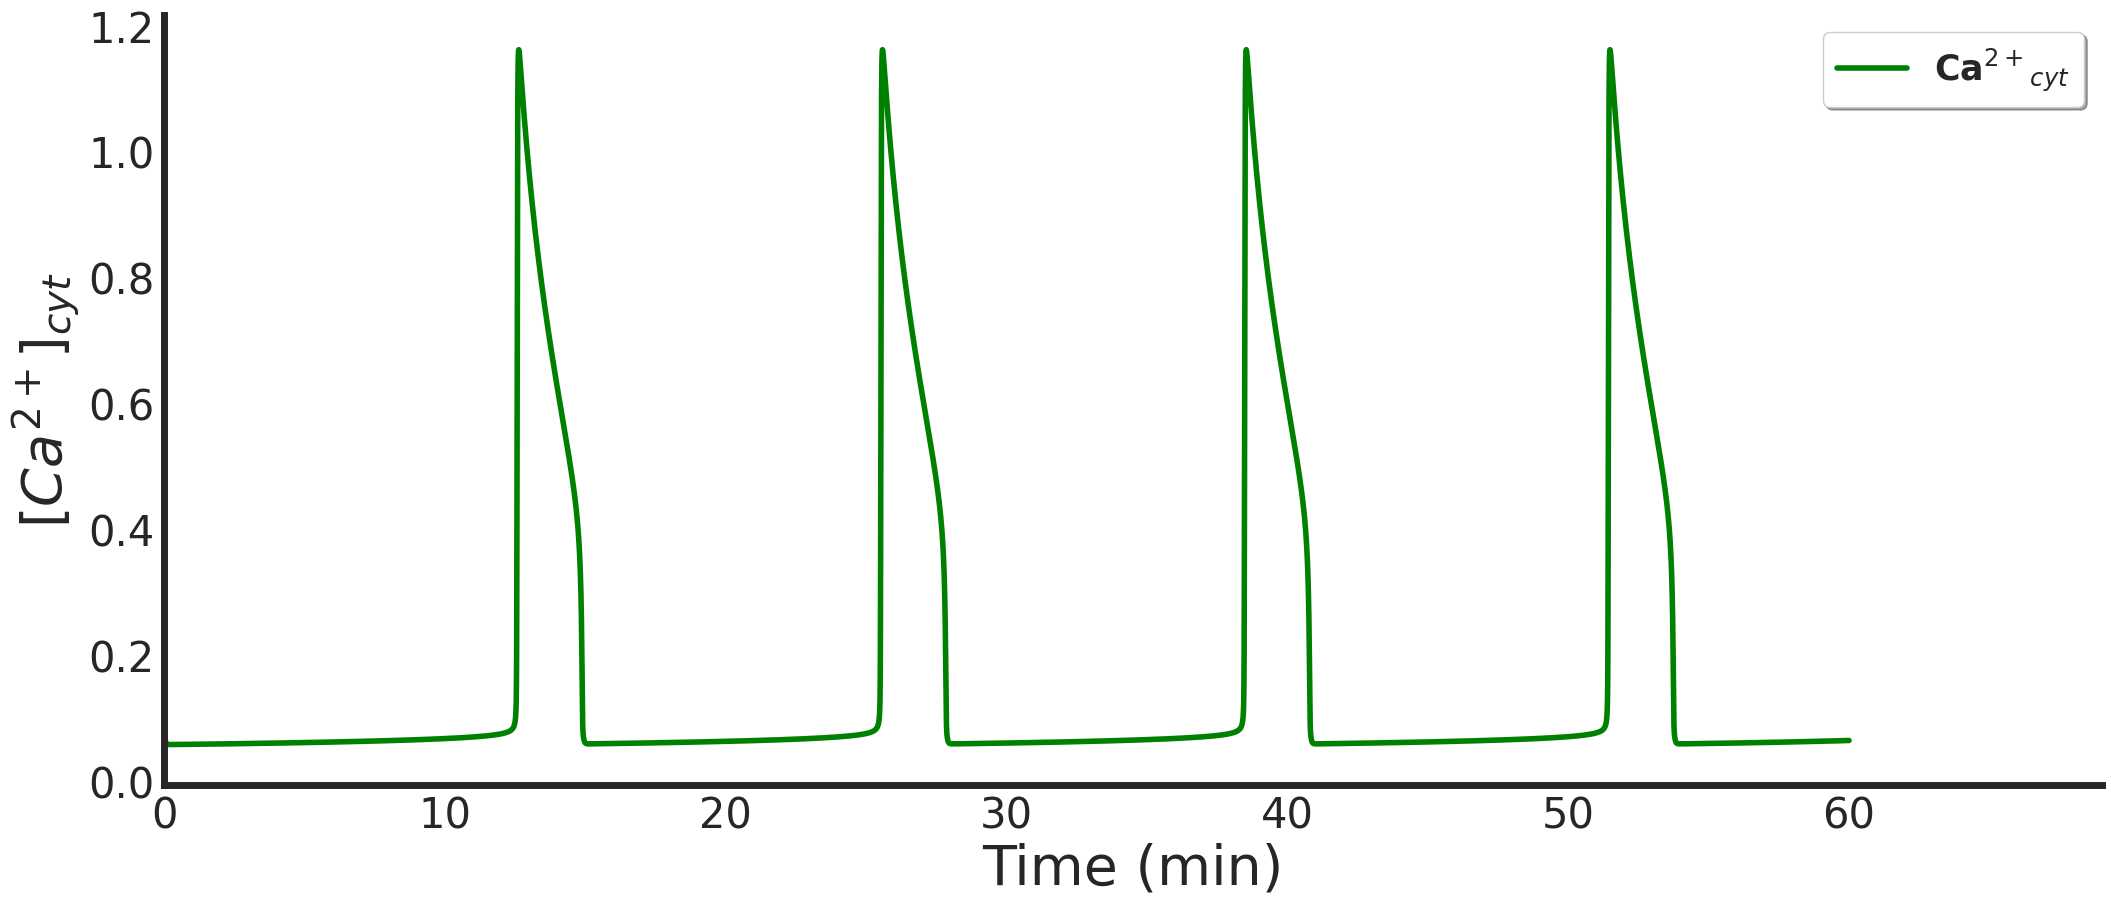

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[$Ca^{2+}$]$_{cyt}$',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

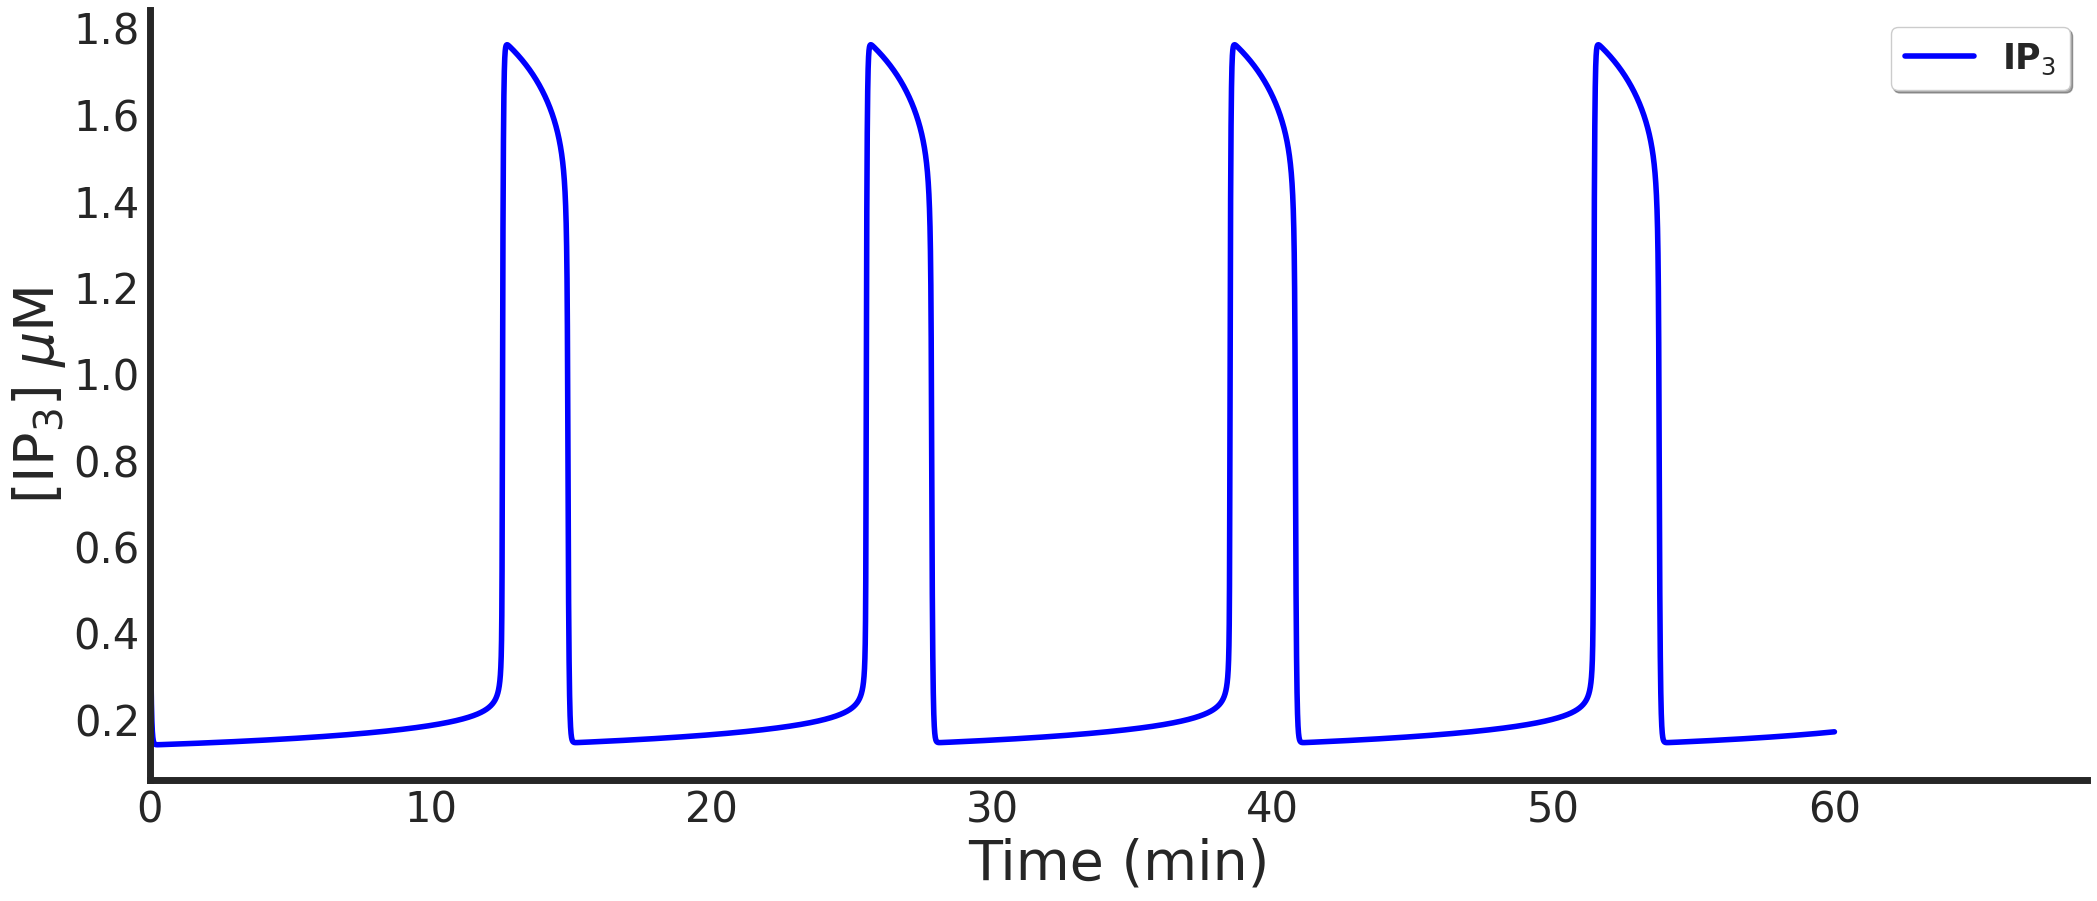

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

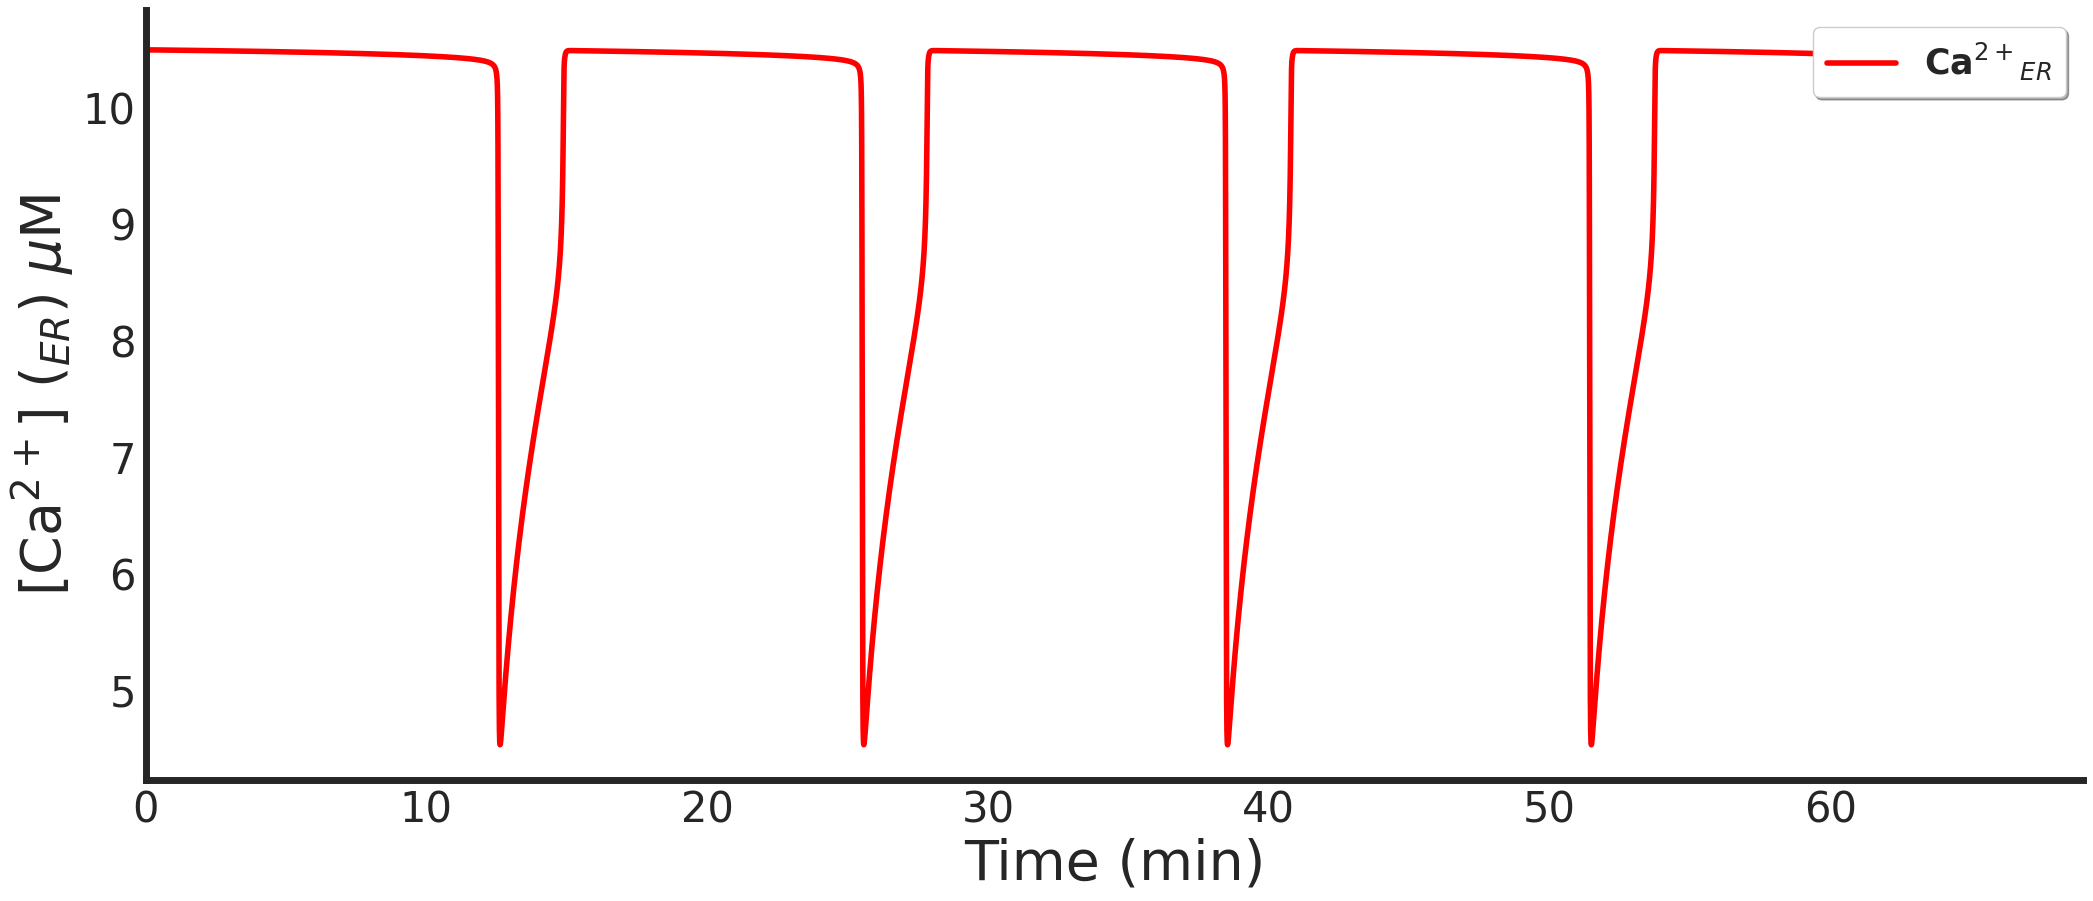

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$] ($_{ER}$) $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

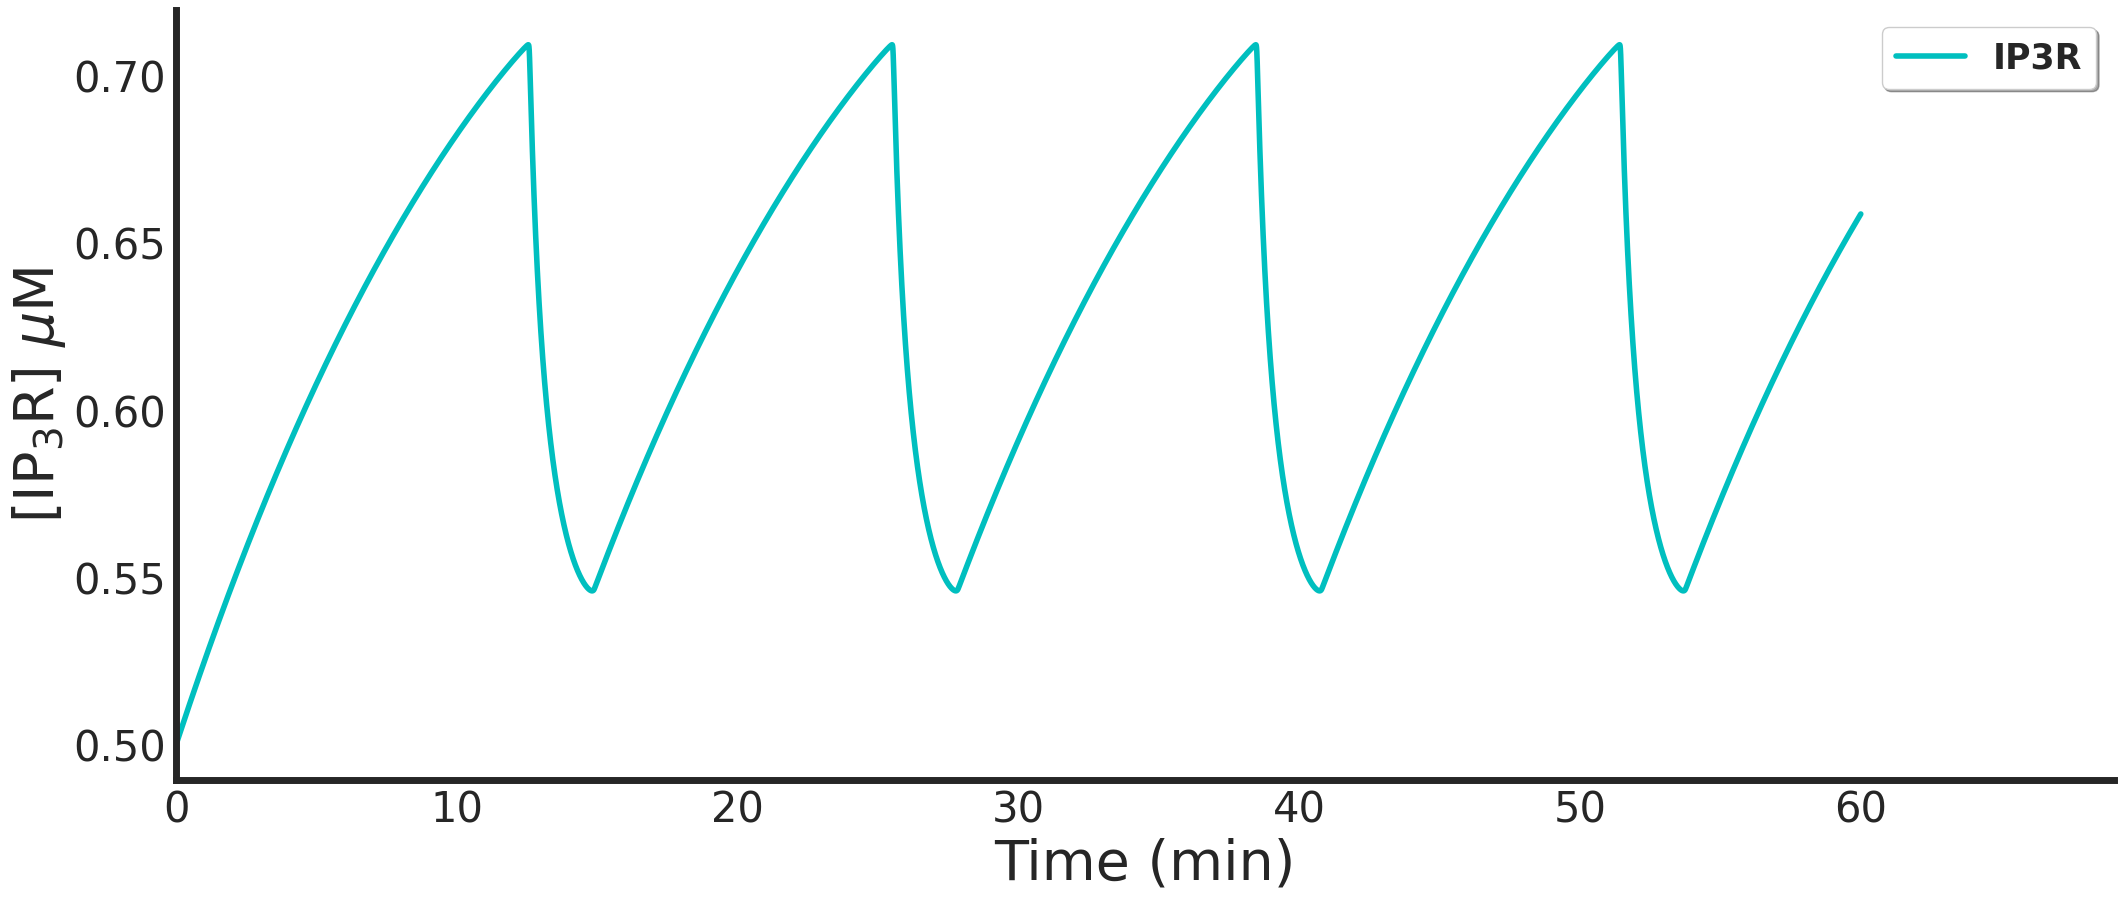

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$R] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

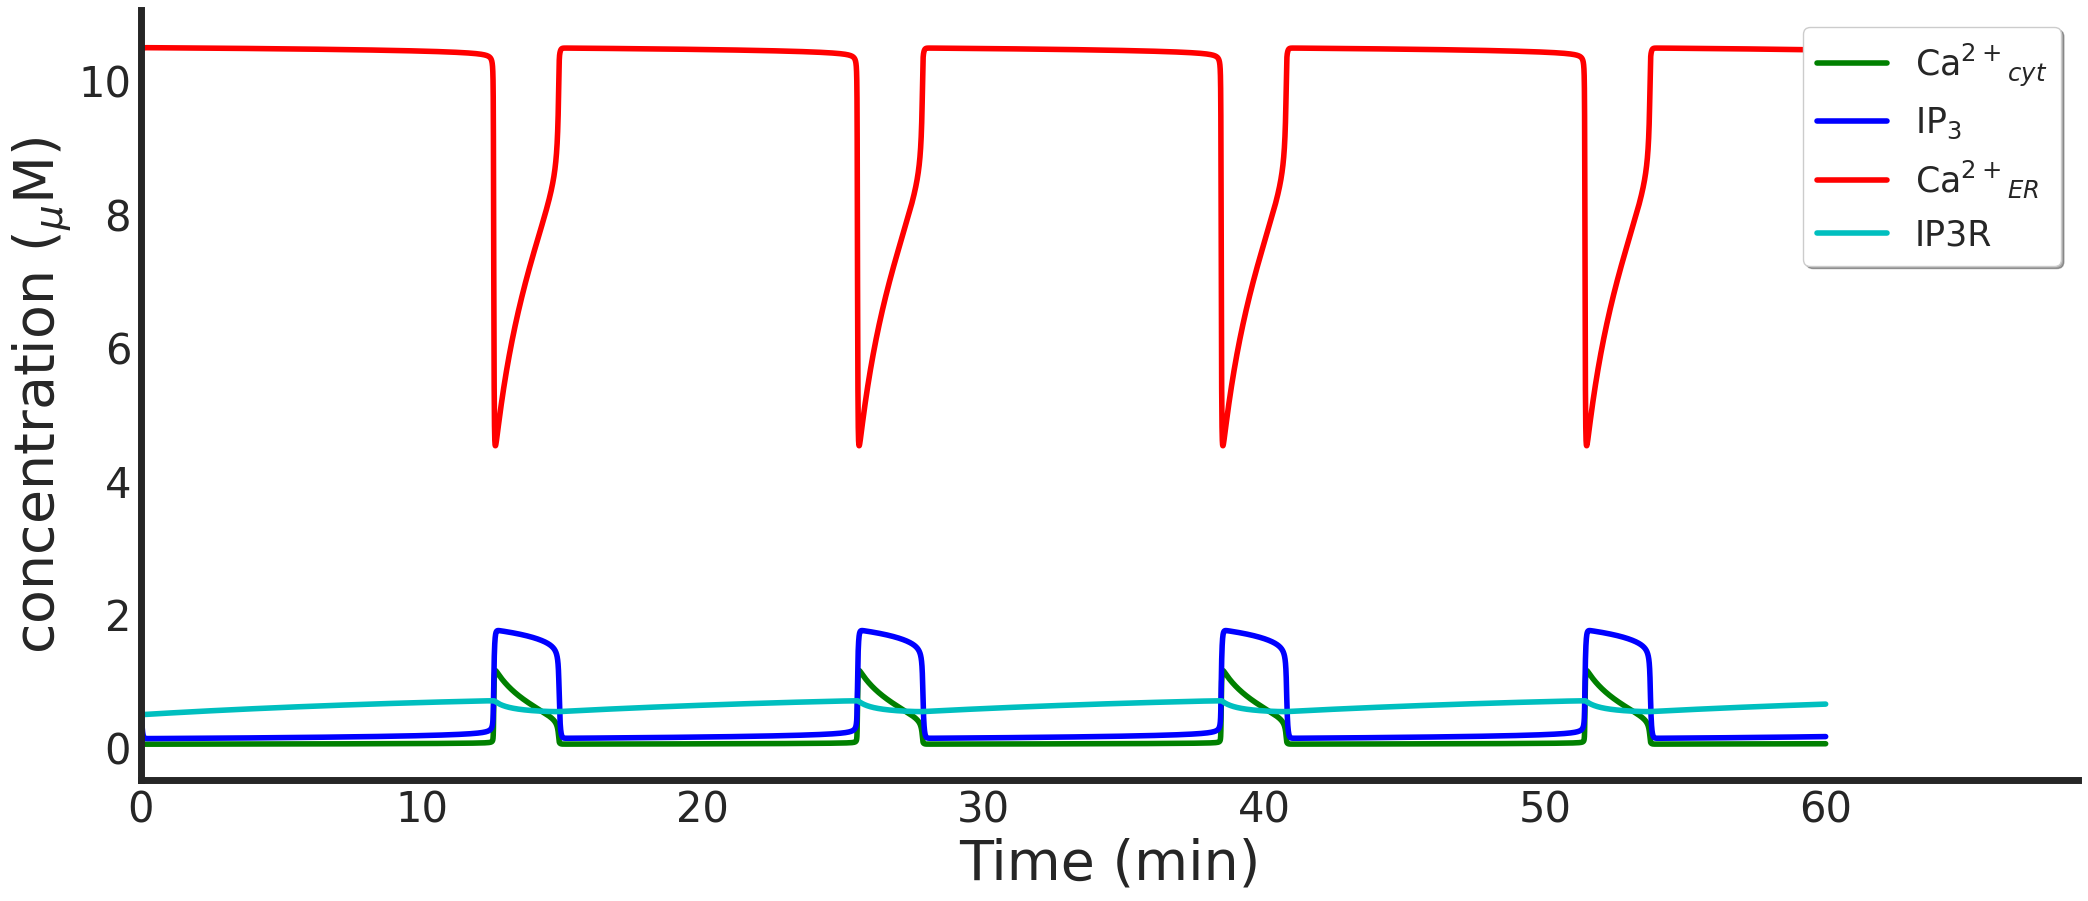

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

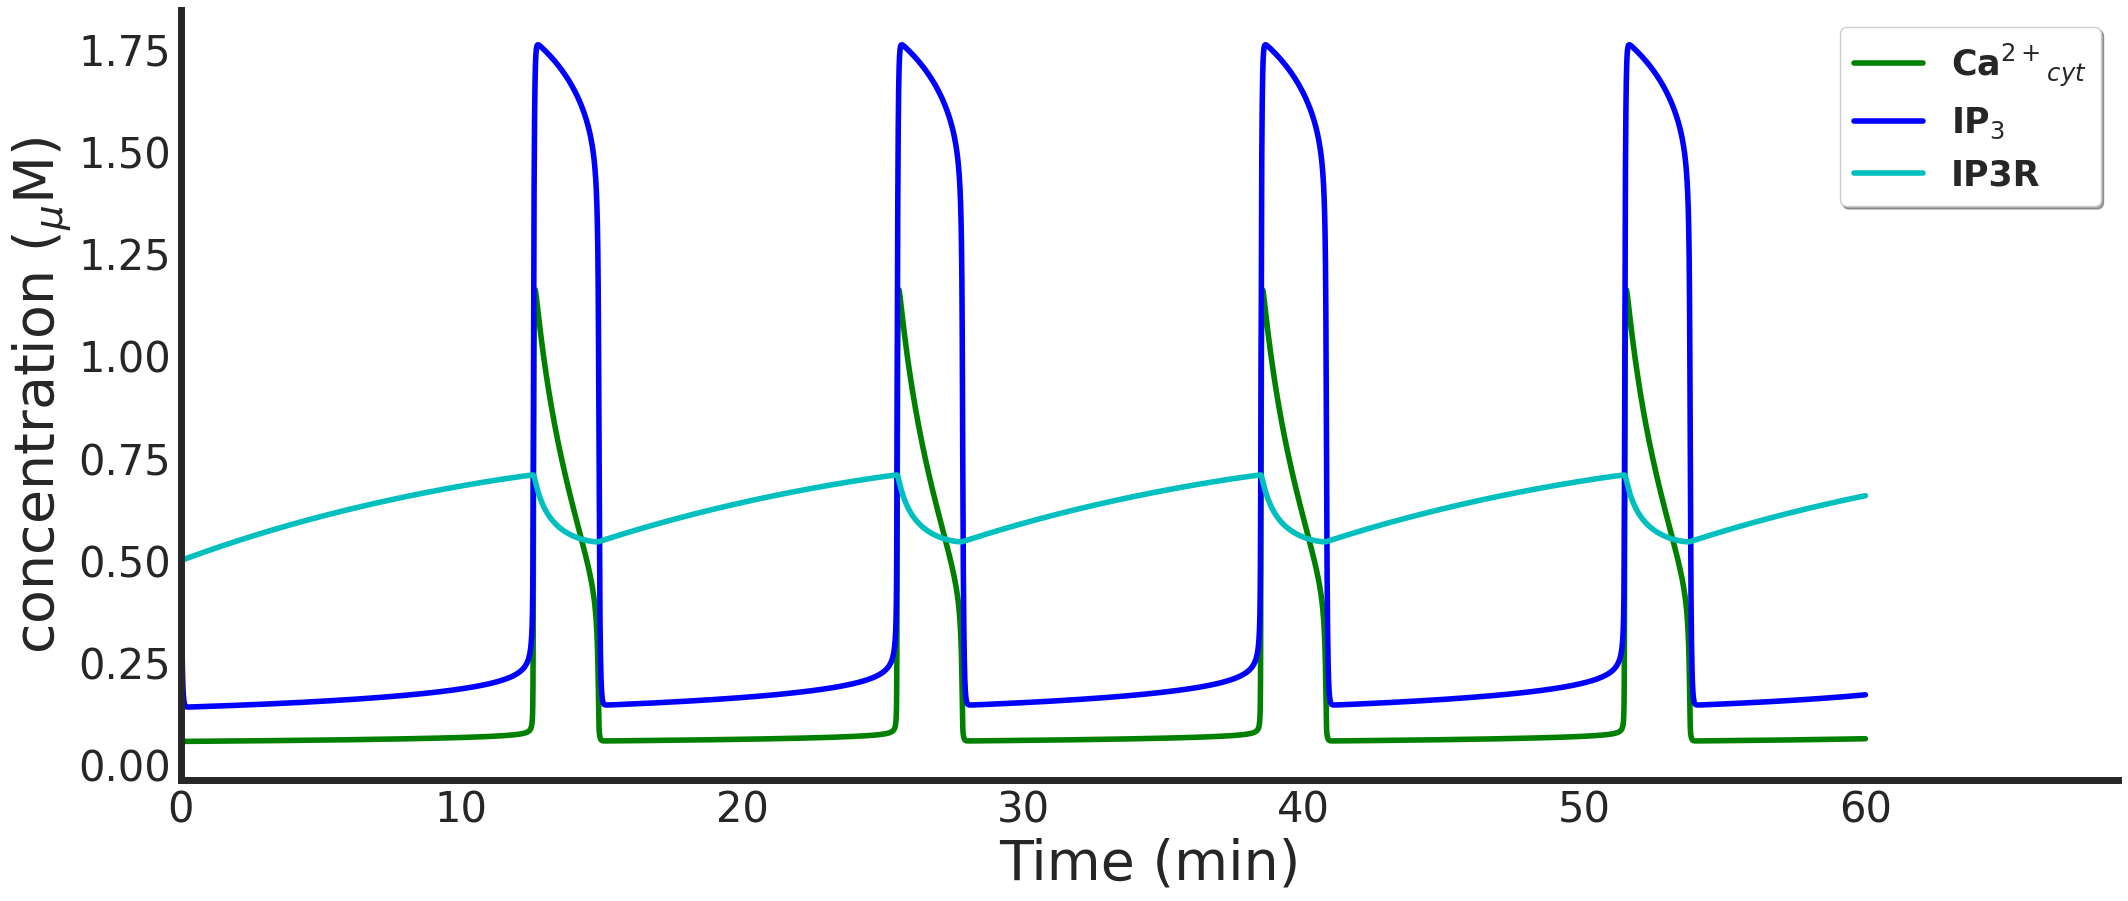

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

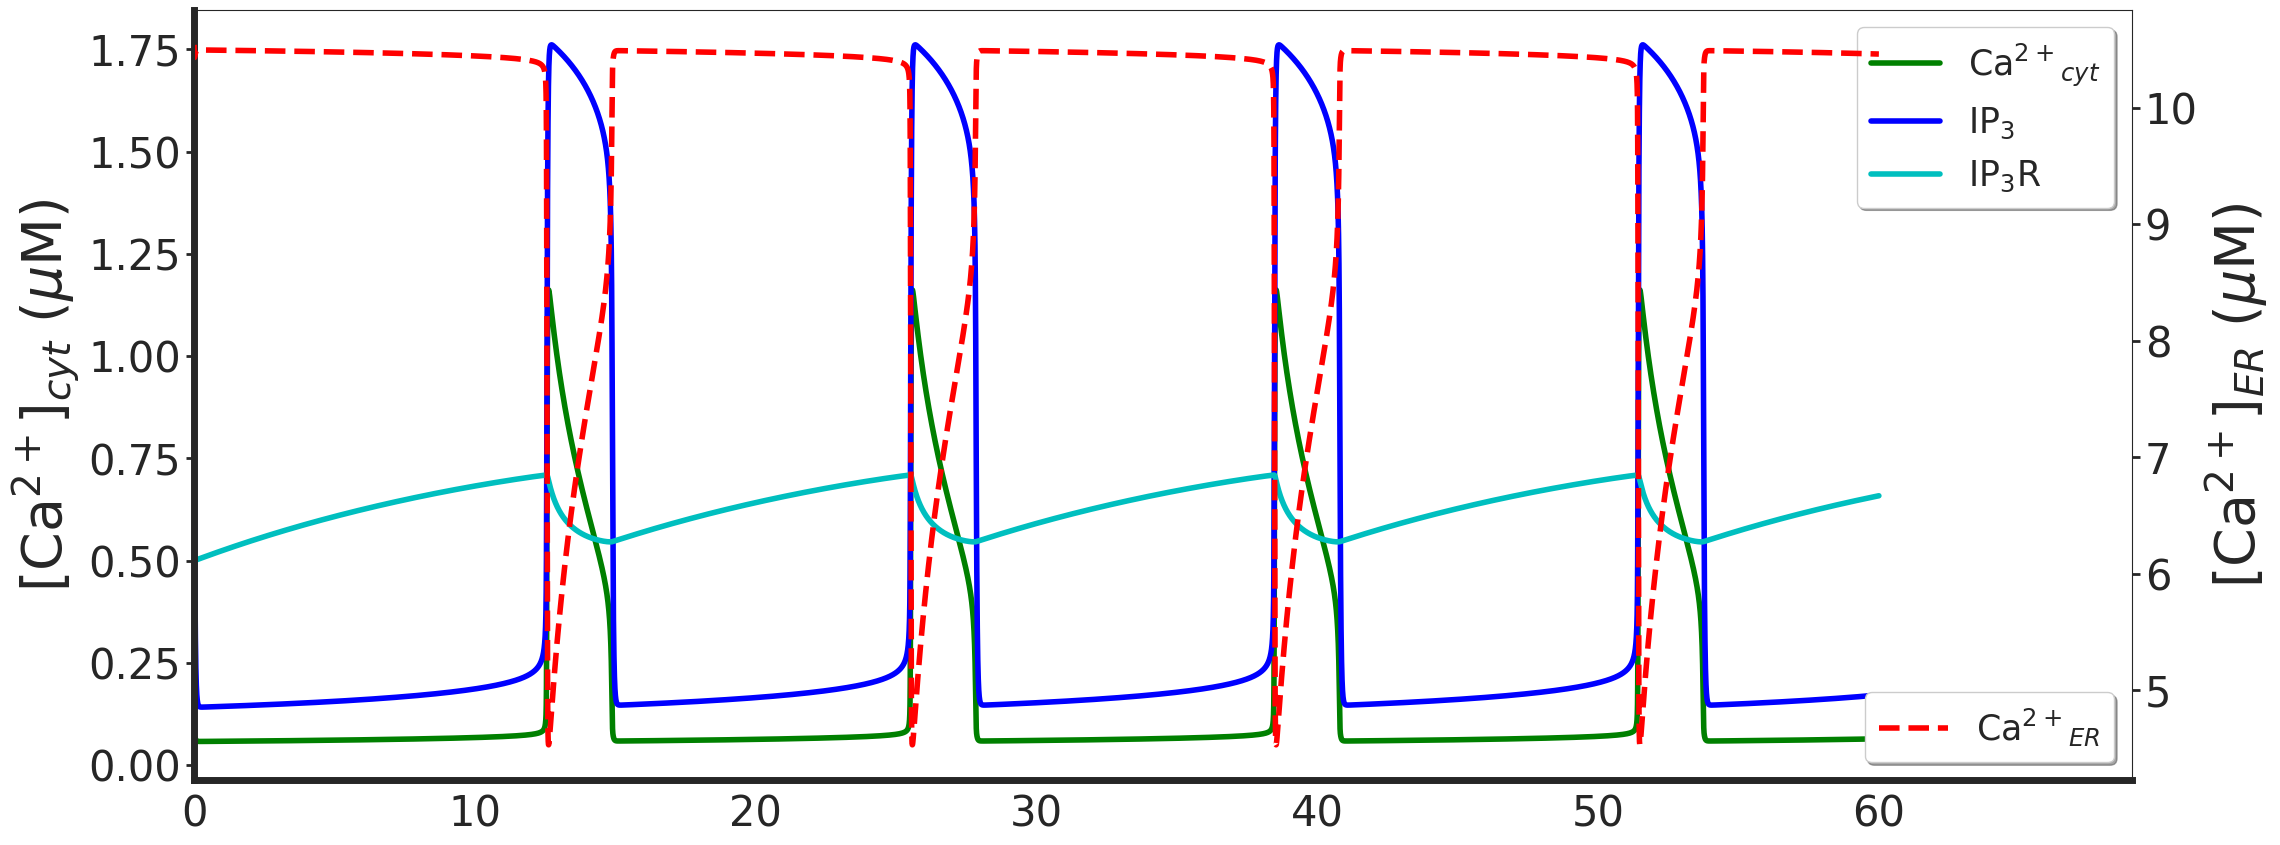

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax1 = ax.twinx()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    ax.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax1.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax1.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax.tick_params(axis='x', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='x', which='minor', labelsize=30, length=4, width=1)


    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)


    ax.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    ax.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    ax.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP$_{3}$R' )
    ax1.plot(time_vec/60,C_ER_vec,'-r',linestyle='dashed',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$]$_{cyt}$ ($\mu$M)',fontsize=40)
    ax1.set_ylabel(r'[Ca$^{2+}$]$_{ER}$ ($\mu$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax1.legend(loc=4, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

#VPLC = 1.6

Same equations as used in the previous block, only changing the value of VPLC. Refer to first block for detailed comments of the equations.

In [ ]:
def Ca_cyt_dot(Ca_cyt, IP3, IP3R,C_ER):
  k1 = 1.11
  k2 = 0.0203
  Ka = 0.08
  Kp = 0.13
  k3= 0.4
  k3z = 0.0
  k5 = 0.66

  Kserca = 0.1
  Vserca = 0.9
  # no need to solve Calcium in reticulum with an ODE because total Calcium is constant so
  Ctot = 2.0
  beta = 0.185
  #Ca_R = (Ctot-Ca_cyt)/beta we don't need this anymore since we have the actual calcium in reticulum ode
  eps = 0.0
  v0 = 0.0008
  vpm = 0.0
  kpm = 0.01
  phi = 0.0
  vplc = 1.6
  return (k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt) - Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)+eps*(v0+(phi*vplc)/((k3z+k5))-(vpm*Ca_cyt**2/(kpm**2+Ca_cyt**2))) #added in the calcium in the reticulum

def IP3R_dot(Ca_cyt, IP3, IP3R):
  tau_max = 1000 #add tau_new_max and rewrite
  k_tau = 1 #is like vplc and has range from 0.5 to 1.2 but we can only change one (either vplc or ktau)
  tau_new_update = tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4)
  ki = 0.4
  return (1.0/tau_new_update)*(1-IP3R*(ki+Ca_cyt)/ki)

def IP3_dot(Ca_cyt, IP3, IP3R):
  k5 = 0.66 # parameter
  k3 = 0.4
  k3z= 0.0
  VPLC = 1.6 # paramter (is from .1-1.5 micromoles)
  K_PLC = 0.2 # parameter
  tau_p = 1
  vplc = (VPLC*Ca_cyt**2/(K_PLC**2+Ca_cyt**2))
  vdeg = (k5+(k3z*Ca_cyt**2/(k3**2+Ca_cyt**2)))*IP3
  return tau_p * (vplc - vdeg)
def C_ER_dot(Ca_cyt, IP3, IP3R, C_ER):
  beta = 0.185
  Kserca = 0.1
  Vserca = 0.9
  k1 = 1.11
  Ka = 0.08
  Kp = 0.13
  k2 = 0.0203
  Ctot = 2.0
  Ca_R = (Ctot-Ca_cyt)/beta
  return (1.0/beta)*((((Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)))-(k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt)))




In [ ]:
dt = 0.01 #s
t_final = 3600 # s
n_steps = int(t_final/dt)
# create arrays to store solution
Ca_cyt_vec = np.zeros((n_steps))
IP3_vec = np.zeros((n_steps))
C_ER_vec = np.zeros((n_steps))
IP3R_vec = np.zeros((n_steps))
time_vec = np.zeros((n_steps))
# Initial conditions
Ca_cyt_vec[0] = .05
IP3_vec[0] = 1
C_ER_vec[0] = (2.0 - .05)/0.185
IP3R_vec[0] = 0.5

for i in range(n_steps-1):
  Ca_cyt_vec[i+1] = Ca_cyt_vec[i]+dt*Ca_cyt_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3_vec[i+1] = IP3_vec[i]+dt*IP3_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  C_ER_vec[i+1] = C_ER_vec[i]+dt*C_ER_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3R_vec[i+1] = IP3R_vec[i]+dt*IP3R_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  time_vec[i+1] = time_vec[i]+dt

Plots with VPLC values of 1.6

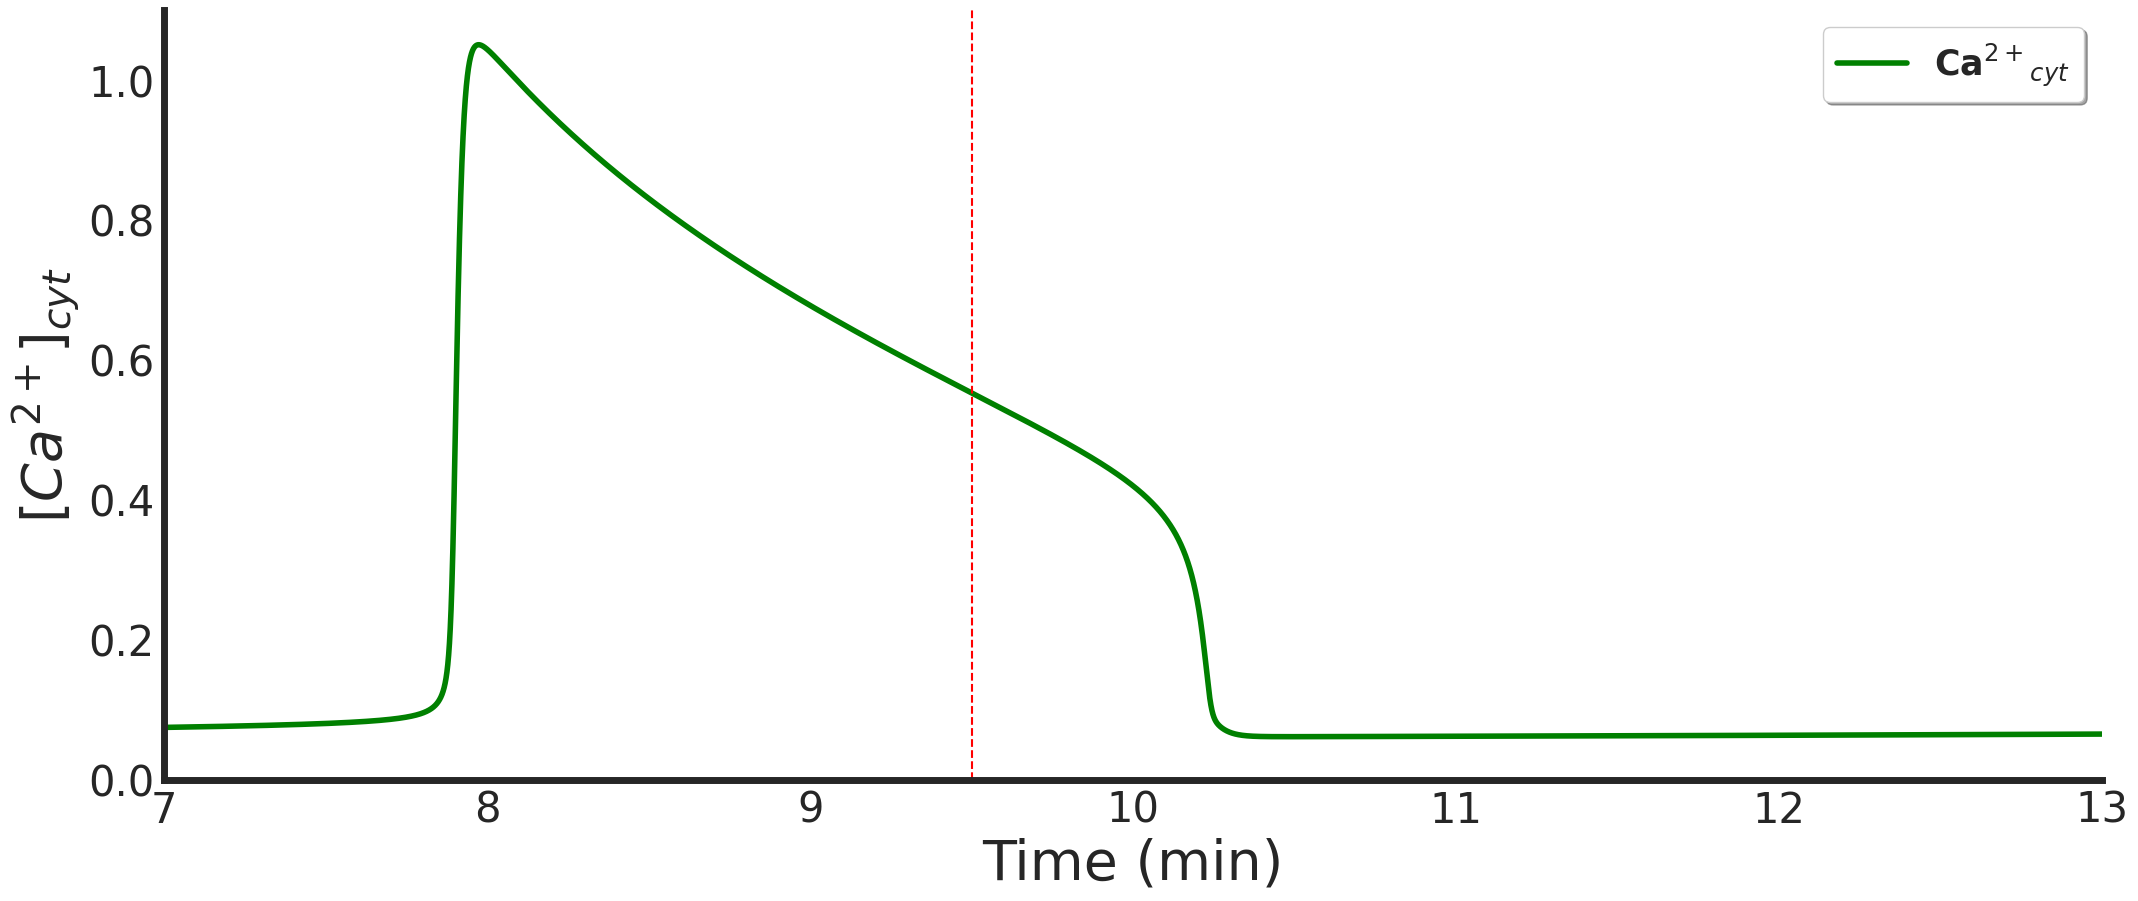

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )

    #plt.axvline(x=8-.025, color='r', linestyle='--')
    plt.axvline(x=9.5, color='r', linestyle='--')

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[$Ca^{2+}$]$_{cyt}$',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([7,13])

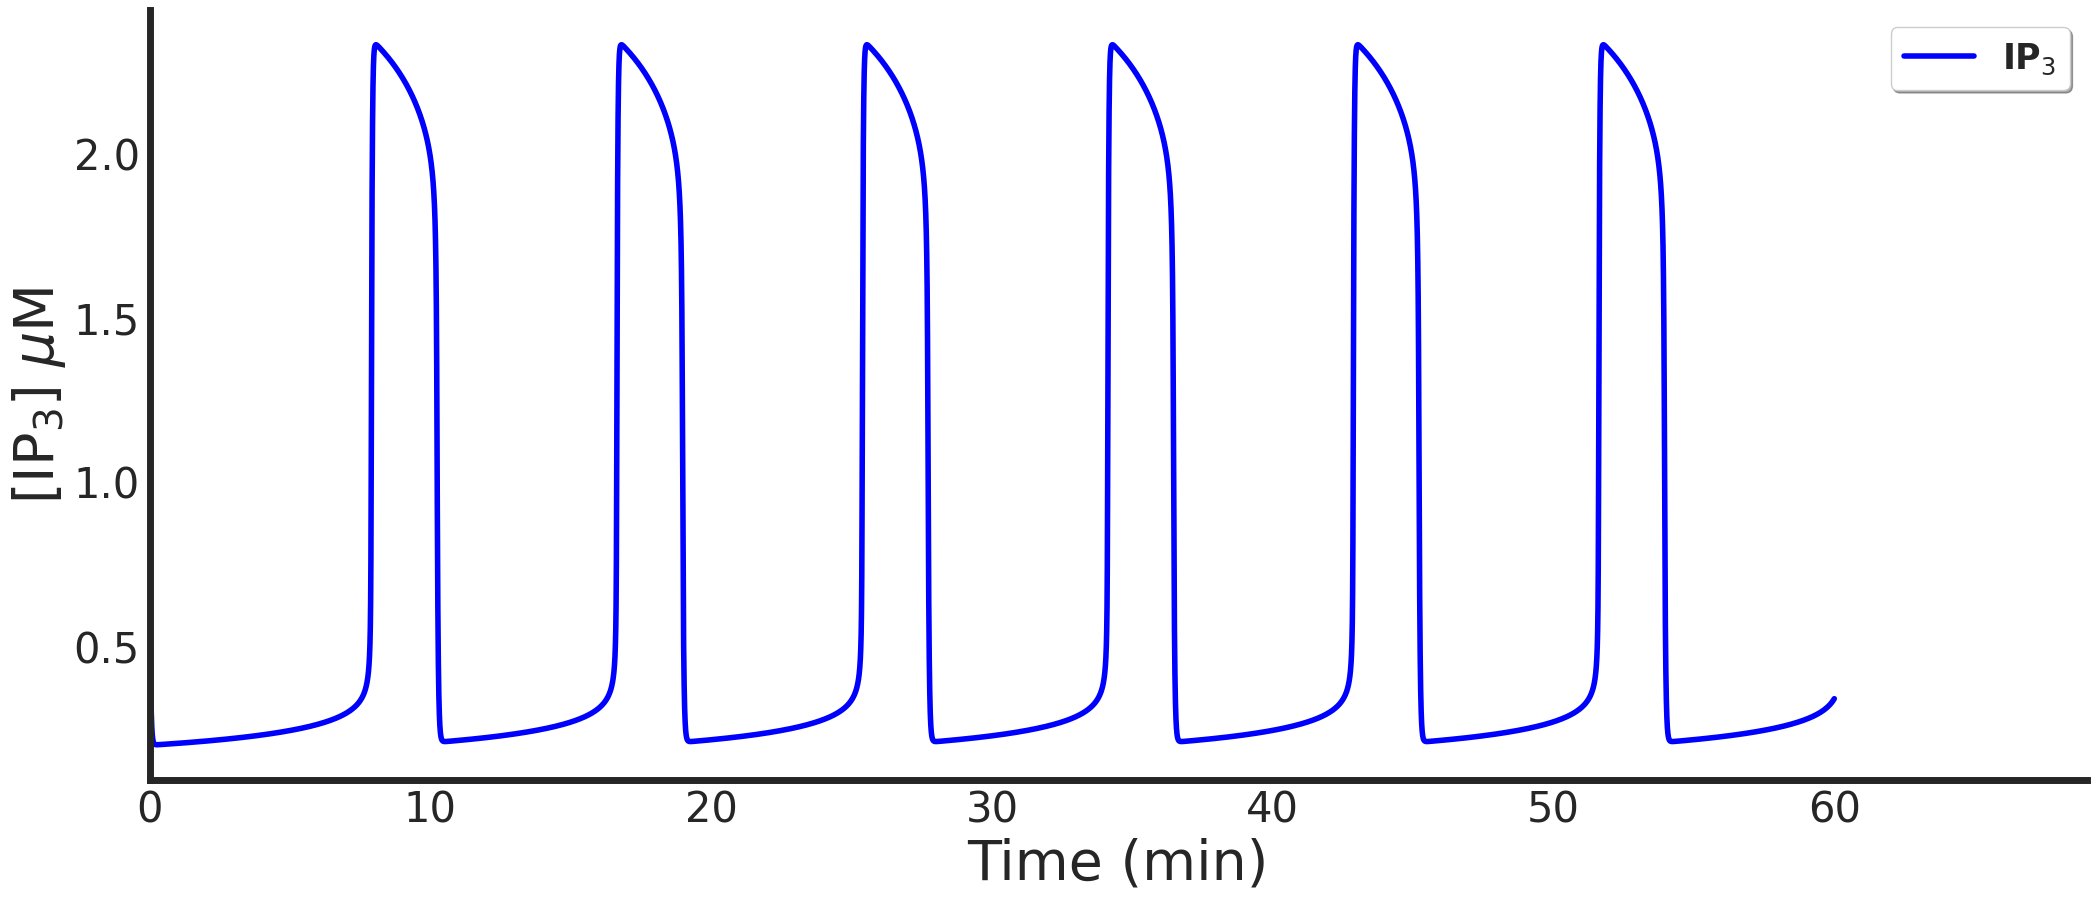

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

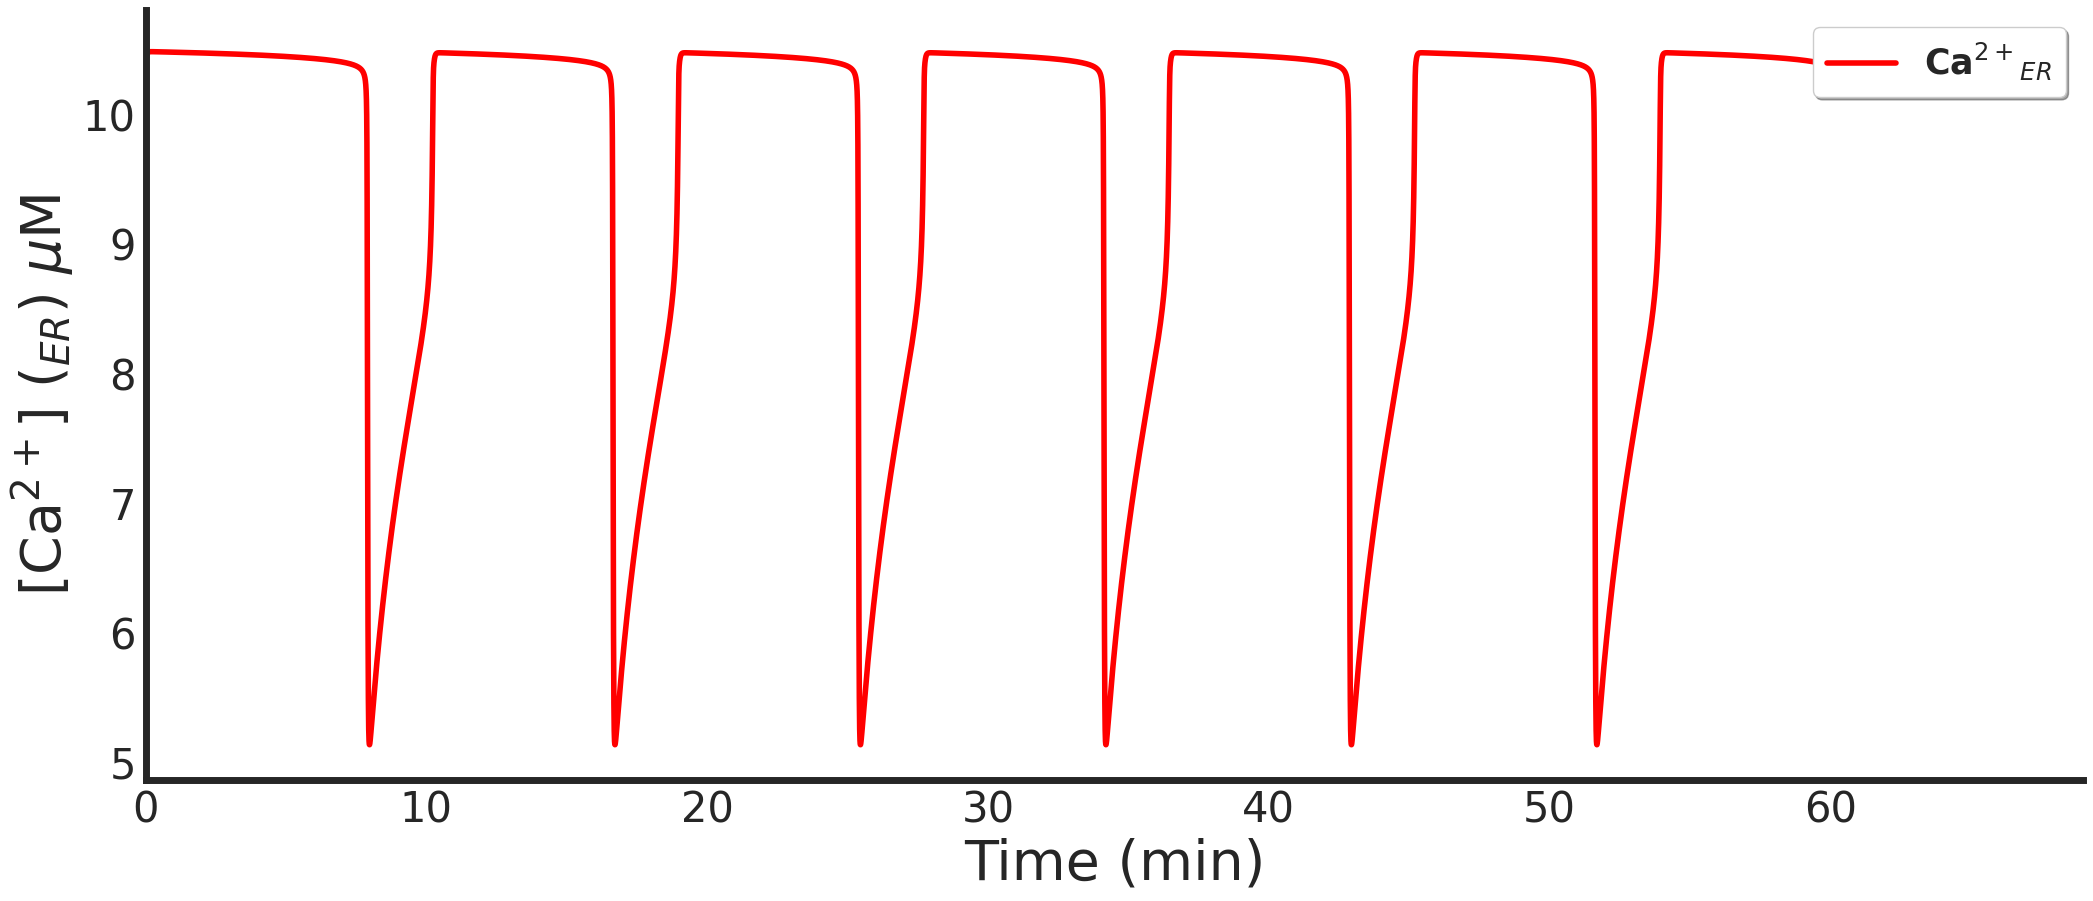

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$] ($_{ER}$) $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

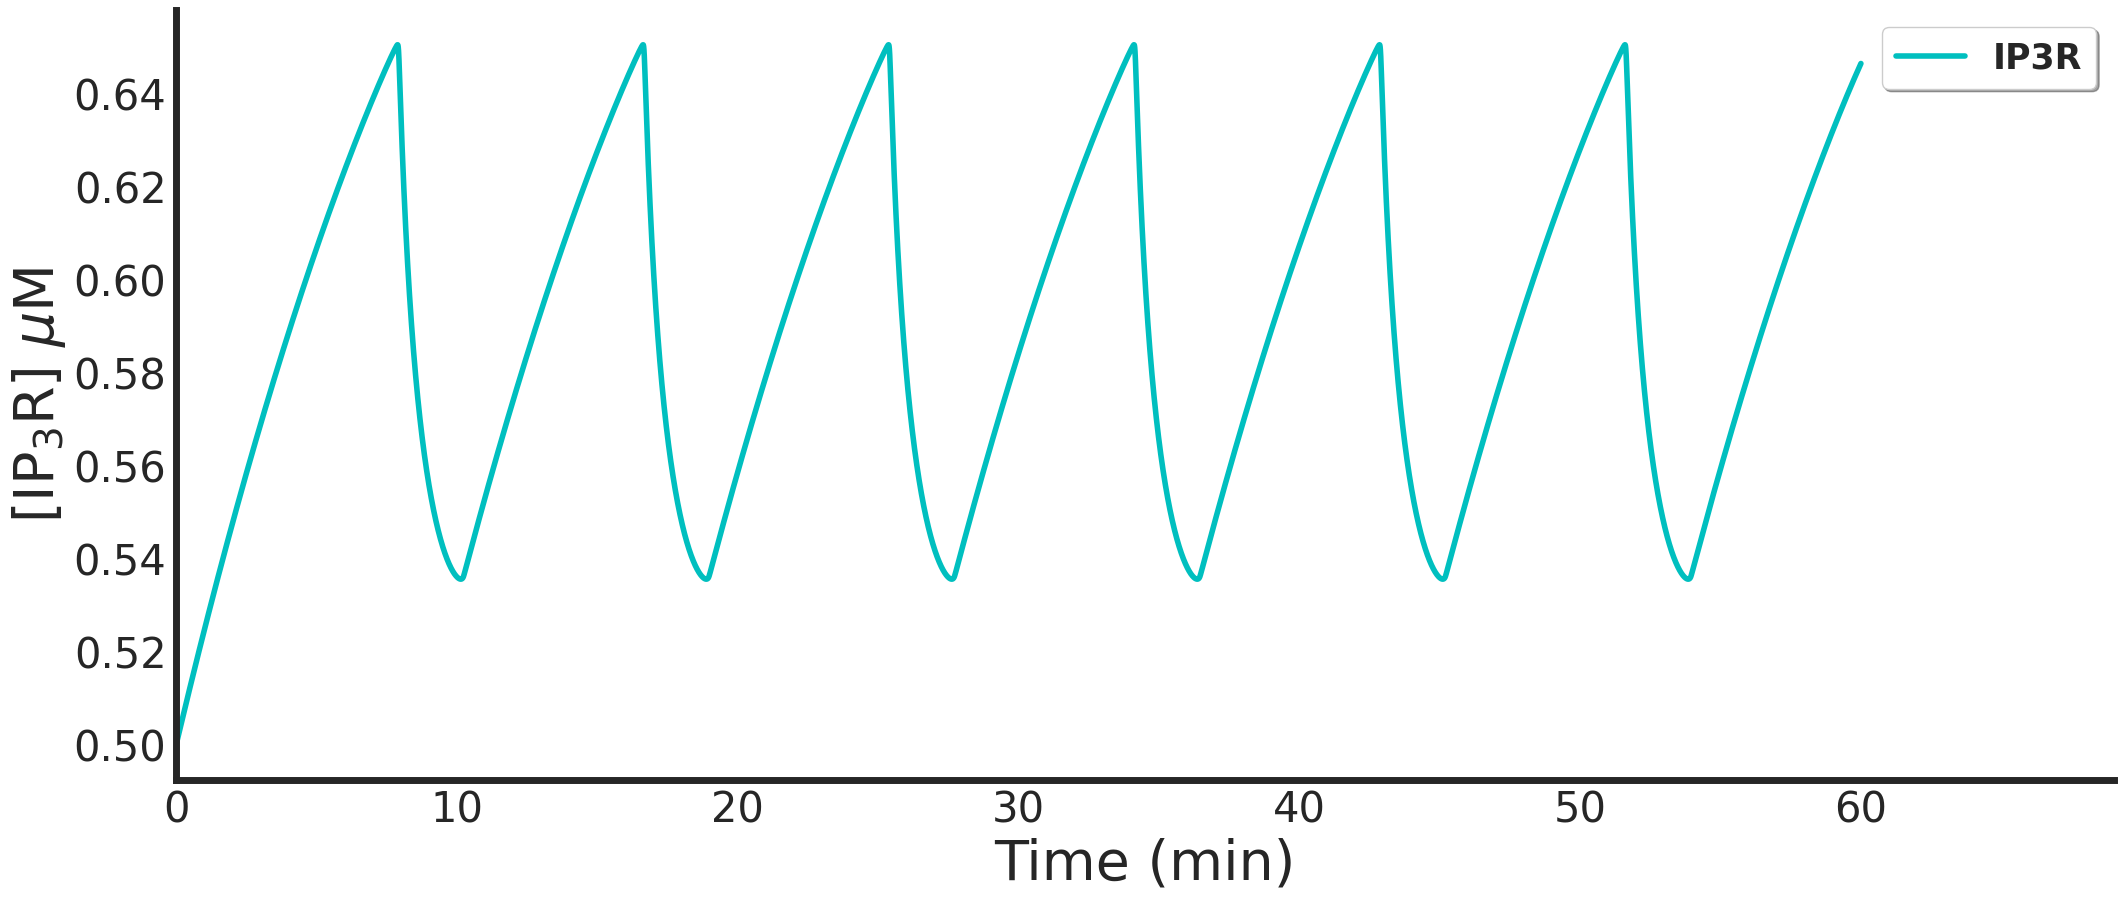

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$R] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

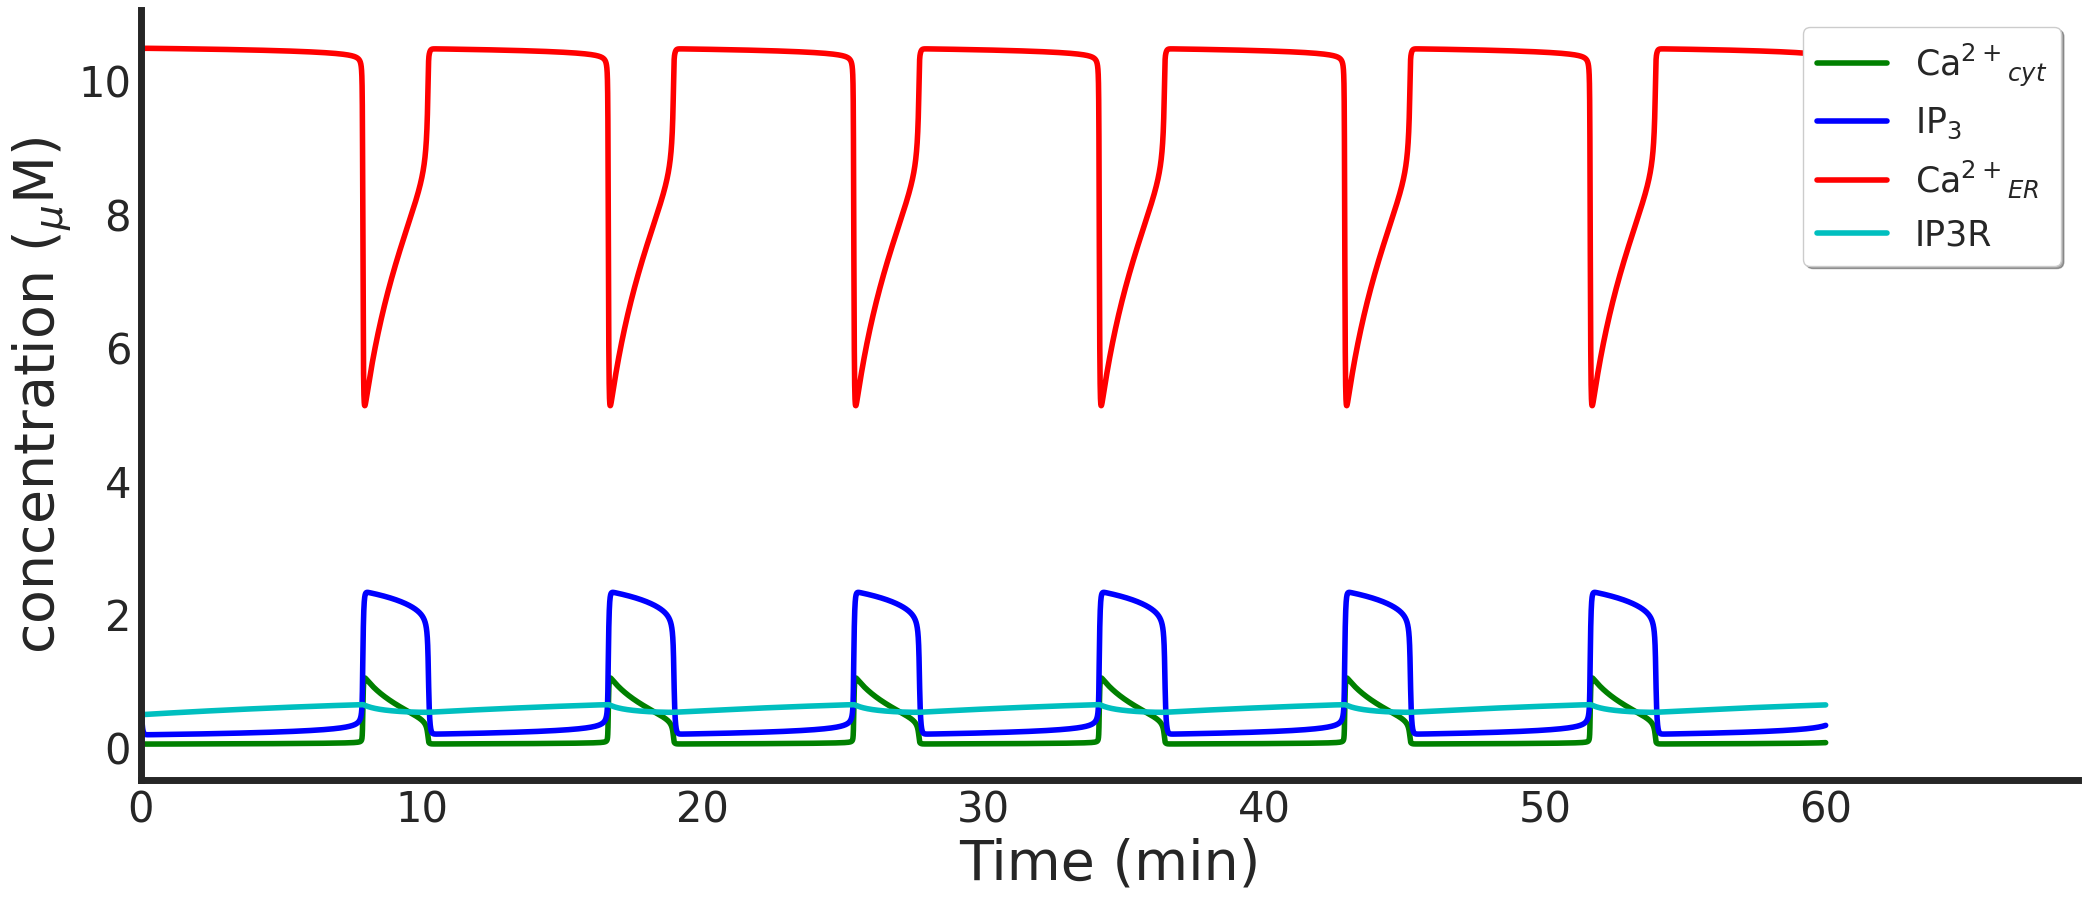

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

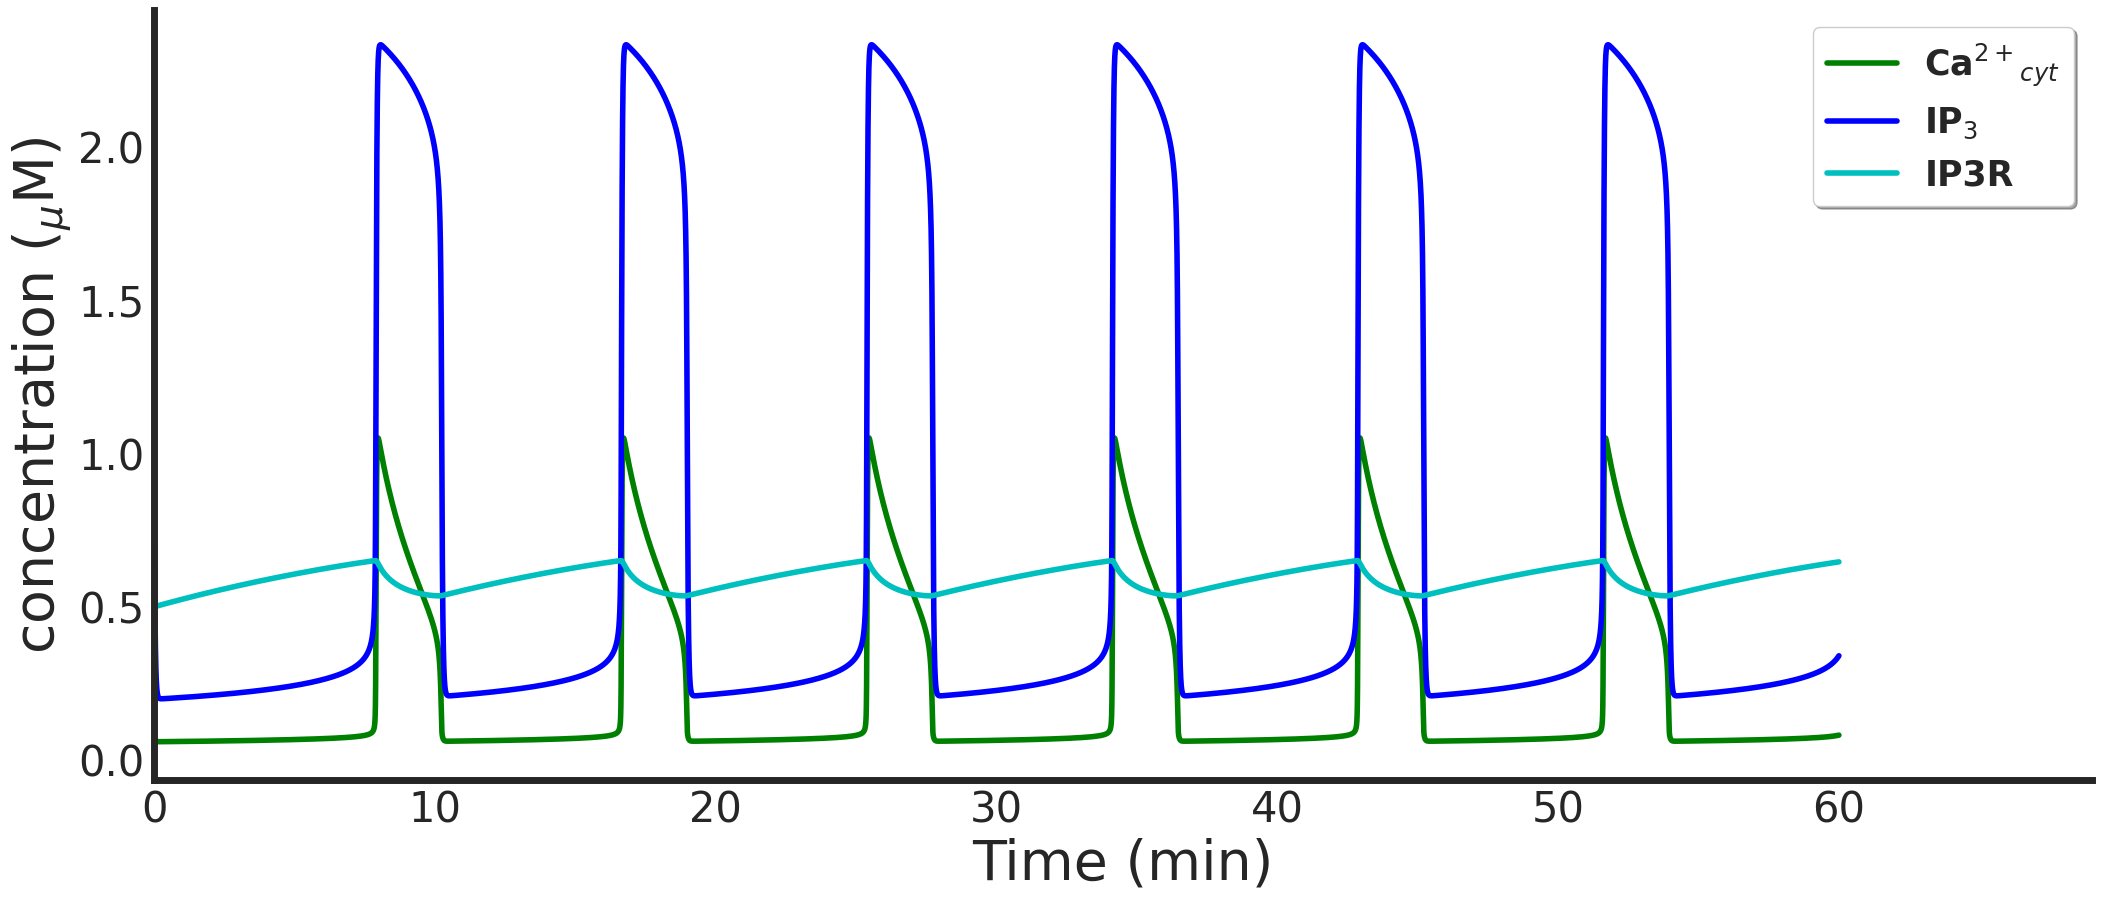

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

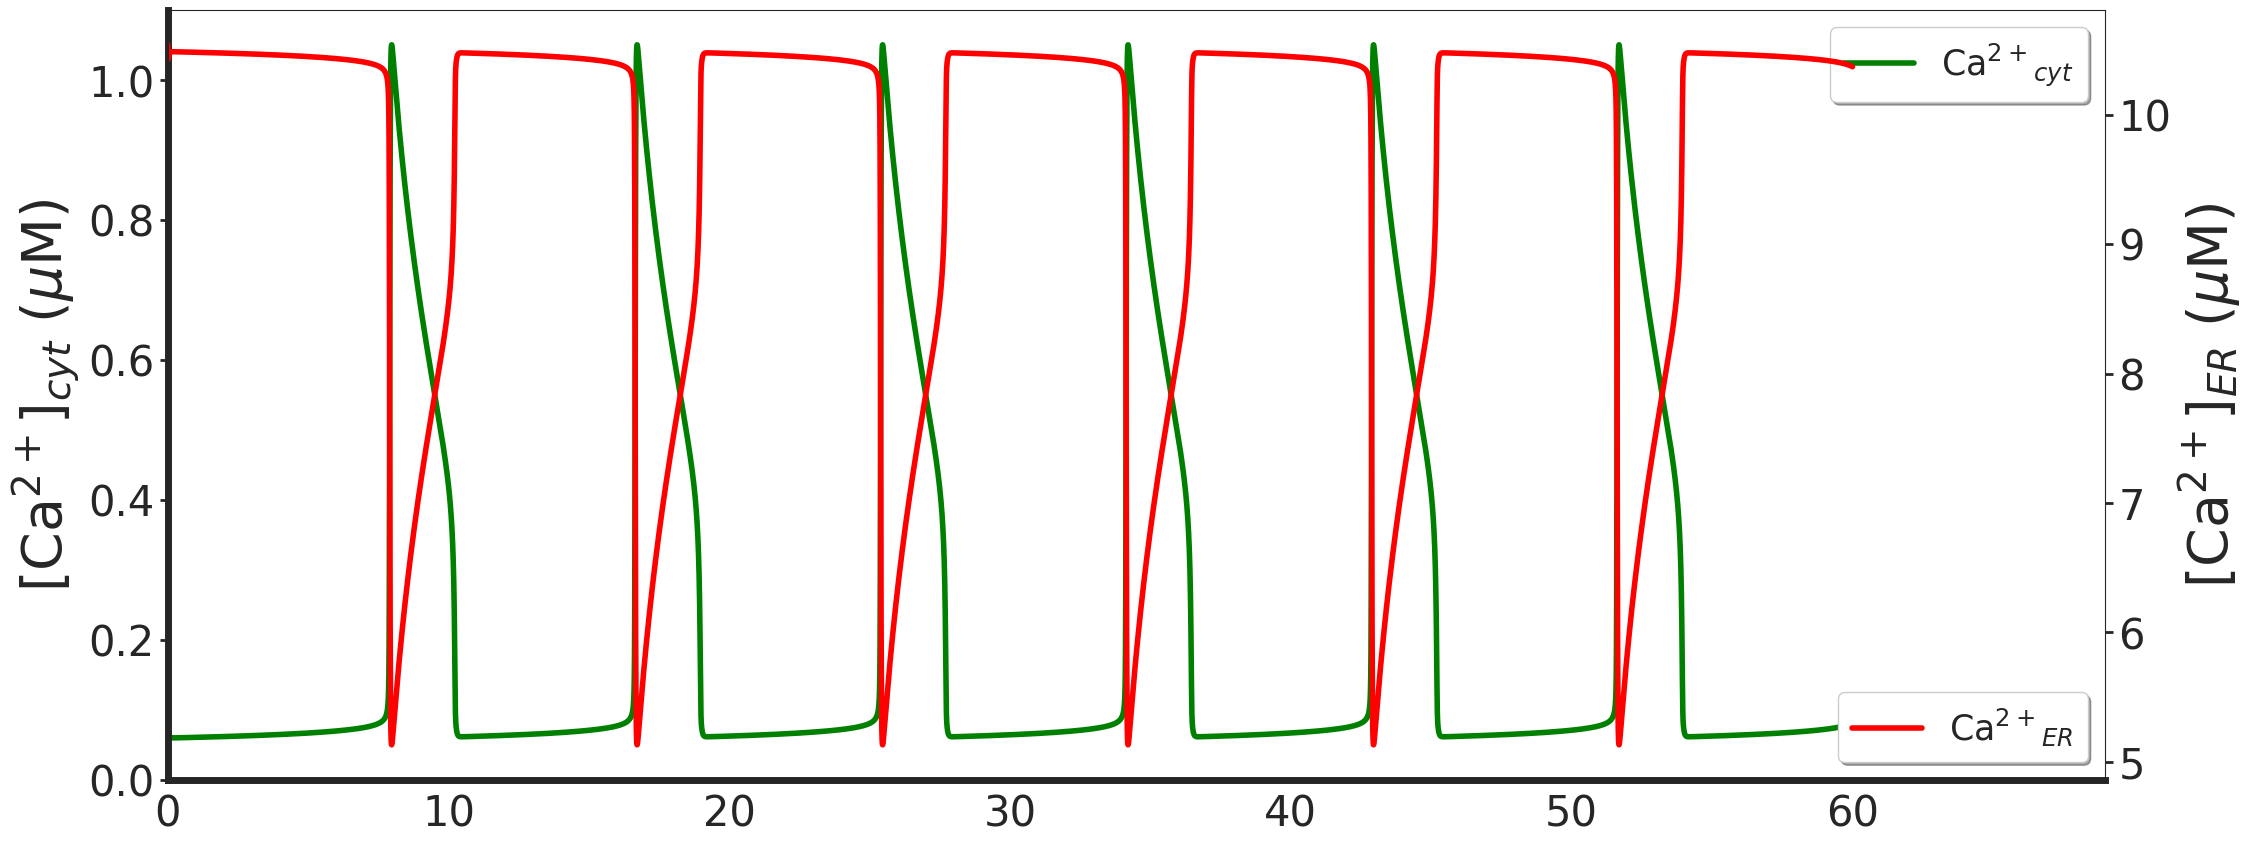

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax1 = ax.twinx()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    ax.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax1.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax1.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax.tick_params(axis='x', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='x', which='minor', labelsize=30, length=4, width=1)


    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)


    ax.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    ax1.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$]$_{cyt}$ ($\mu$M)',fontsize=40)
    ax1.set_ylabel(r'[Ca$^{2+}$]$_{ER}$ ($\mu$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax1.legend(loc=4, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

# Phase Portraits

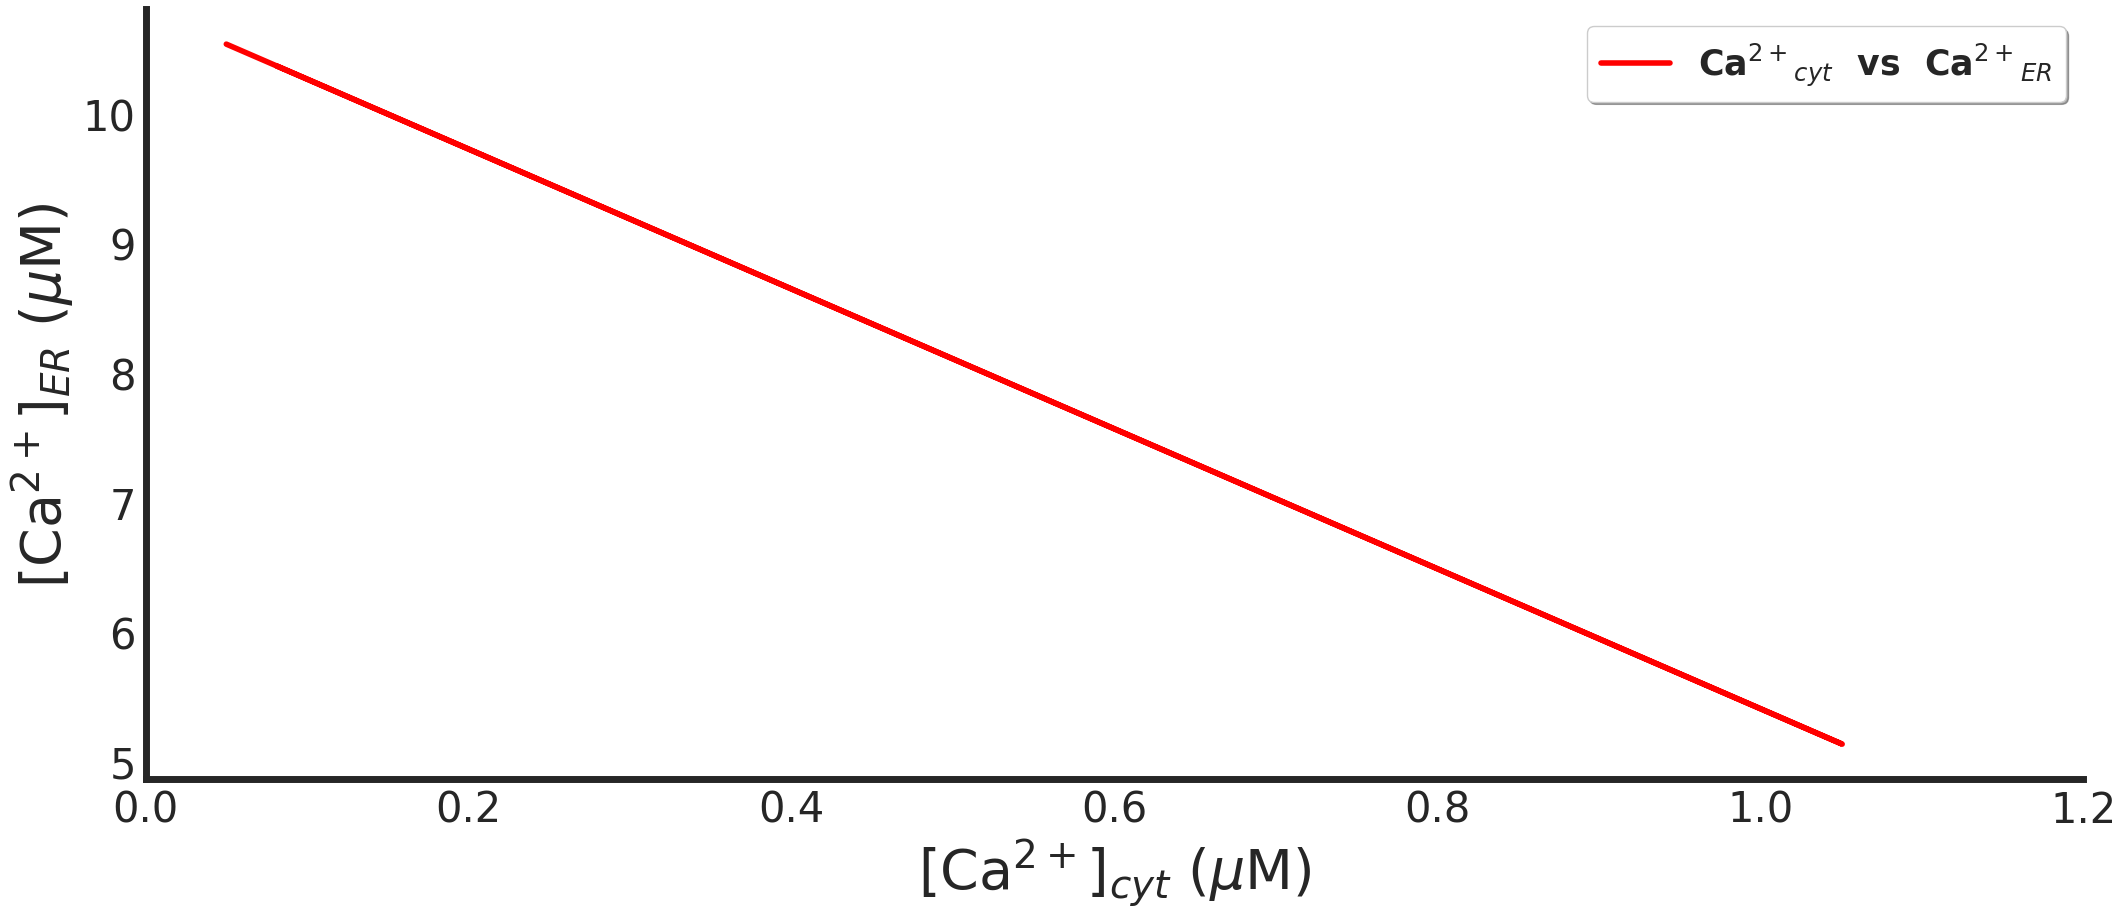

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(Ca_cyt_vec,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$  vs  Ca$^{2+}$$_{ER}$' )

    plt.xlabel('[Ca$^{2+}$]$_{cyt}$ ($\mu$M)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$]$_{ER}$ ($\mu$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,1.2])

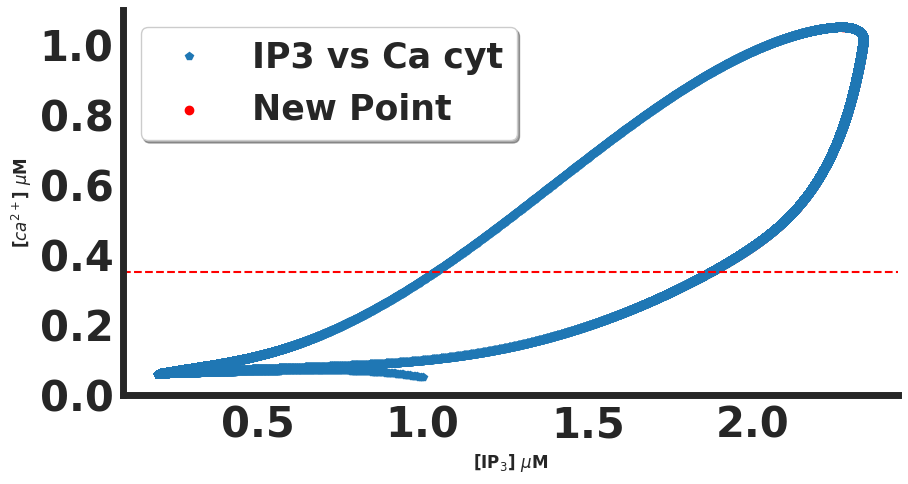

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(10,5))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30,fontweight='bold')
    plt.xticks(fontsize=30,fontweight='bold')
    #plt.plot(Ca_cyt_vec,IP3R_vec,'p',linewidth=4,label=r'Ca cyt vs IP3R' )
    plt.plot(IP3_vec,Ca_cyt_vec,'p',linewidth=0.5,label=r'IP3 vs Ca cyt' )

    plt.axhline(y=0.35, color='r', linestyle='--')
    new_x= 2.272
    new_y= 1.051
    plt.scatter(new_x, new_y, color='red', label='New Point')


    plt.xlabel('[IP$_{3}$] $\mu$M',fontsize=12,fontweight='bold')
    ax.set_ylabel('[$ca^{2+}$] $\mu$M',fontsize=12,fontweight='bold')
    ax.legend(loc='best', shadow=True, prop=legend_properties)
    #ax.set_xlim([0,1.2])

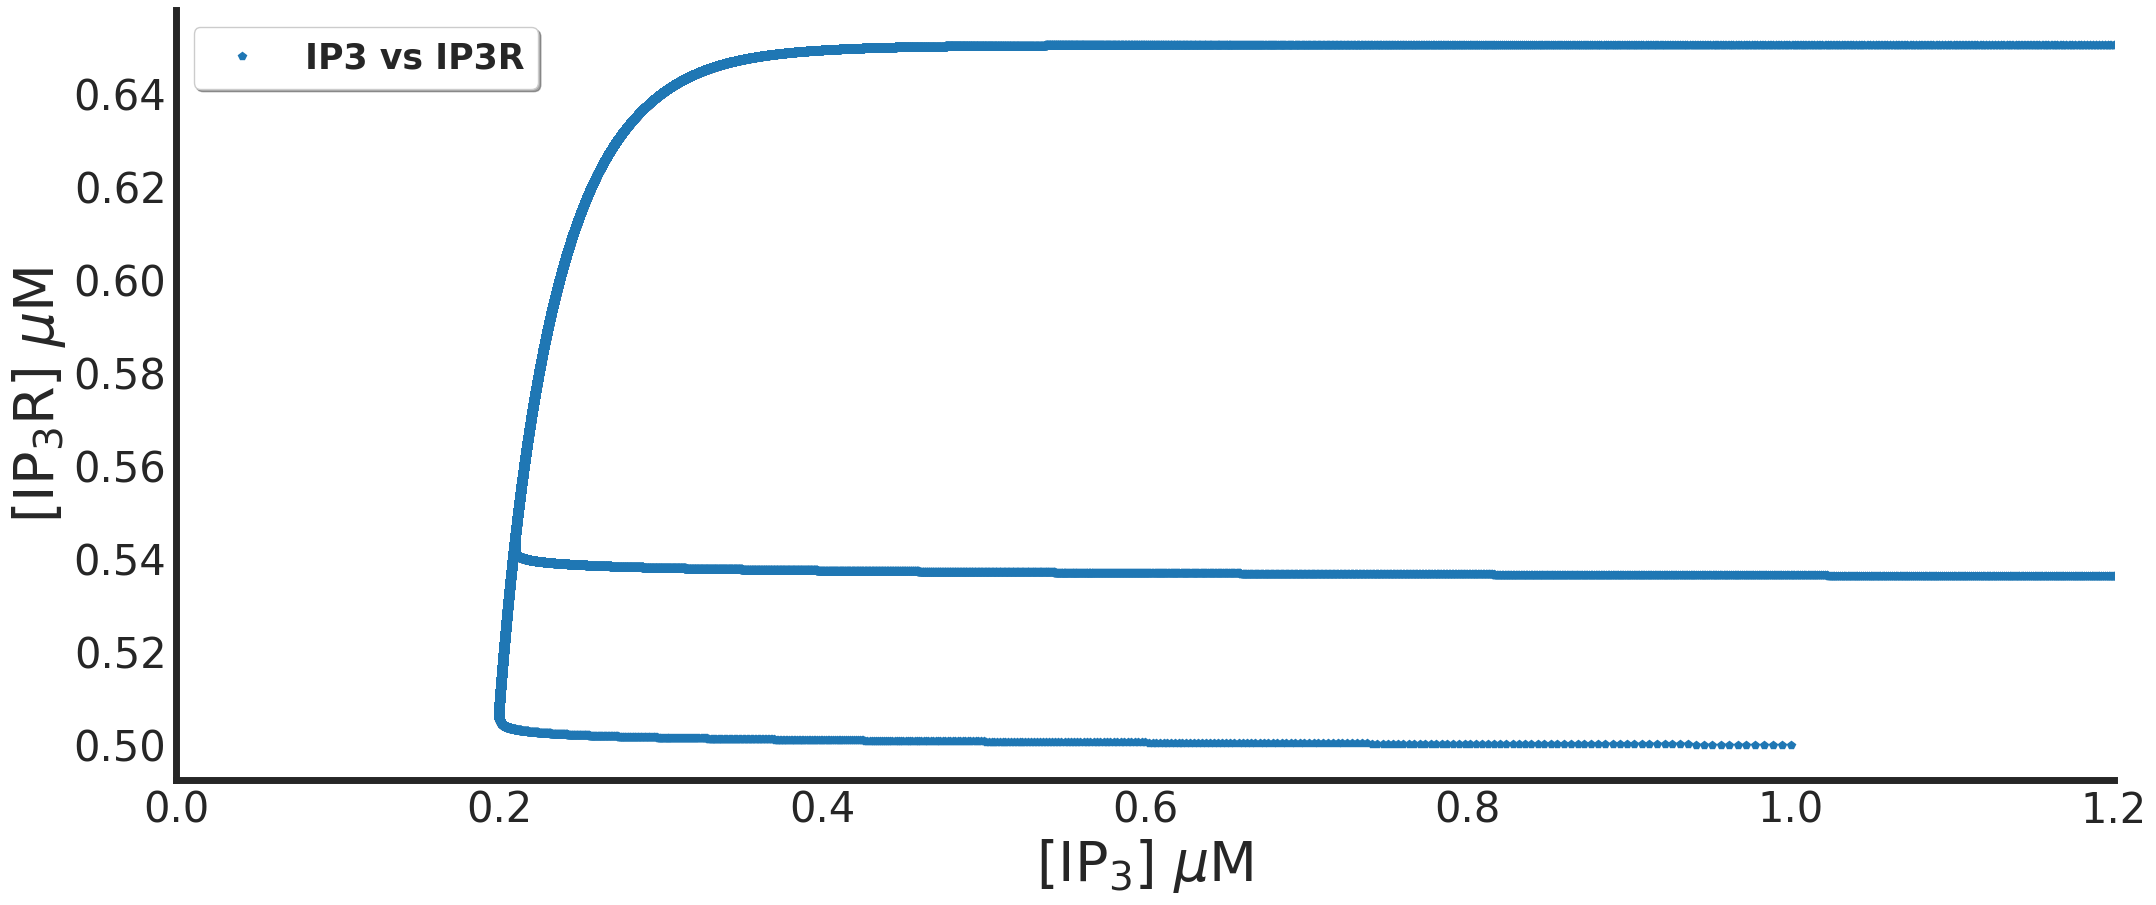

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(IP3_vec,IP3R_vec,'p',linewidth=4,label=r'IP3 vs IP3R' )

    plt.xlabel('[IP$_{3}$] $\mu$M',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$R] $\mu$M',fontsize=40)
    ax.legend(loc=2, shadow=True, prop=legend_properties)
    ax.set_xlim([0,1.2])

In [ ]:
def IP3R_dot0(Ca_cyt):
  tau_max = 1000 #add tau_new_max and rewrite
  k_tau = 1 #is like vplc and has range from 0.5 to 1.2 but we can only change one (either vplc or ktau)
  tau_new_update = tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4)
  ki = 0.4
  return ki / (ki + Ca_cyt)

In [ ]:
Ip3_vec=np.linspace(0,2.5,50)
Calc_vec= np.linspace(0,1.2,50)
Ip3mg,calciummg=np.meshgrid(Ip3_vec,Calc_vec)
Ip3dotmg= IP3_dot(calciummg, Ip3mg, 0.7)
calciumdotmg = Ca_cyt_dot(calciummg, Ip3mg, 0.7,(2-calciummg)/.185)
#IP3R_dot0(calciummg)

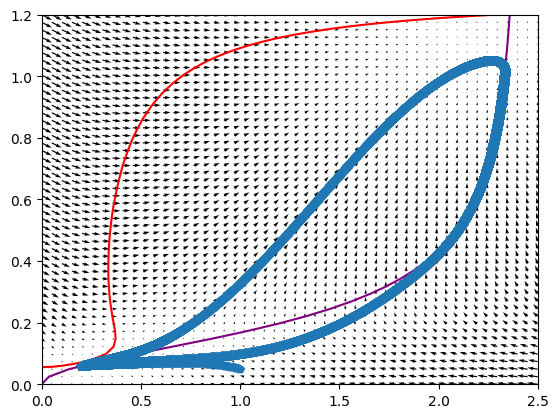

In [ ]:
plt.quiver(Ip3mg,calciummg,Ip3dotmg,calciumdotmg)
plt.contour(Ip3mg,calciummg,Ip3dotmg,levels=[0],colors=['purple'])
plt.contour(Ip3mg,calciummg,calciumdotmg,levels=[0],colors=['red'])

plt.plot(IP3_vec,Ca_cyt_vec,'p',linewidth=4,label=r'Ca cyt vs IP3R' )
#plt.xlim([0,1])
#plt.ylim([0,0.5])

#Varying K_Tau#

Same equations,inputs, outputs, and parameter values used in the previous blocks (refer back to the first block for specific detailed comments for these). Code will have a stagnant VPLC value of 1.2 and have varying K_Tau values instead of varying VPLC.

#K_Tau = 0.5#

In [ ]:
def Ca_cyt_dot(Ca_cyt, IP3, IP3R,C_ER):
  k1 = 1.11
  k2 = 0.0203
  Ka = 0.08
  Kp = 0.13
  k3= 0.4
  k3z = 0.0
  k5 = 0.66

  Kserca = 0.1
  Vserca = 0.9
  # no need to solve Calcium in reticulum with an ODE because total Calcium is constant so
  Ctot = 2.0
  beta = 0.185
  #Ca_R = (Ctot-Ca_cyt)/beta we don't need this anymore since we have the actual calcium in reticulum ode
  eps = 0.0
  v0 = 0.0008
  vpm = 0.0
  kpm = 0.01
  phi = 0.0
  vplc = 1.2
  return (k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt) - Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)+eps*(v0+(phi*vplc)/((k3z+k5))-(vpm*Ca_cyt**2/(kpm**2+Ca_cyt**2))) #added in the calcium in the reticulum


def IP3R_dot(Ca_cyt, IP3, IP3R):
  tau_max = 1000 #add tau_new_max and rewrite
  k_tau = 0.5 #is like vplc and has range from 0.5 to 1.2 but we can only change one (either vplc or ktau)
  tau_new_update = tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4)
  ki = 0.4
  return (1.0/tau_new_update)*(1-IP3R*(ki+Ca_cyt)/ki)


## This is the only equation which K_Tau varies
def IP3_dot(Ca_cyt, IP3, IP3R):
  k5 = 0.66 # parameter
  k3 = 0.4
  k3z= 0.0
  VPLC = 1.2 # paramter (is from .1-1.5 micromoles)
  K_PLC = 0.2 # parameter
  tau_p = 1
  vplc = (VPLC*Ca_cyt**2/(K_PLC**2+Ca_cyt**2))
  vdeg = (k5+(k3z*Ca_cyt**2/(k3**2+Ca_cyt**2)))*IP3
  return tau_p * (vplc - vdeg)


def C_ER_dot(Ca_cyt, IP3, IP3R, C_ER):
  beta = 0.185
  Kserca = 0.1
  Vserca = 0.9
  k1 = 1.11
  Ka = 0.08
  Kp = 0.13
  k2 = 0.0203
  Ctot = 2.0
  Ca_R = (Ctot-Ca_cyt)/beta
  return (1.0/beta)*((((Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)))-(k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt)))

In [ ]:
dt = 0.01 #s
t_final = 3600 # s
n_steps = int(t_final/dt)
# create arrays to store solution
Ca_cyt_vec = np.zeros((n_steps))
IP3_vec = np.zeros((n_steps))
C_ER_vec = np.zeros((n_steps))
IP3R_vec = np.zeros((n_steps))
time_vec = np.zeros((n_steps))
# Initial conditions
Ca_cyt_vec[0] = .05
IP3_vec[0] = 1
C_ER_vec[0] = (2.0 - .05)/0.185
IP3R_vec[0] = 0.5

for i in range(n_steps-1):
  Ca_cyt_vec[i+1] = Ca_cyt_vec[i]+dt*Ca_cyt_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3_vec[i+1] = IP3_vec[i]+dt*IP3_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  C_ER_vec[i+1] = C_ER_vec[i]+dt*C_ER_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3R_vec[i+1] = IP3R_vec[i]+dt*IP3R_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  time_vec[i+1] = time_vec[i]+dt

Plots with K_Tau value of 0.5

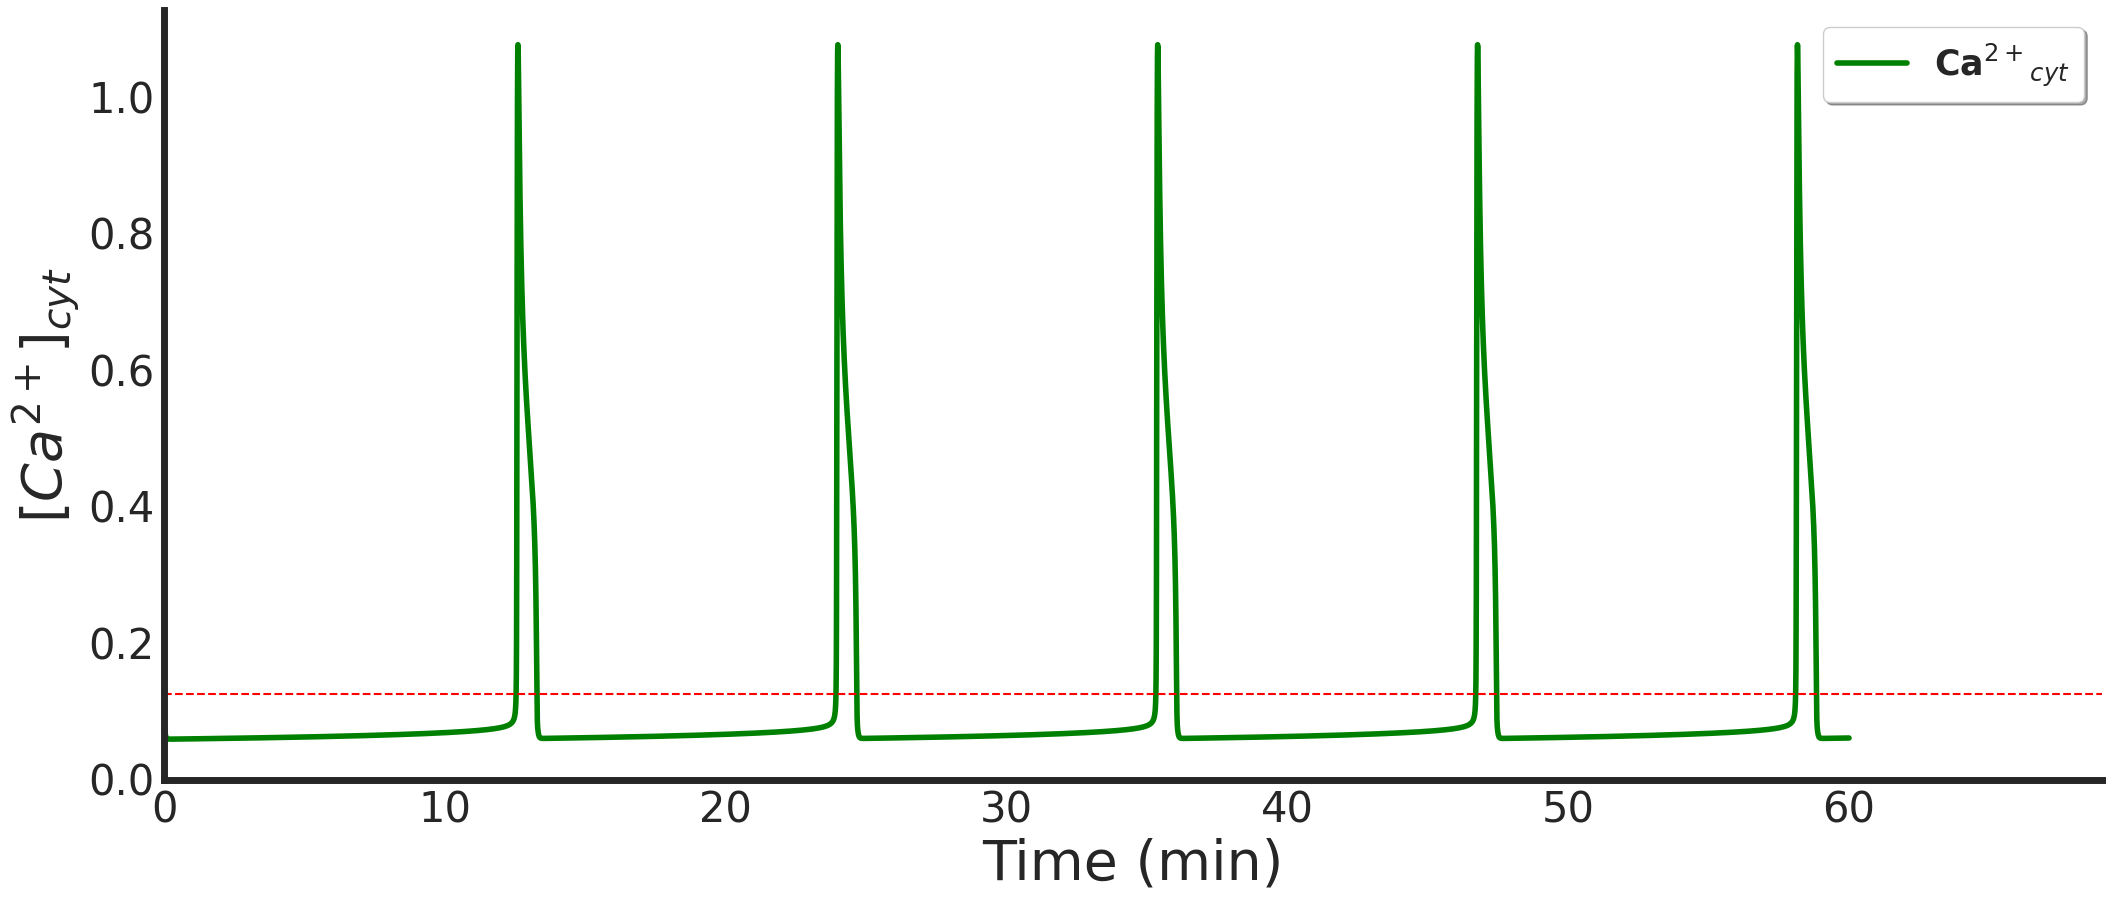

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.axhline(y=0.125, color='r', linestyle='--')


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[$Ca^{2+}$]$_{cyt}$',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

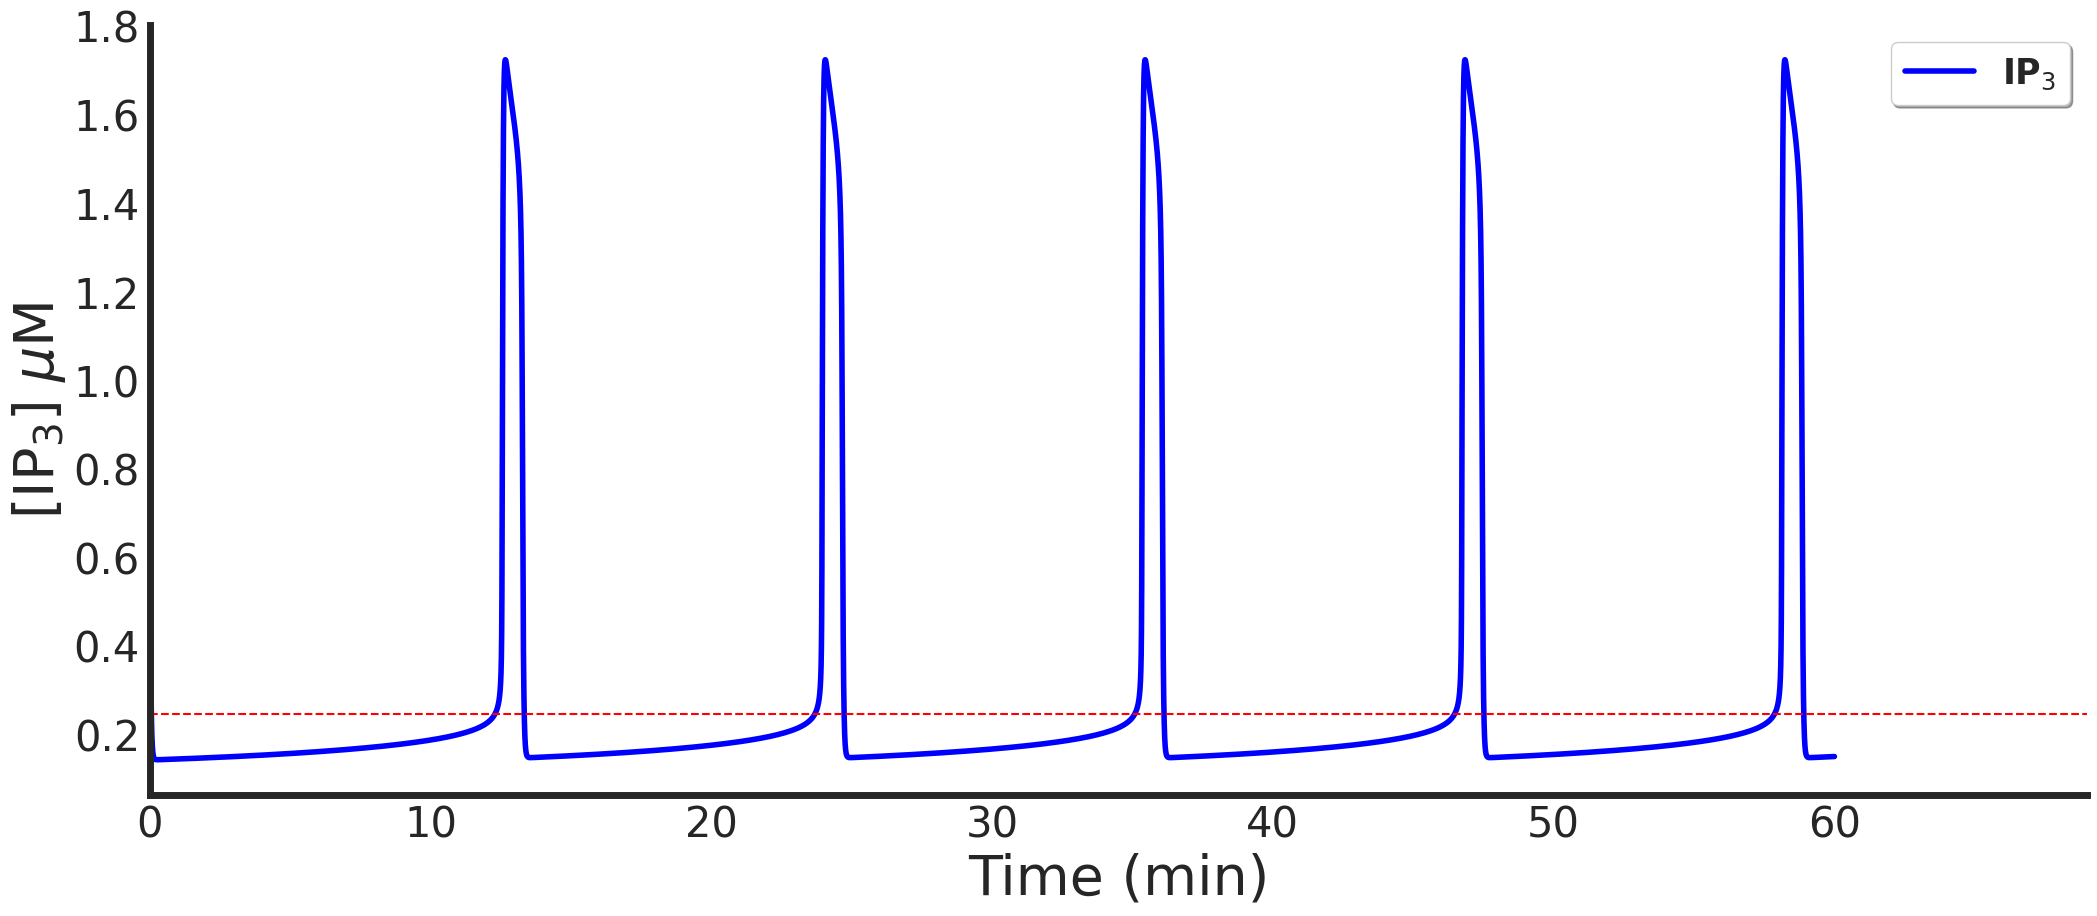

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.axhline(y=0.245, color='r', linestyle='--')

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

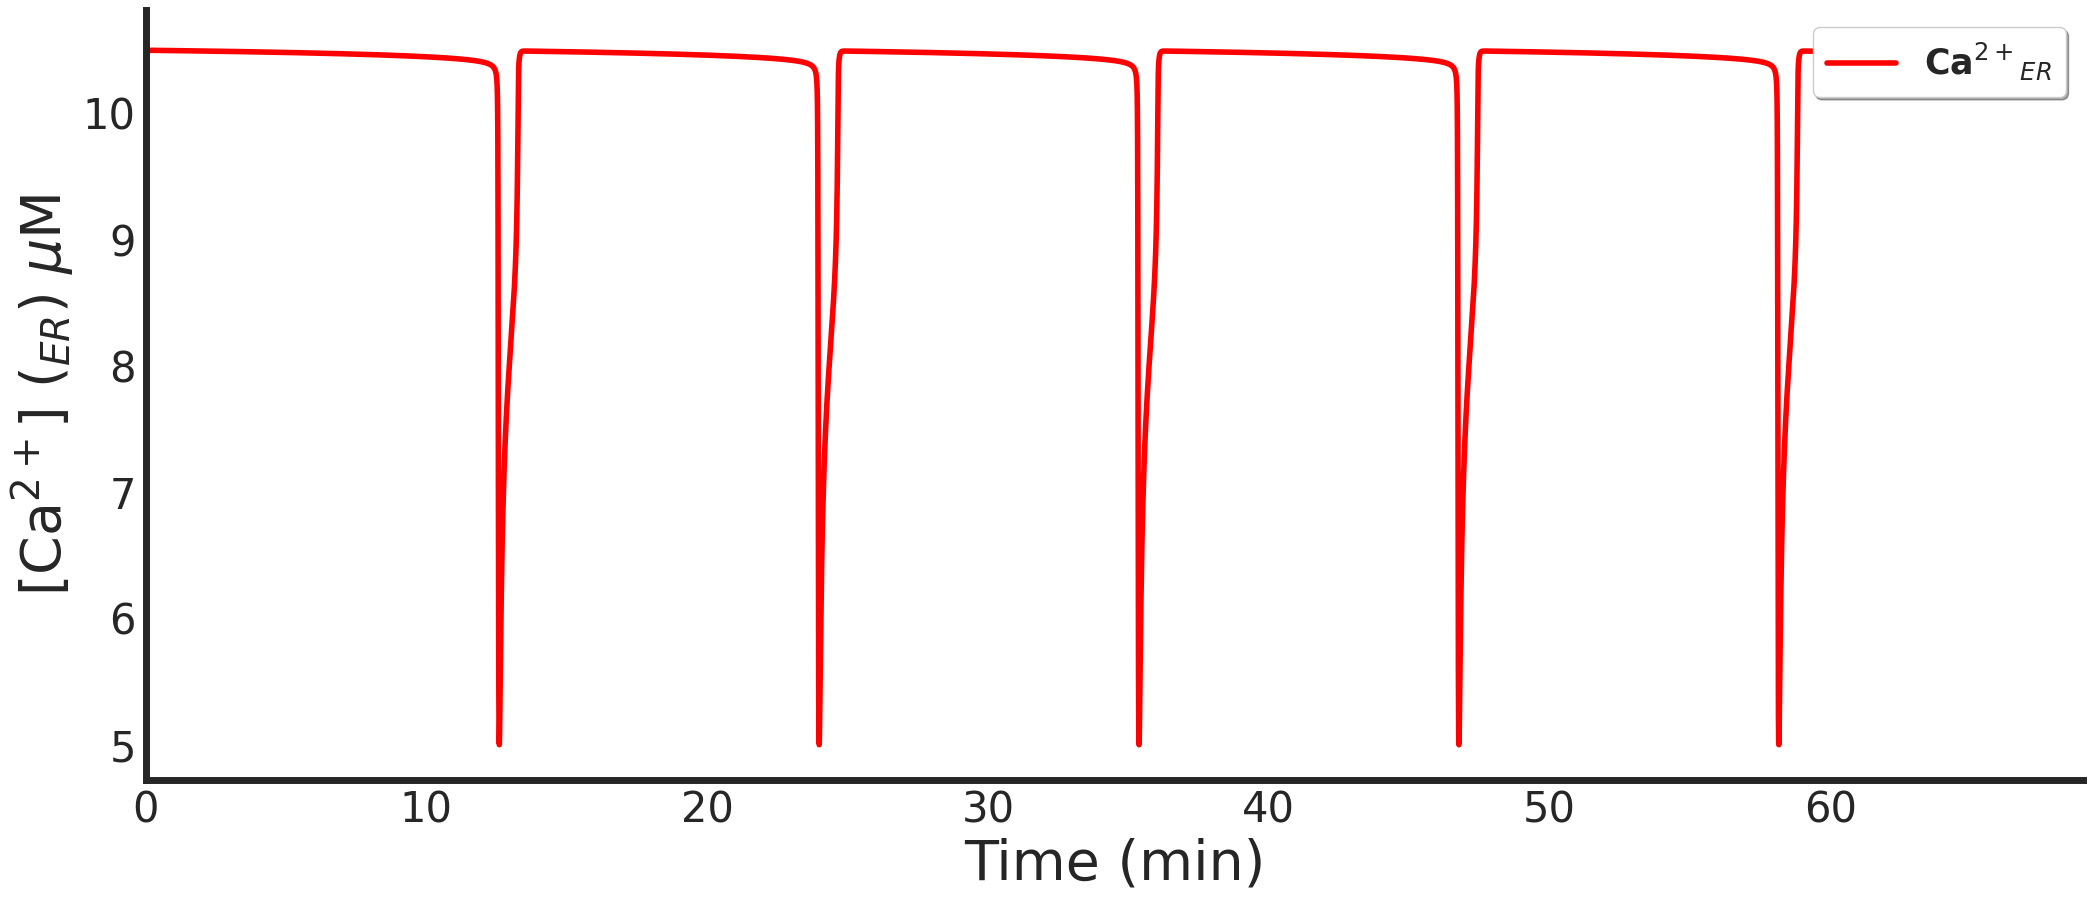

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$] ($_{ER}$) $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

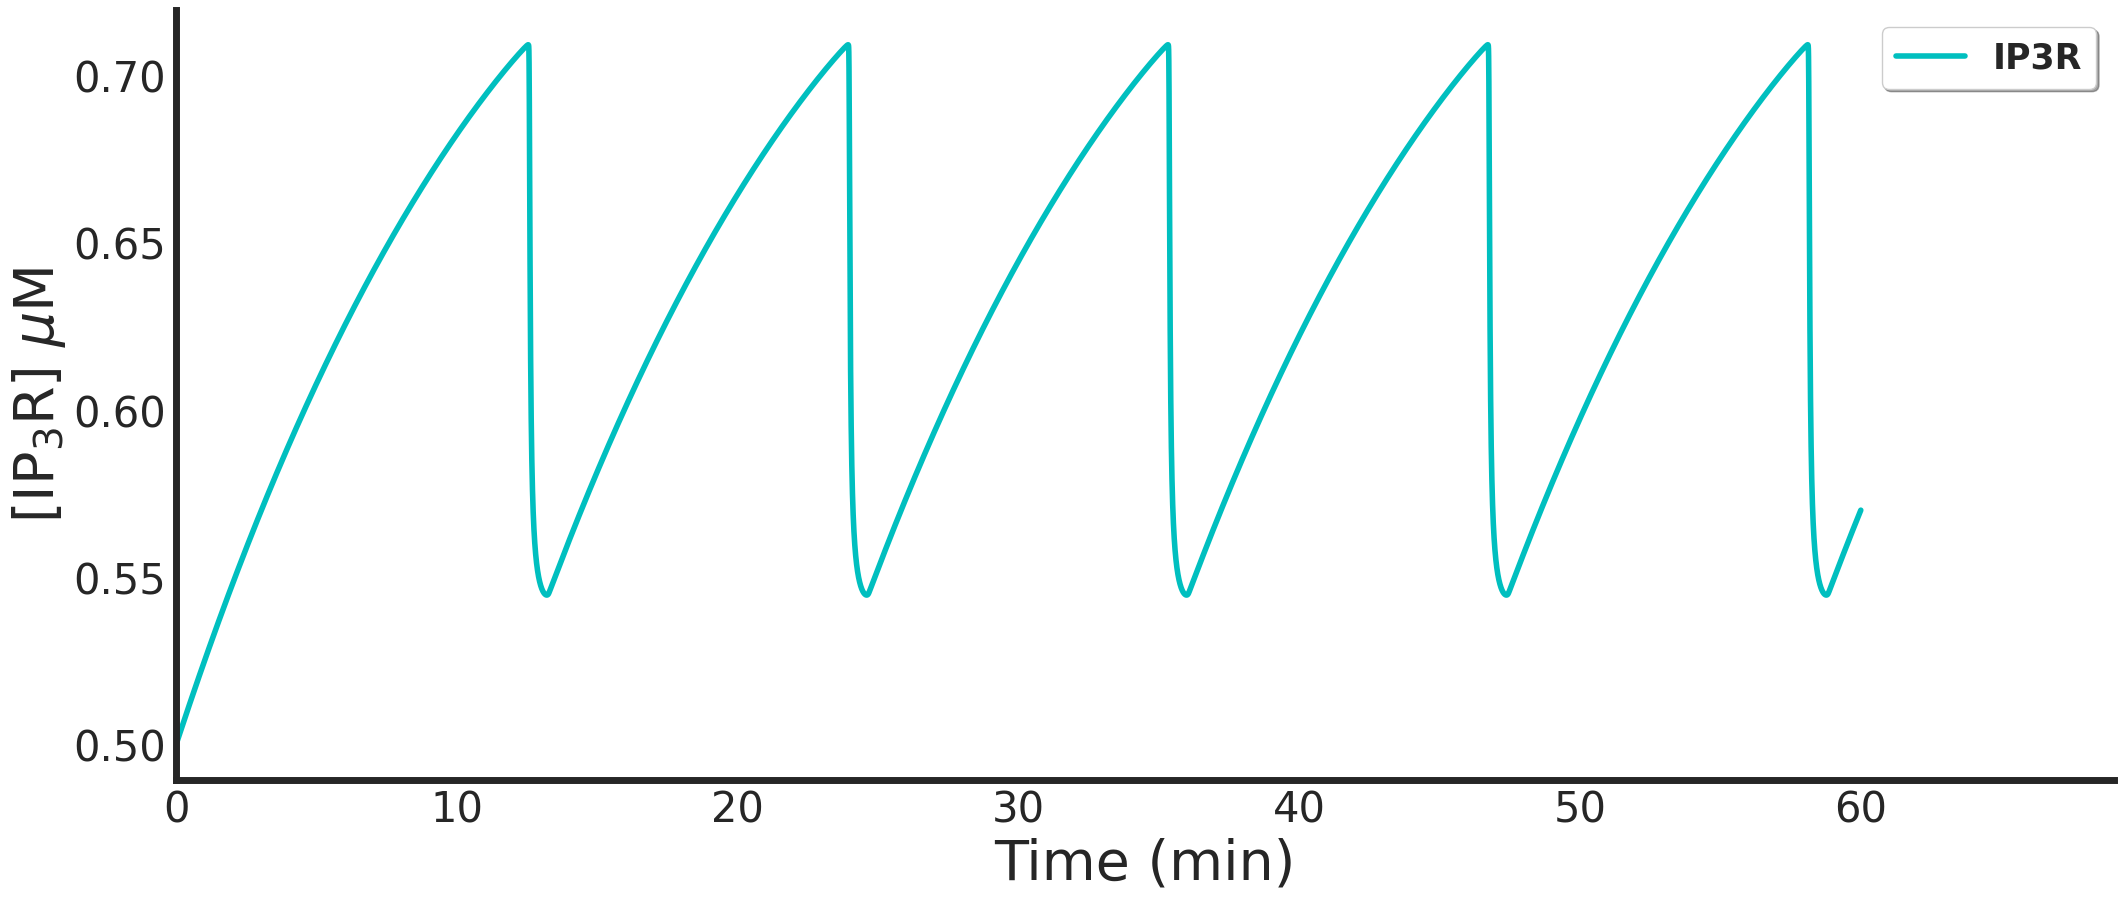

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$R] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

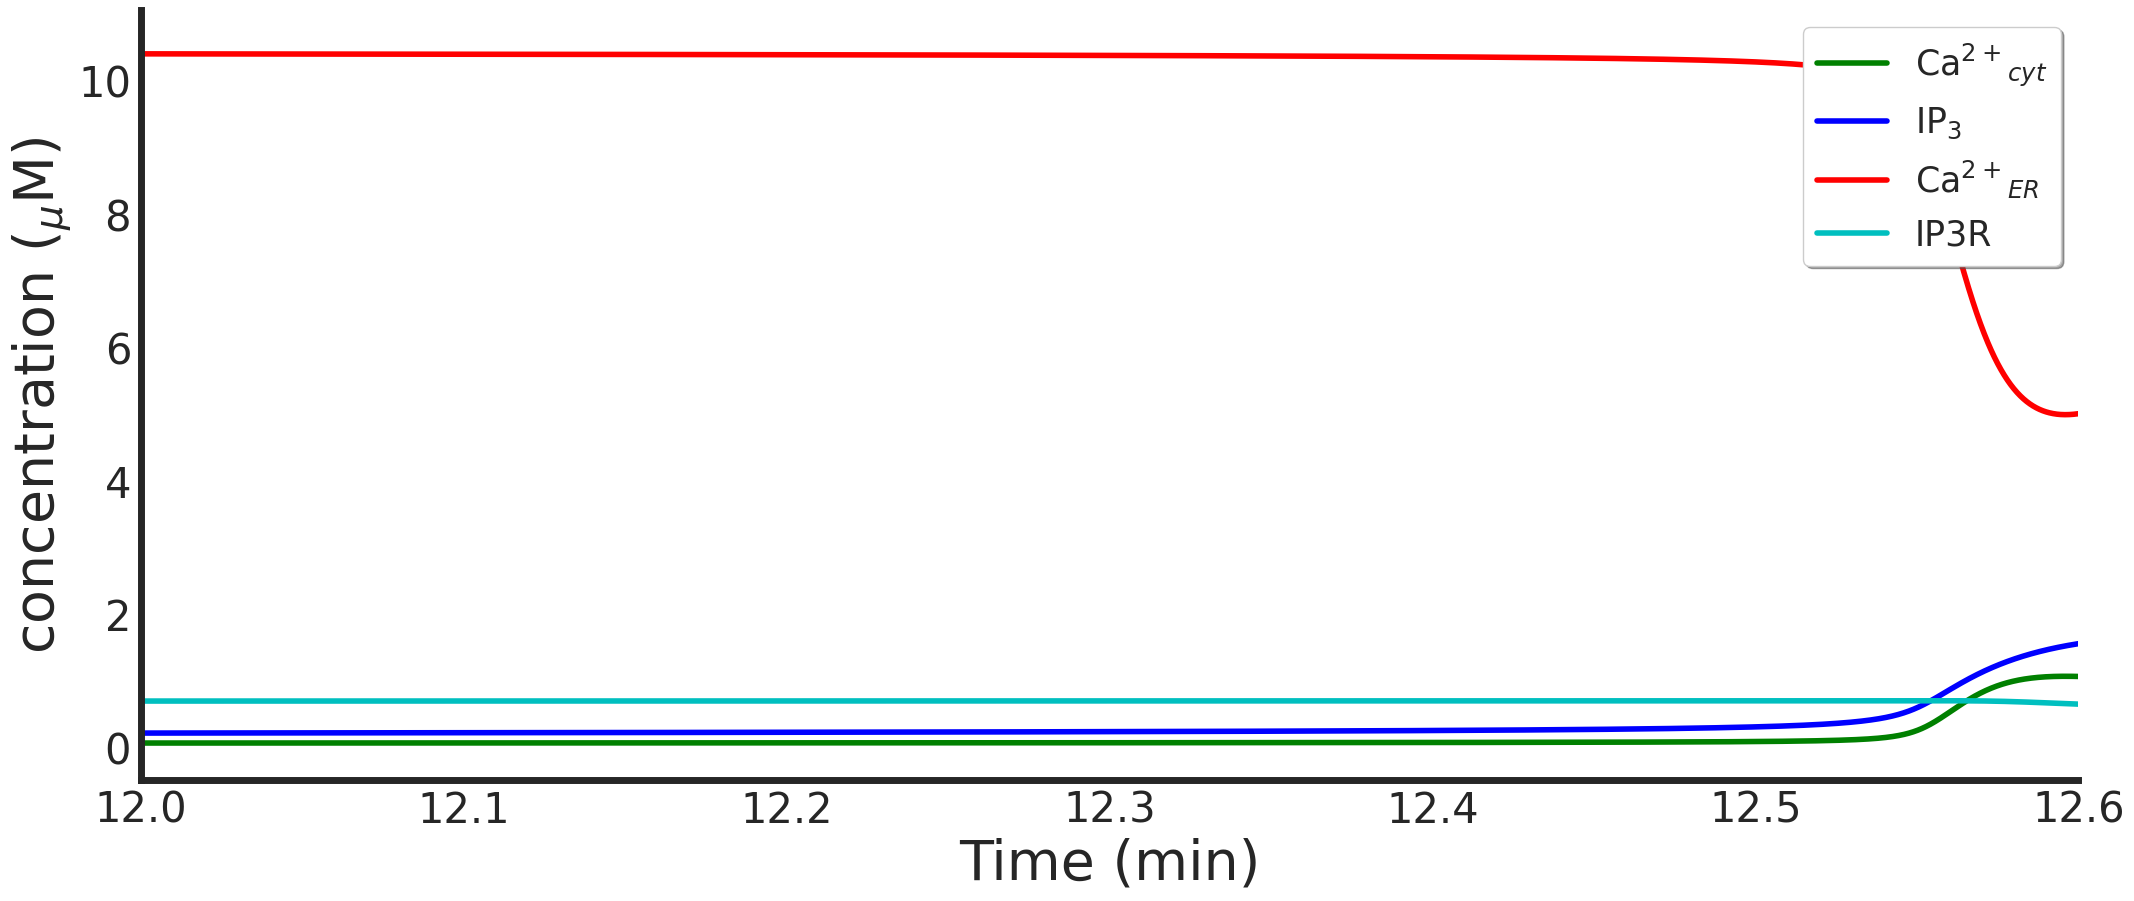

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([12,12.6])

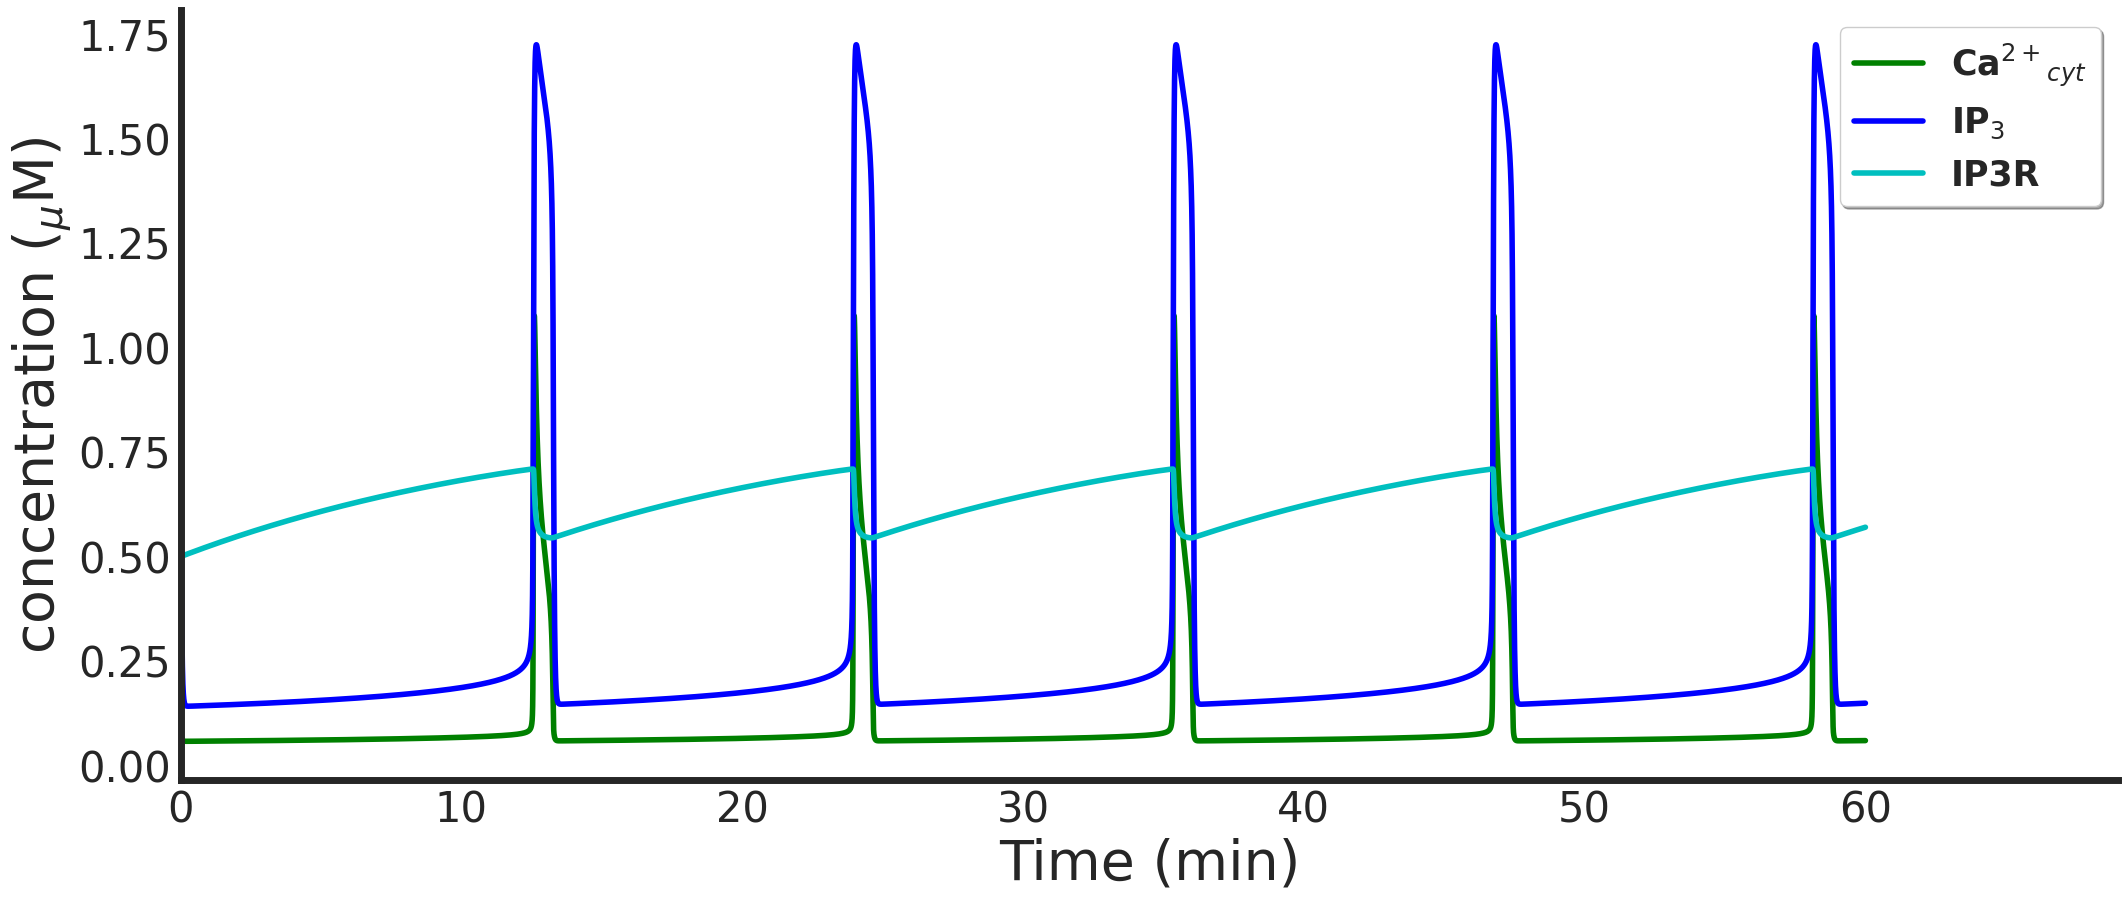

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

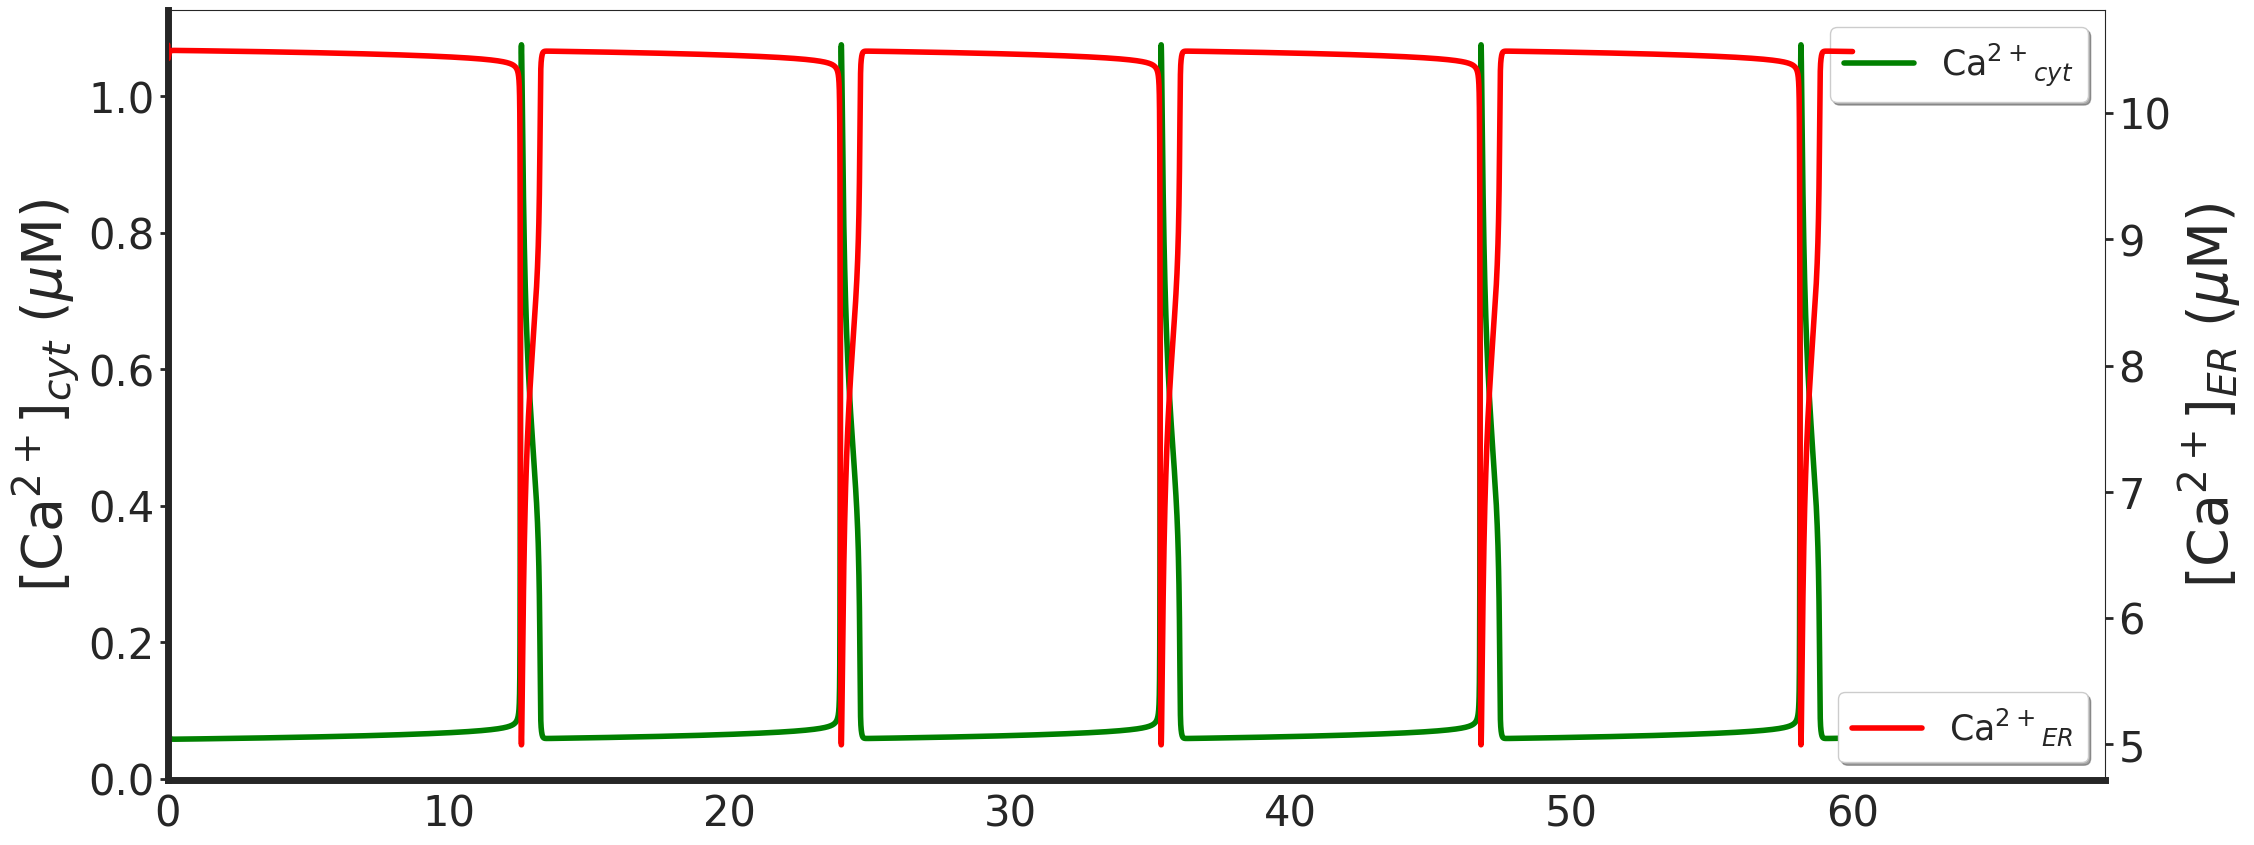

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax1 = ax.twinx()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    ax.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax1.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax1.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax.tick_params(axis='x', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='x', which='minor', labelsize=30, length=4, width=1)


    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)


    ax.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    ax1.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$]$_{cyt}$ ($\mu$M)',fontsize=40)
    ax1.set_ylabel(r'[Ca$^{2+}$]$_{ER}$ ($\mu$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax1.legend(loc=4, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

#K_Tau = 0.75#

Same equations as used in the previous block, only changing the value of K_Tau. Refer to first block for detailed comments of the equations.

In [ ]:
def Ca_cyt_dot(Ca_cyt, IP3, IP3R,C_ER):
  k1 = 1.11
  k2 = 0.0203
  Ka = 0.08
  Kp = 0.13
  k3= 0.4
  k3z = 0.0
  k5 = 0.66

  Kserca = 0.1
  Vserca = 0.9
  # no need to solve Calcium in reticulum with an ODE because total Calcium is constant so
  Ctot = 2.0
  beta = 0.185
  #Ca_R = (Ctot-Ca_cyt)/beta we don't need this anymore since we have the actual calcium in reticulum ode
  eps = 0.0
  v0 = 0.0008
  vpm = 0.0
  kpm = 0.01
  phi = 0.0
  vplc = 1.6
  return (k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt) - Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)+eps*(v0+(phi*vplc)/((k3z+k5))-(vpm*Ca_cyt**2/(kpm**2+Ca_cyt**2))) #added in the calcium in the reticulum

def IP3R_dot(Ca_cyt, IP3, IP3R):
  tau_max = 1000 #add tau_new_max and rewrite
  k_tau = 0.75 #is like vplc and has range from 0.5 to 1.2 but we can only change one (either vplc or ktau)
  tau_new_update = tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4)
  ki = 0.4
  return (1.0/tau_new_update)*(1-IP3R*(ki+Ca_cyt)/ki)

def IP3_dot(Ca_cyt, IP3, IP3R):
  k5 = 0.66 # parameter
  k3 = 0.4
  k3z= 0.0
  VPLC = 1.6 # paramter (is from .1-1.5 micromoles)
  K_PLC = 0.2 # parameter
  tau_p = 1
  vplc = (VPLC*Ca_cyt**2/(K_PLC**2+Ca_cyt**2))
  vdeg = (k5+(k3z*Ca_cyt**2/(k3**2+Ca_cyt**2)))*IP3
  return tau_p * (vplc - vdeg)
def C_ER_dot(Ca_cyt, IP3, IP3R, C_ER):
  beta = 0.185
  Kserca = 0.1
  Vserca = 0.9
  k1 = 1.11
  Ka = 0.08
  Kp = 0.13
  k2 = 0.0203
  Ctot = 2.0
  Ca_R = (Ctot-Ca_cyt)/beta
  return (1.0/beta)*((((Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)))-(k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt)))




In [ ]:
dt = 0.01 #s
t_final = 3600 # s
n_steps = int(t_final/dt)
# create arrays to store solution
Ca_cyt_vec = np.zeros((n_steps))
IP3_vec = np.zeros((n_steps))
C_ER_vec = np.zeros((n_steps))
IP3R_vec = np.zeros((n_steps))
time_vec = np.zeros((n_steps))
# Initial conditions
Ca_cyt_vec[0] = .05
IP3_vec[0] = 1
C_ER_vec[0] = (2.0 - .05)/0.185
IP3R_vec[0] = 0.5

for i in range(n_steps-1):
  Ca_cyt_vec[i+1] = Ca_cyt_vec[i]+dt*Ca_cyt_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3_vec[i+1] = IP3_vec[i]+dt*IP3_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  C_ER_vec[i+1] = C_ER_vec[i]+dt*C_ER_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3R_vec[i+1] = IP3R_vec[i]+dt*IP3R_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  time_vec[i+1] = time_vec[i]+dt

Plots with K_Tau value of 0.75

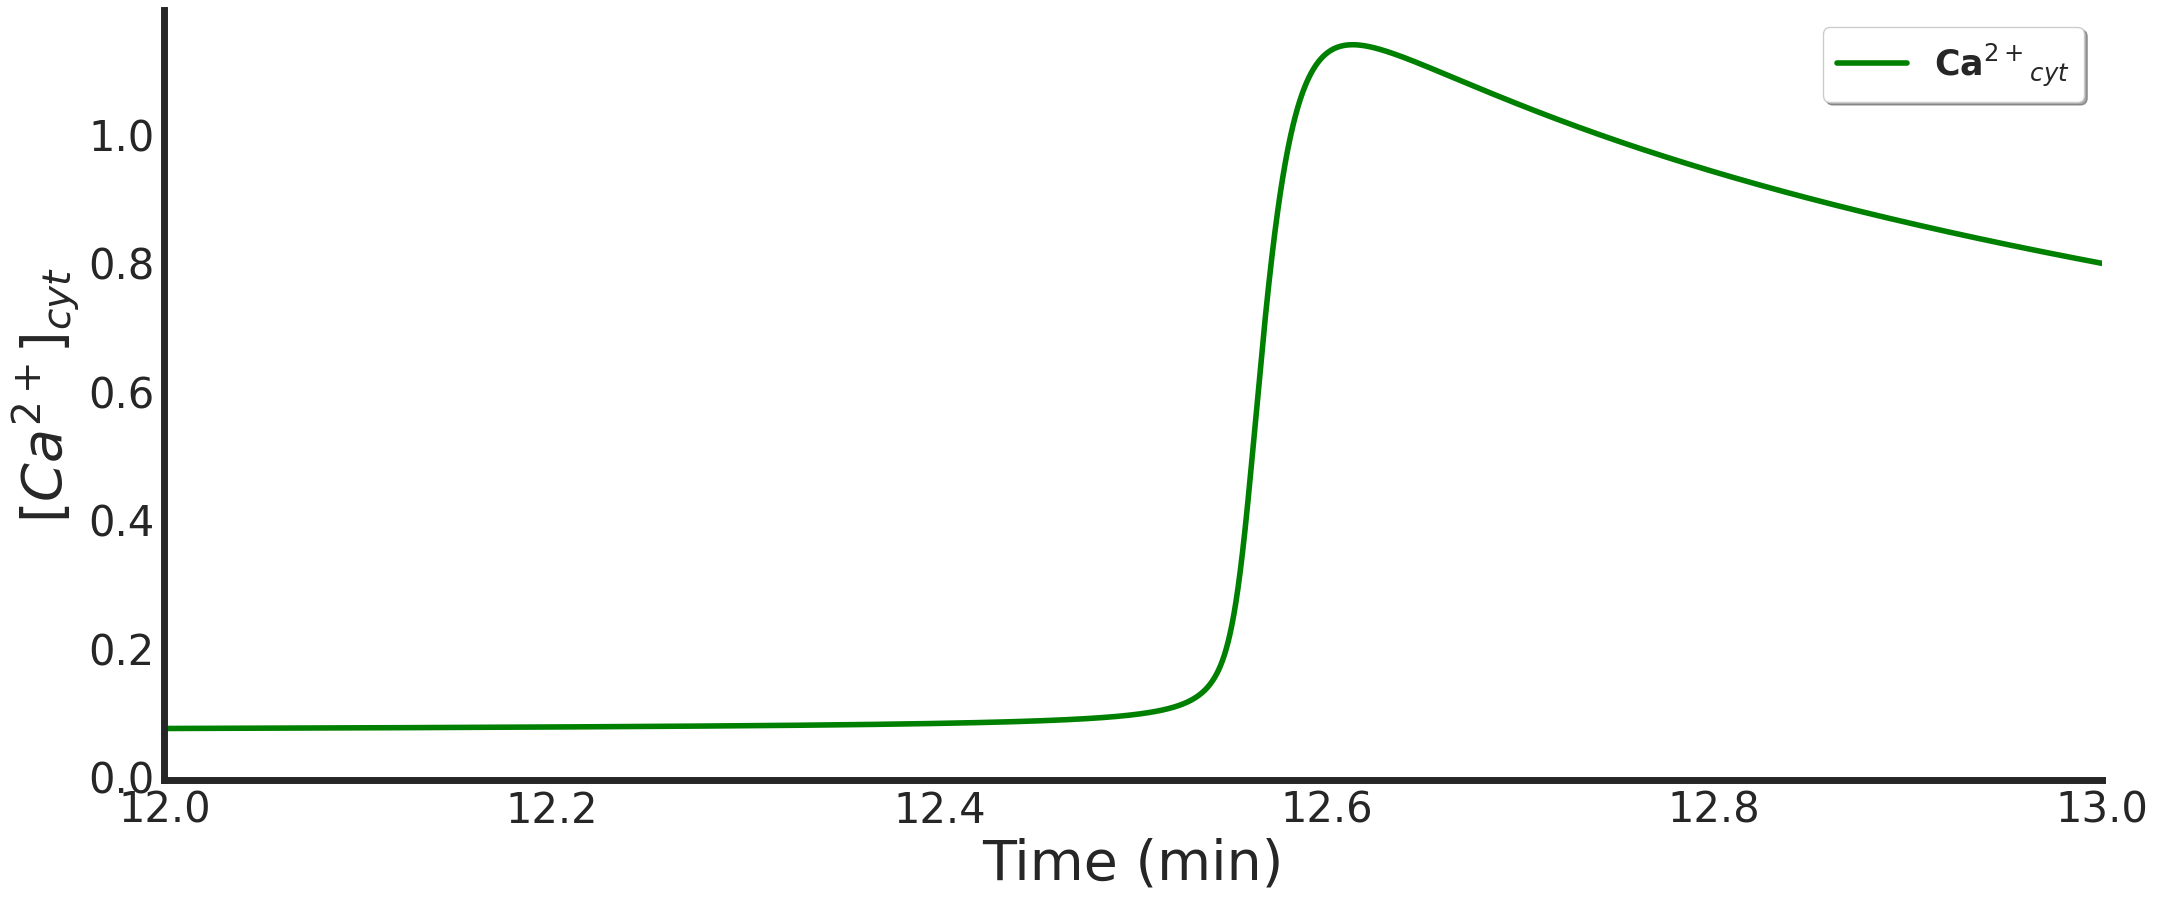

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[$Ca^{2+}$]$_{cyt}$',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([12.0,13])

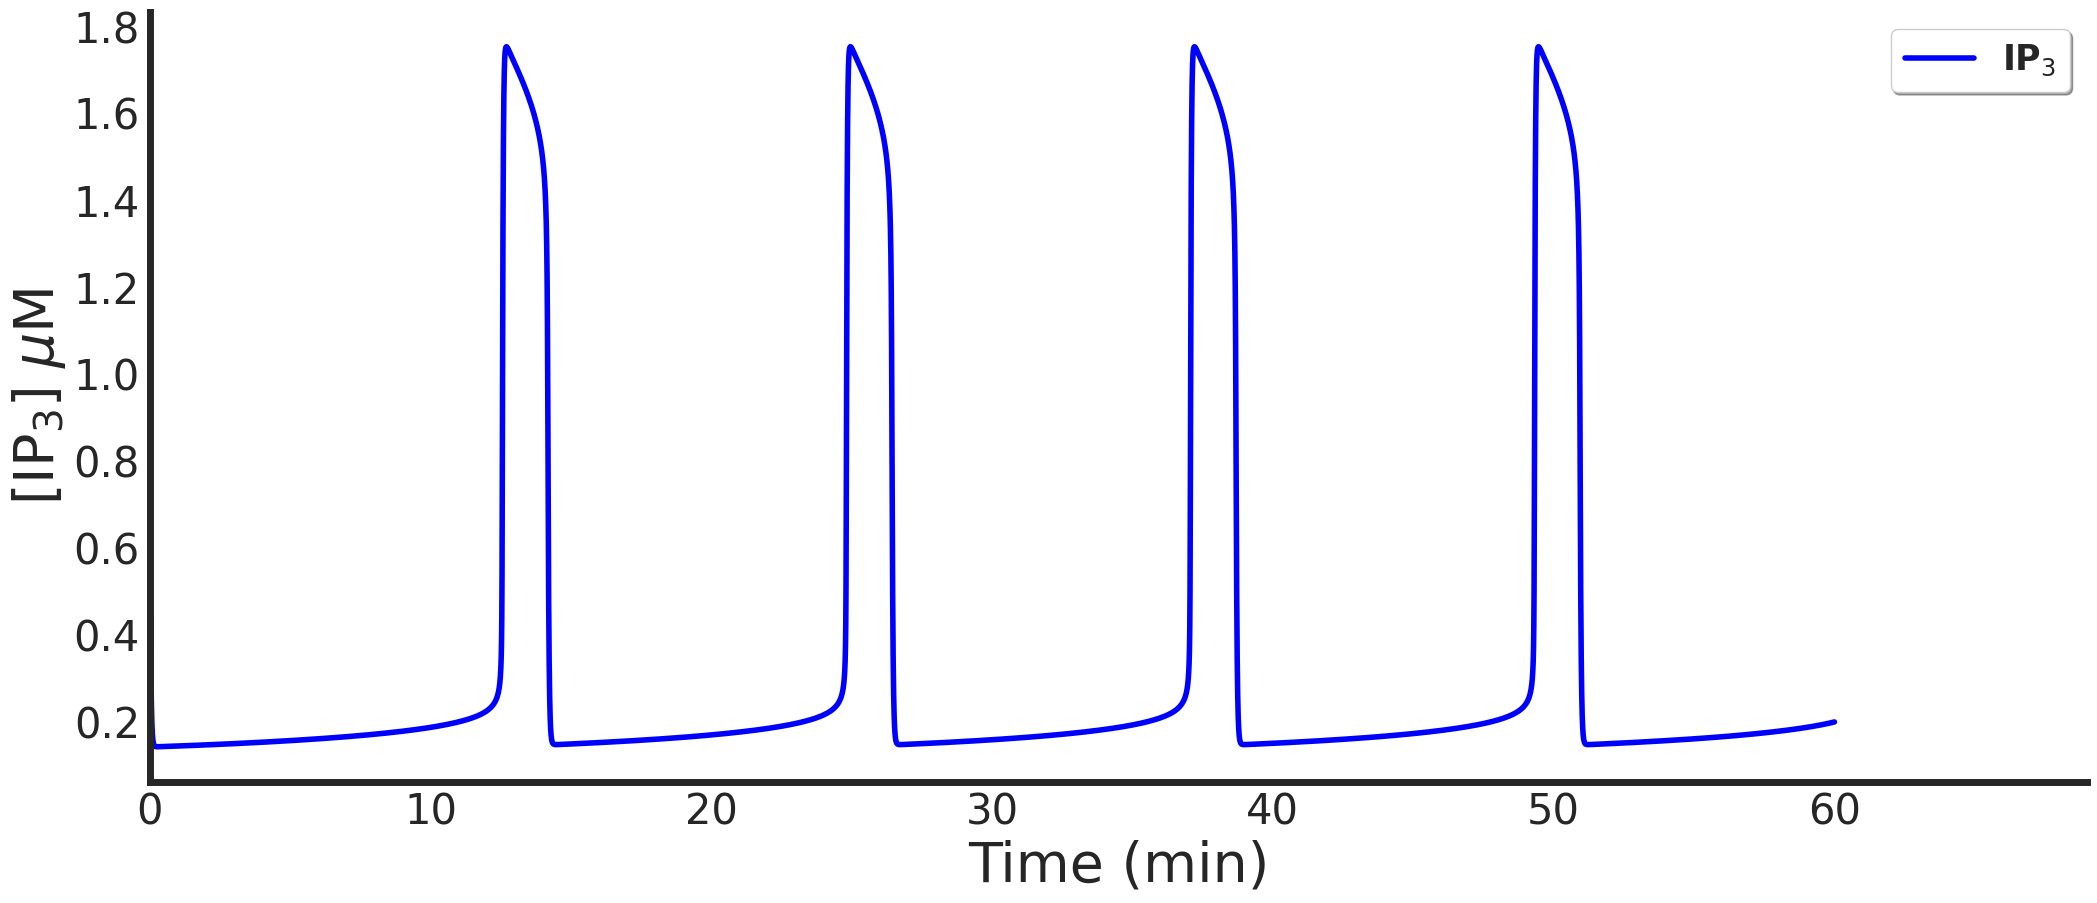

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

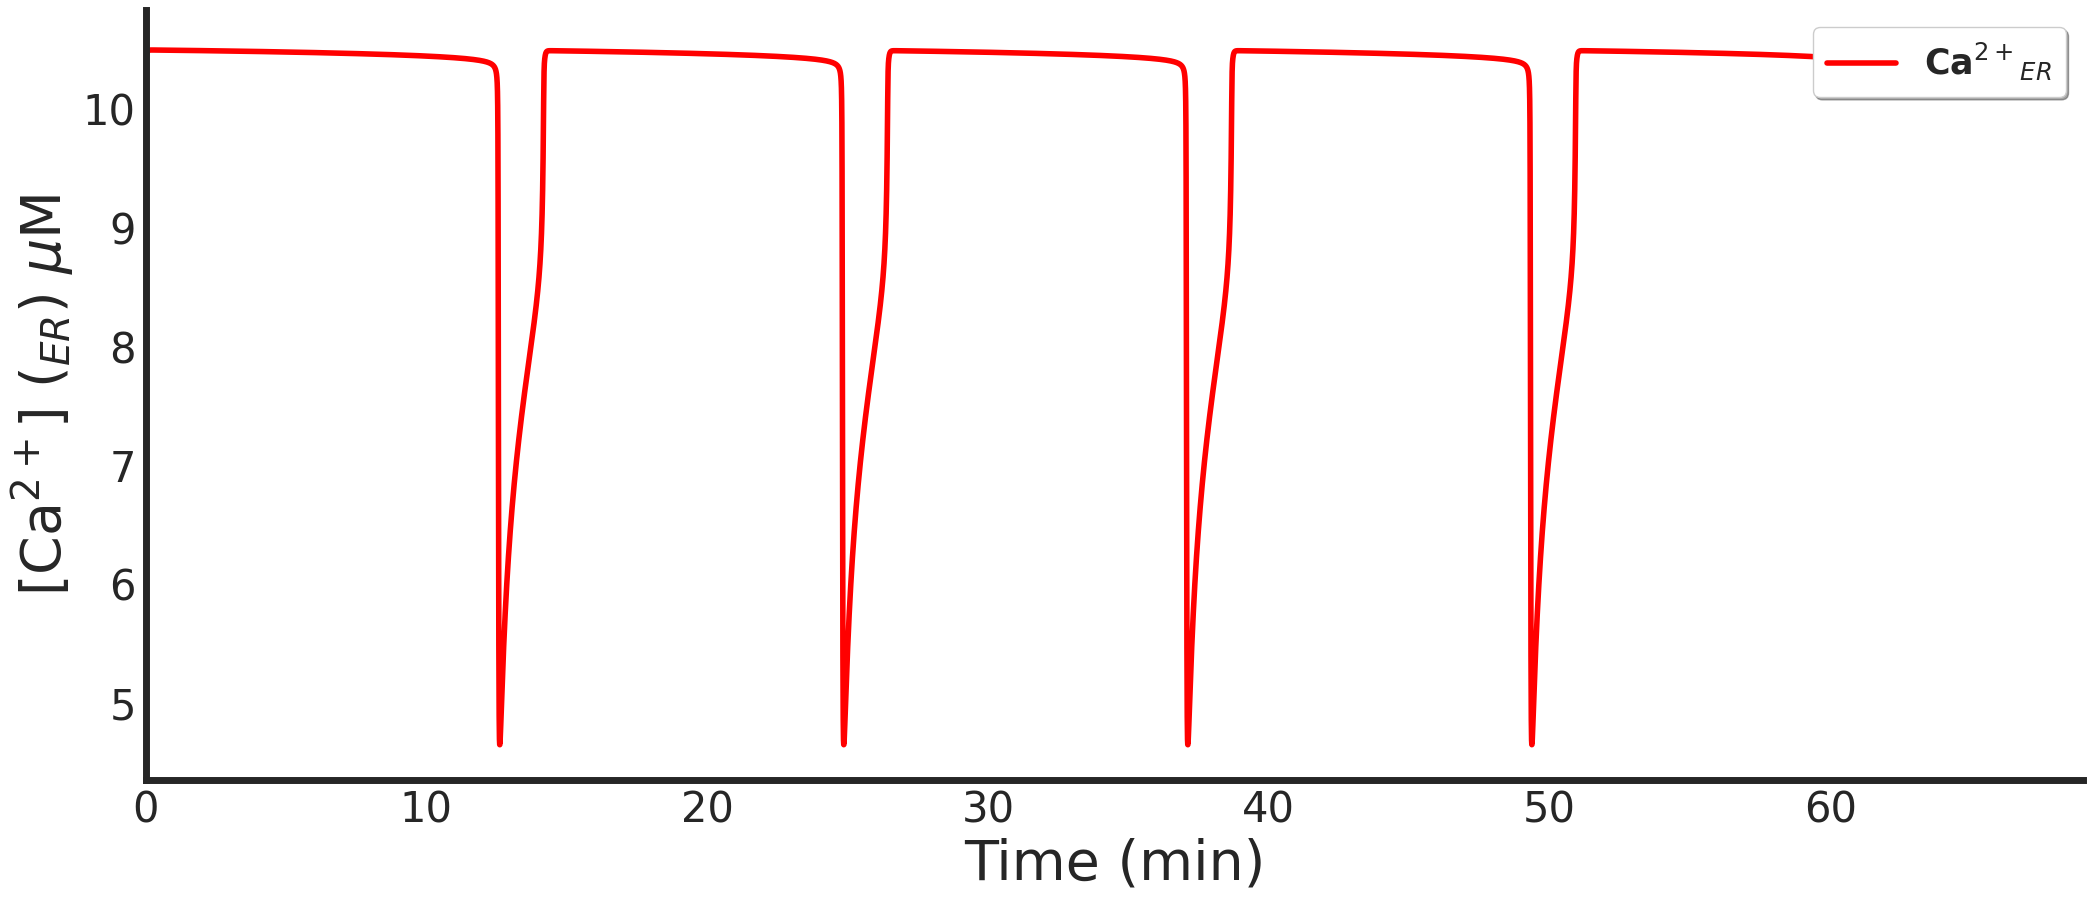

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$] ($_{ER}$) $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

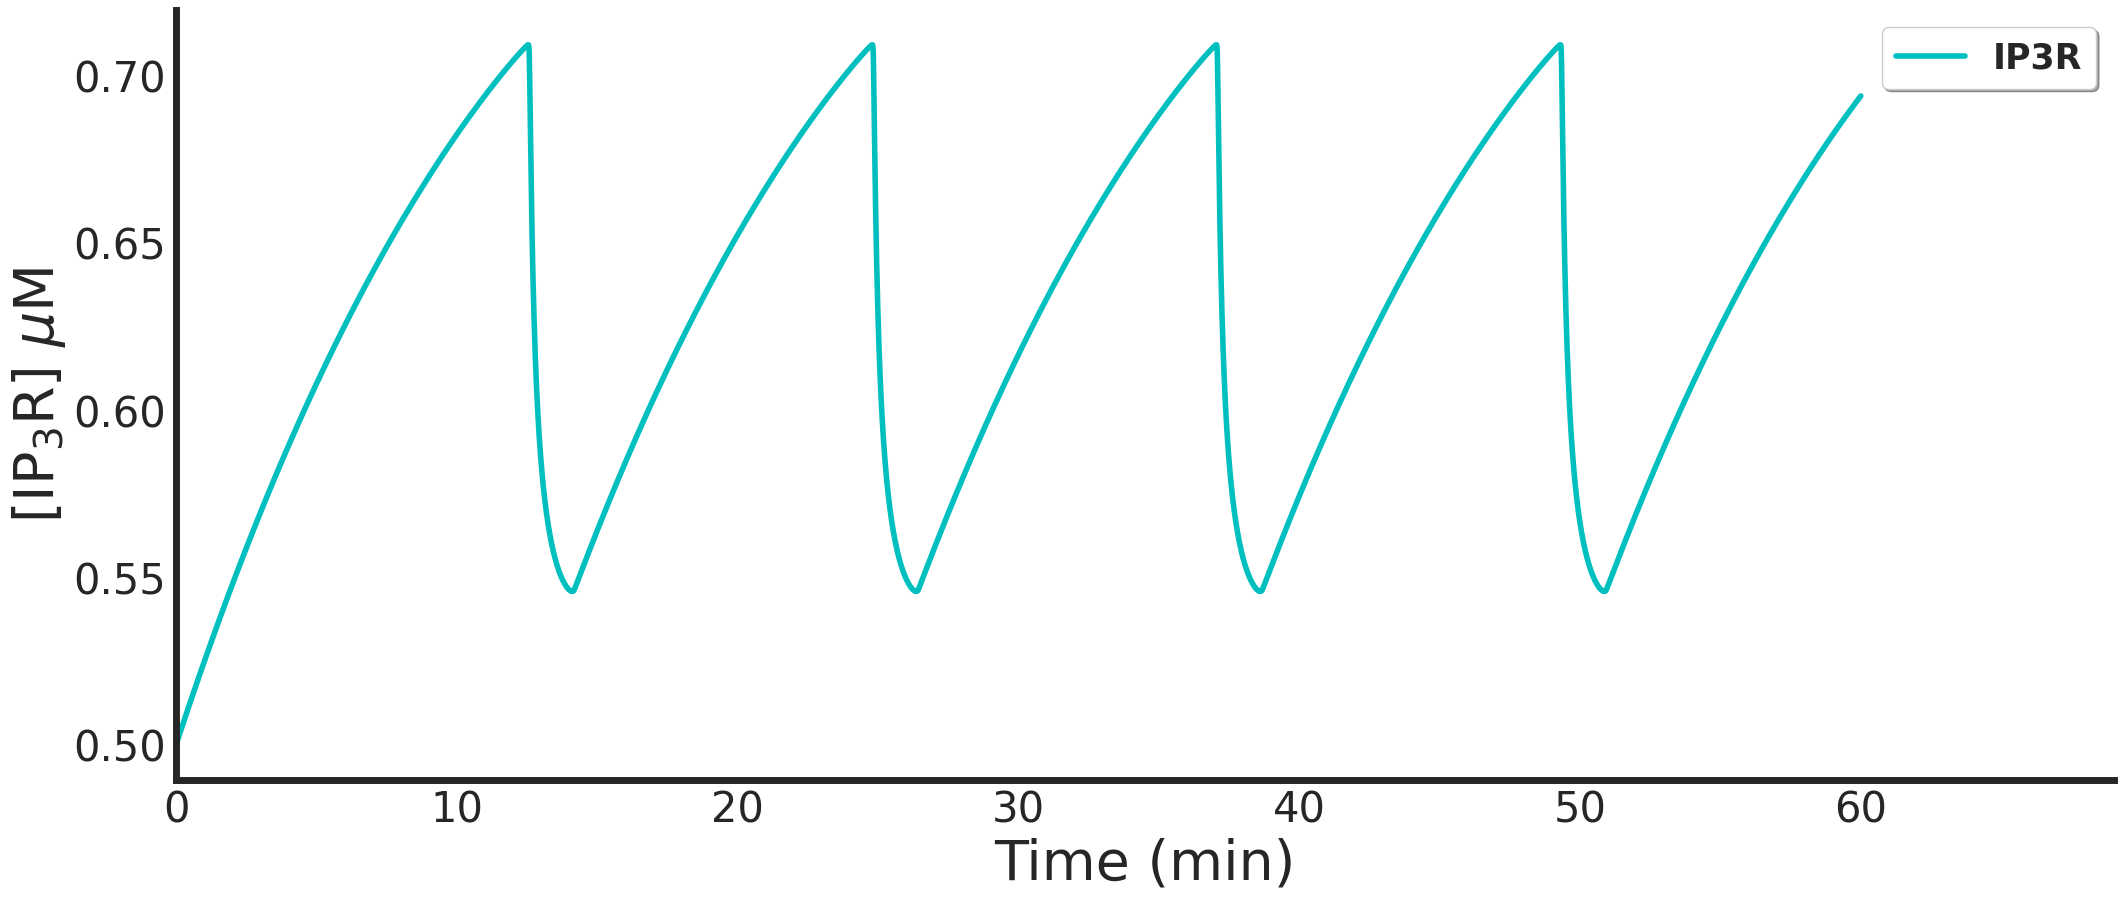

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$R] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

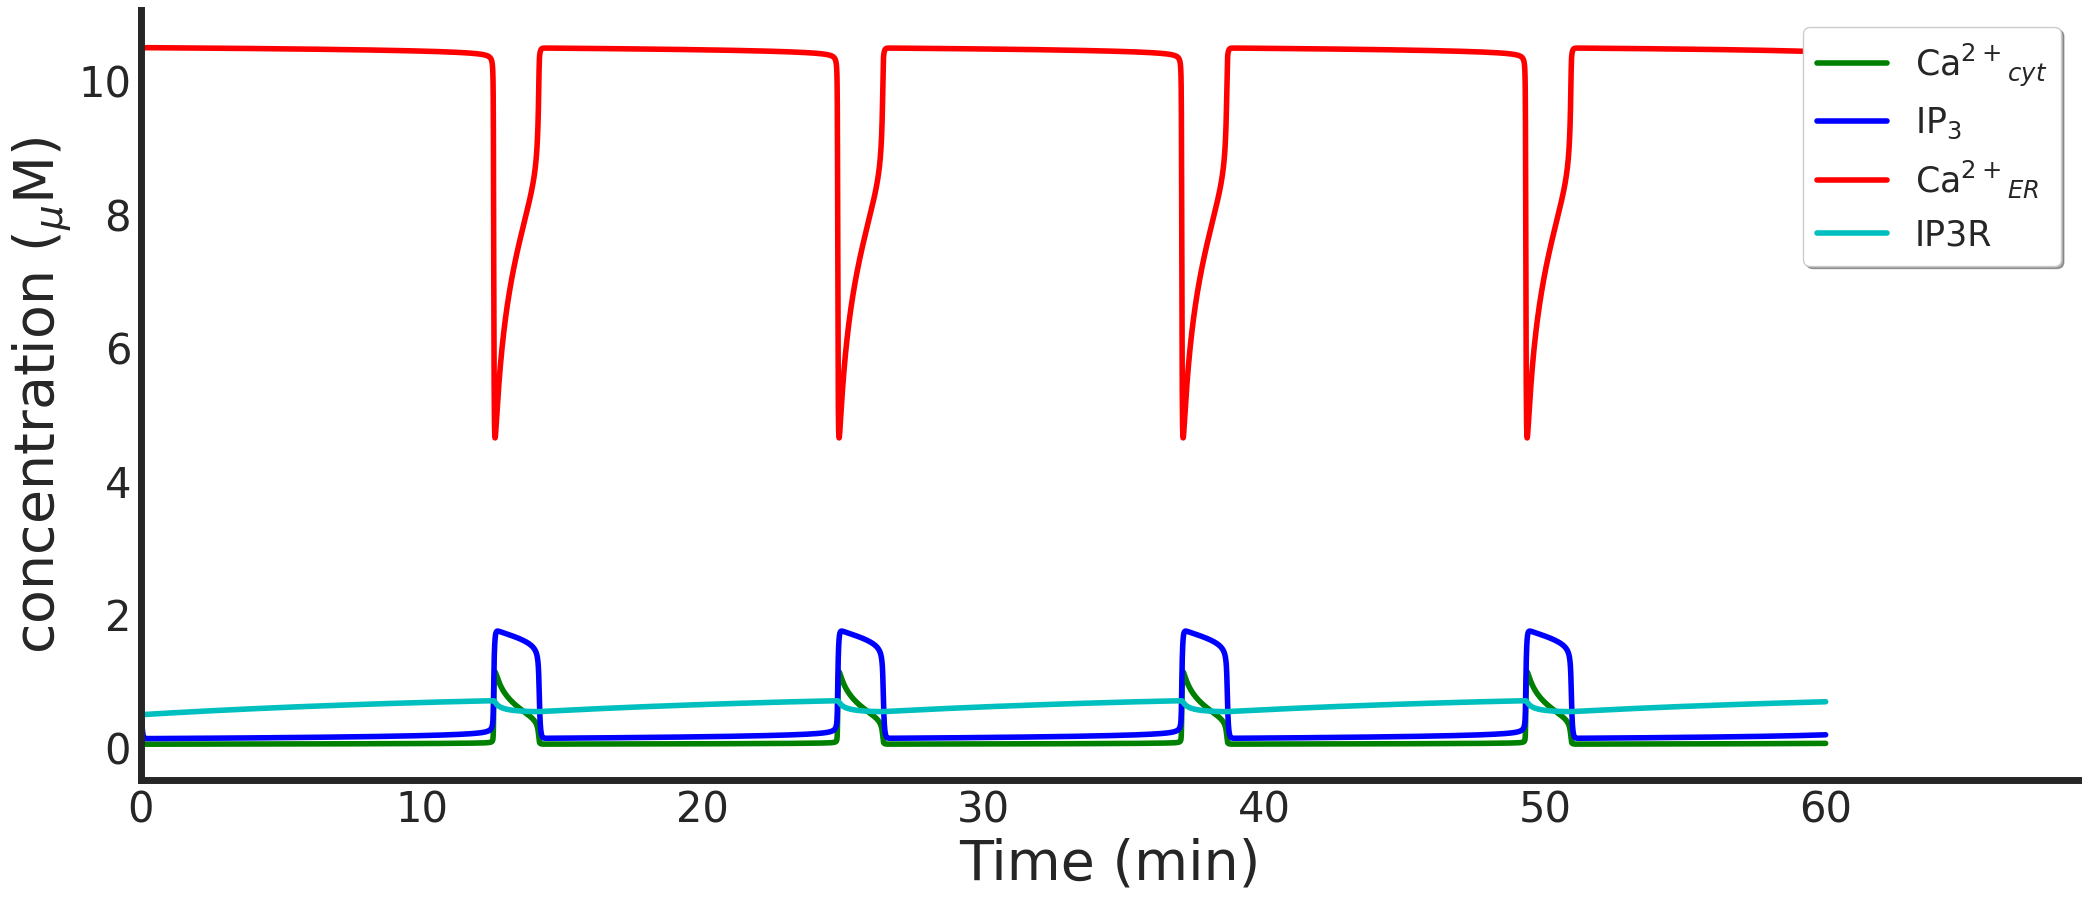

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

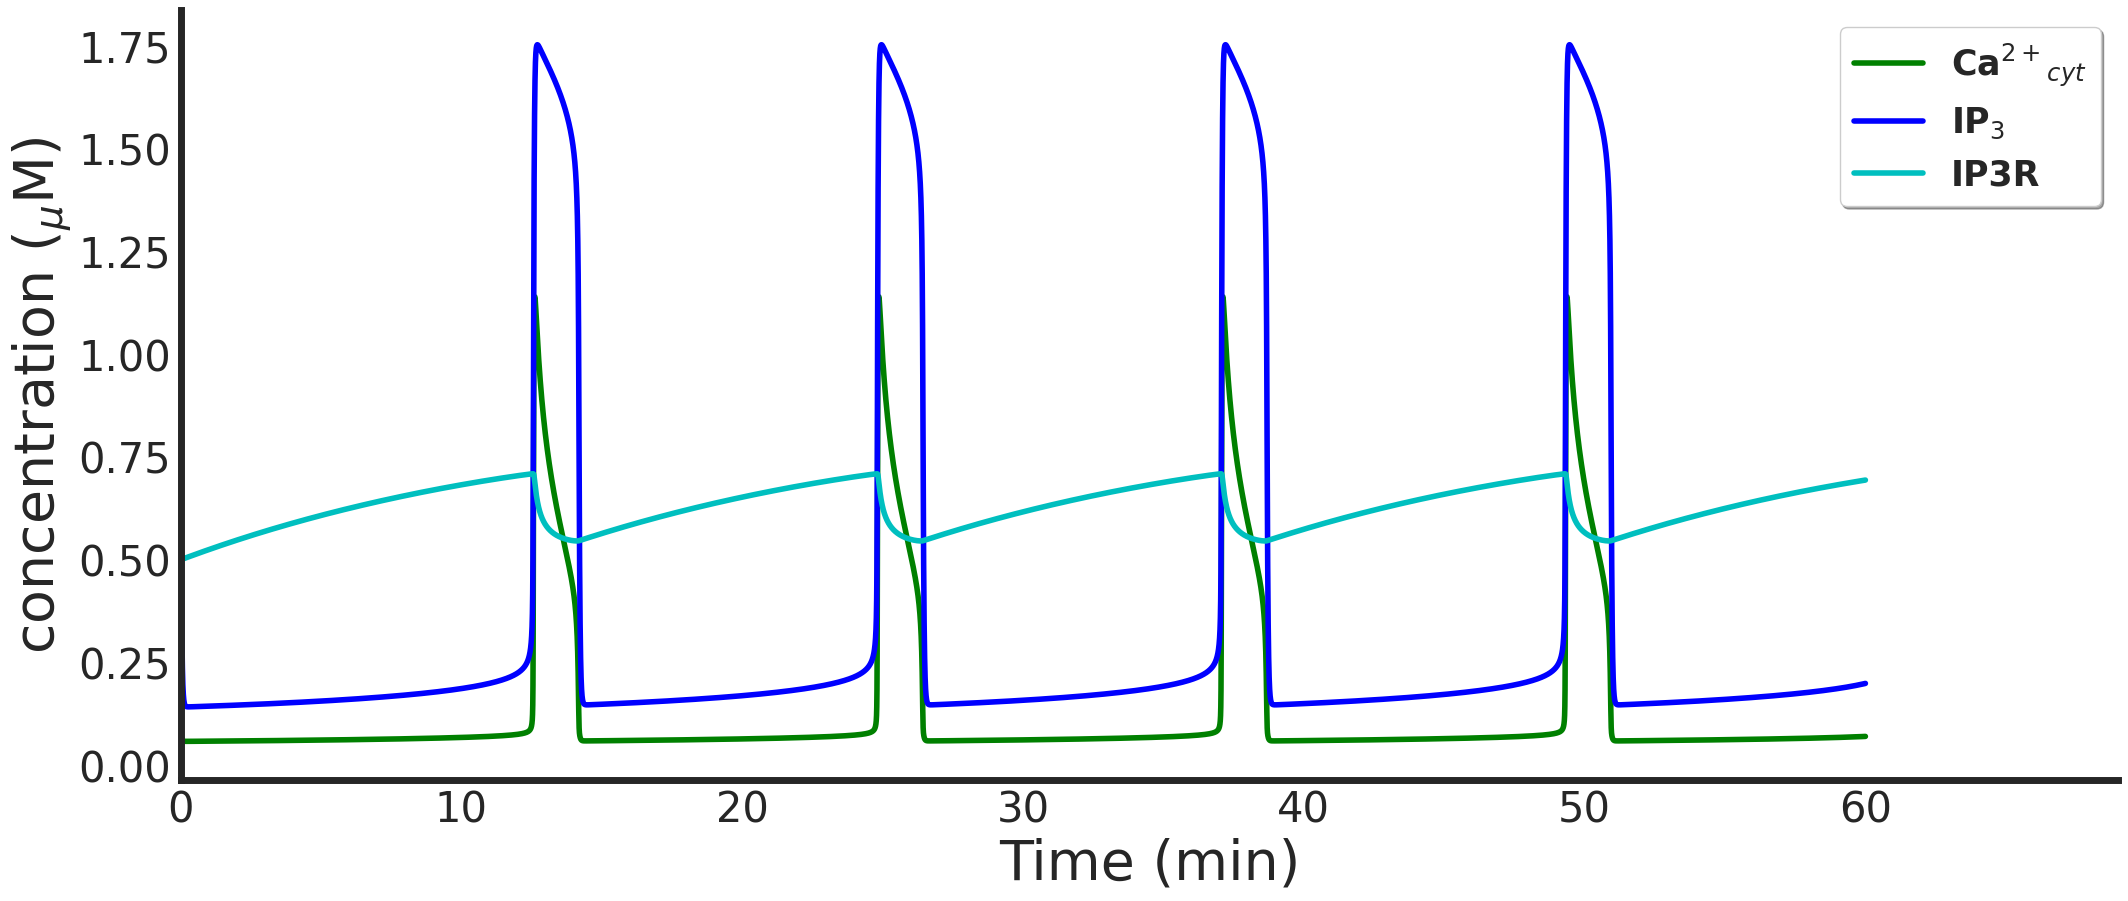

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

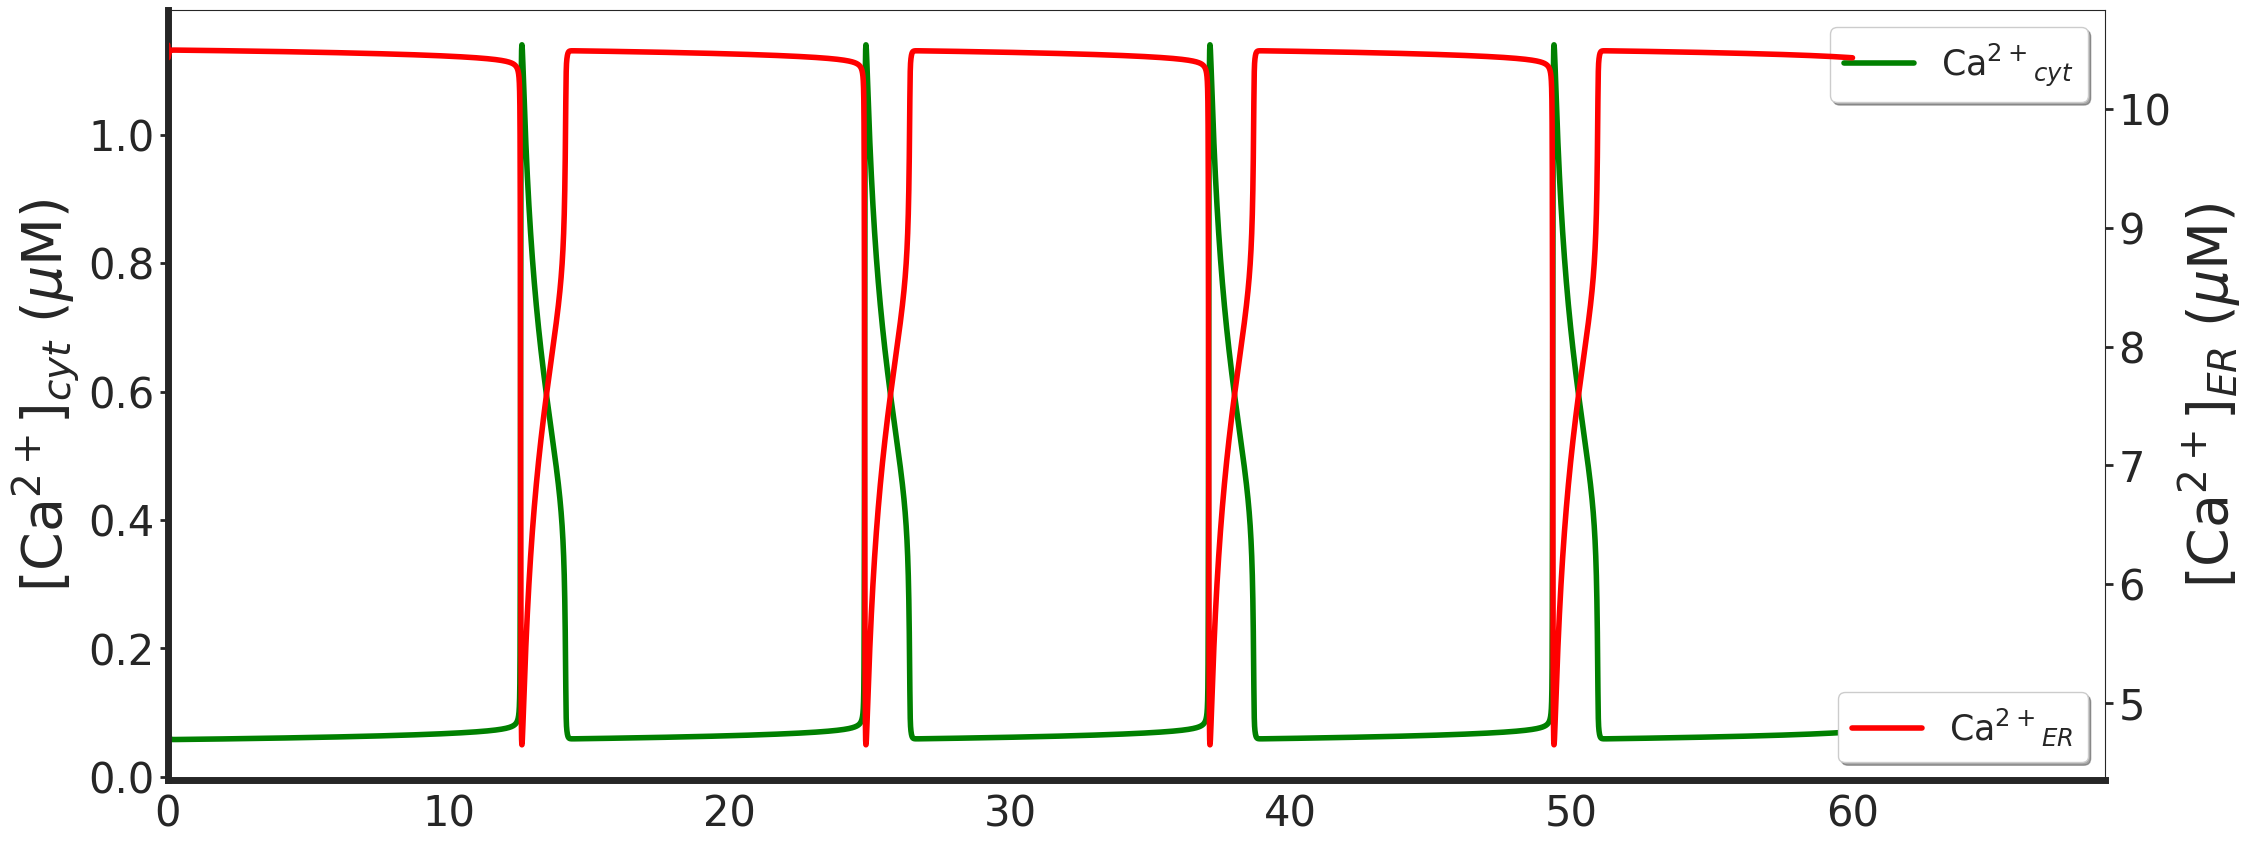

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax1 = ax.twinx()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    ax.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax1.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax1.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax.tick_params(axis='x', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='x', which='minor', labelsize=30, length=4, width=1)


    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)


    ax.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    ax1.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$]$_{cyt}$ ($\mu$M)',fontsize=40)
    ax1.set_ylabel(r'[Ca$^{2+}$]$_{ER}$ ($\mu$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax1.legend(loc=4, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

#K_Tau = 1.0#

Same equations as used in the previous block, only changing the value of K_Tau. Refer to first block for detailed comments of the equations.

In [ ]:
def Ca_cyt_dot(Ca_cyt, IP3, IP3R,C_ER):
  k1 = 1.11
  k2 = 0.0203
  Ka = 0.08
  Kp = 0.13
  k3= 0.4
  k3z = 0.0
  k5 = 0.66

  Kserca = 0.1
  Vserca = 0.9
  # no need to solve Calcium in reticulum with an ODE because total Calcium is constant so
  Ctot = 2.0
  beta = 0.185
  #Ca_R = (Ctot-Ca_cyt)/beta we don't need this anymore since we have the actual calcium in reticulum ode
  eps = 0.0
  v0 = 0.0008
  vpm = 0.0
  kpm = 0.01
  phi = 0.0
  vplc = 1.6
  return (k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt) - Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)+eps*(v0+(phi*vplc)/((k3z+k5))-(vpm*Ca_cyt**2/(kpm**2+Ca_cyt**2))) #added in the calcium in the reticulum

def IP3R_dot(Ca_cyt, IP3, IP3R):
  tau_max = 1000 #add tau_new_max and rewrite
  k_tau = 1.0 #is like vplc and has range from 0.5 to 1.2 but we can only change one (either vplc or ktau)
  tau_new_update = tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4)
  ki = 0.4
  return (1.0/tau_new_update)*(1-IP3R*(ki+Ca_cyt)/ki)

def IP3_dot(Ca_cyt, IP3, IP3R):
  k5 = 0.66 # parameter
  k3 = 0.4
  k3z= 0.0
  VPLC = 1.6 # paramter (is from .1-1.5 micromoles)
  K_PLC = 0.2 # parameter
  tau_p = 1
  vplc = (VPLC*Ca_cyt**2/(K_PLC**2+Ca_cyt**2))
  vdeg = (k5+(k3z*Ca_cyt**2/(k3**2+Ca_cyt**2)))*IP3
  return tau_p * (vplc - vdeg)
def C_ER_dot(Ca_cyt, IP3, IP3R, C_ER):
  beta = 0.185
  Kserca = 0.1
  Vserca = 0.9
  k1 = 1.11
  Ka = 0.08
  Kp = 0.13
  k2 = 0.0203
  Ctot = 2.0
  Ca_R = (Ctot-Ca_cyt)/beta
  return (1.0/beta)*((((Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)))-(k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt)))




In [ ]:
dt = 0.01 #s
t_final = 3600 # s
n_steps = int(t_final/dt)
# create arrays to store solution
Ca_cyt_vec = np.zeros((n_steps))
IP3_vec = np.zeros((n_steps))
C_ER_vec = np.zeros((n_steps))
IP3R_vec = np.zeros((n_steps))
time_vec = np.zeros((n_steps))
# Initial conditions
Ca_cyt_vec[0] = .05
IP3_vec[0] = 1
C_ER_vec[0] = (2.0 - .05)/0.185
IP3R_vec[0] = 0.5

for i in range(n_steps-1):
  Ca_cyt_vec[i+1] = Ca_cyt_vec[i]+dt*Ca_cyt_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3_vec[i+1] = IP3_vec[i]+dt*IP3_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  C_ER_vec[i+1] = C_ER_vec[i]+dt*C_ER_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3R_vec[i+1] = IP3R_vec[i]+dt*IP3R_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  time_vec[i+1] = time_vec[i]+dt

Plots with K_Tau value of 1.0

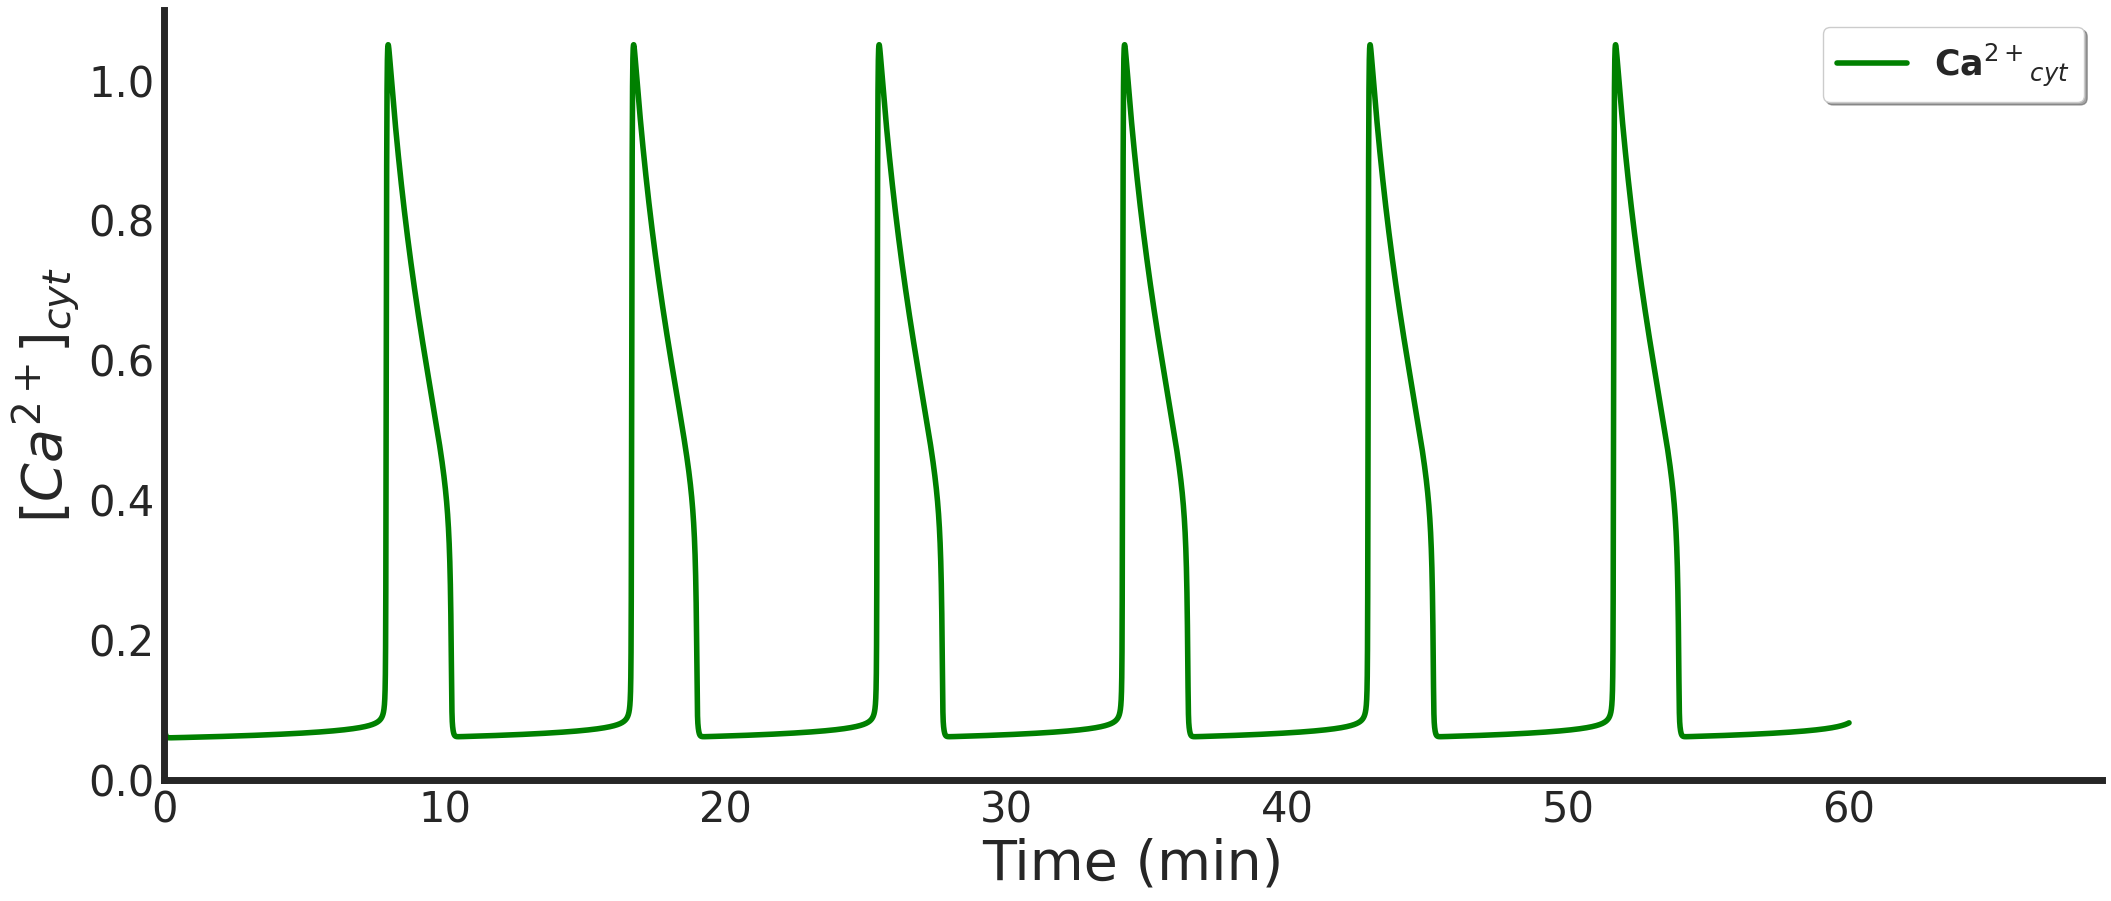

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[$Ca^{2+}$]$_{cyt}$',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

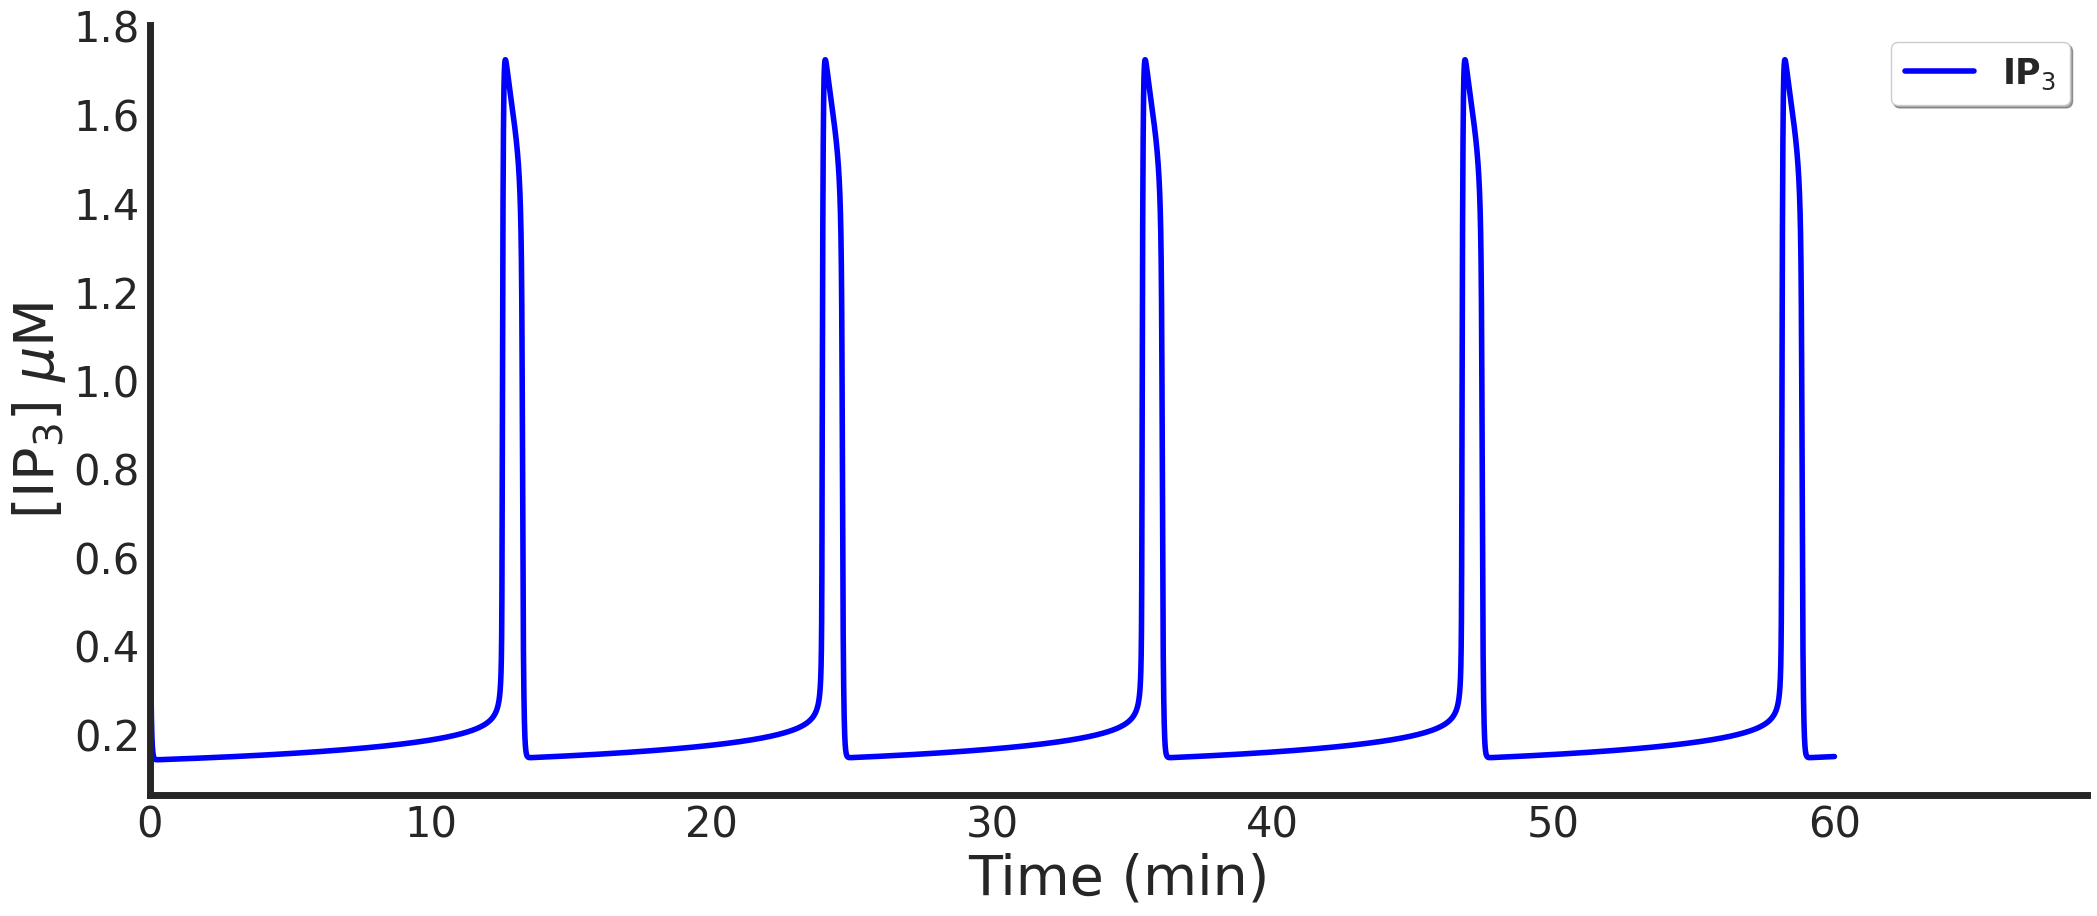

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

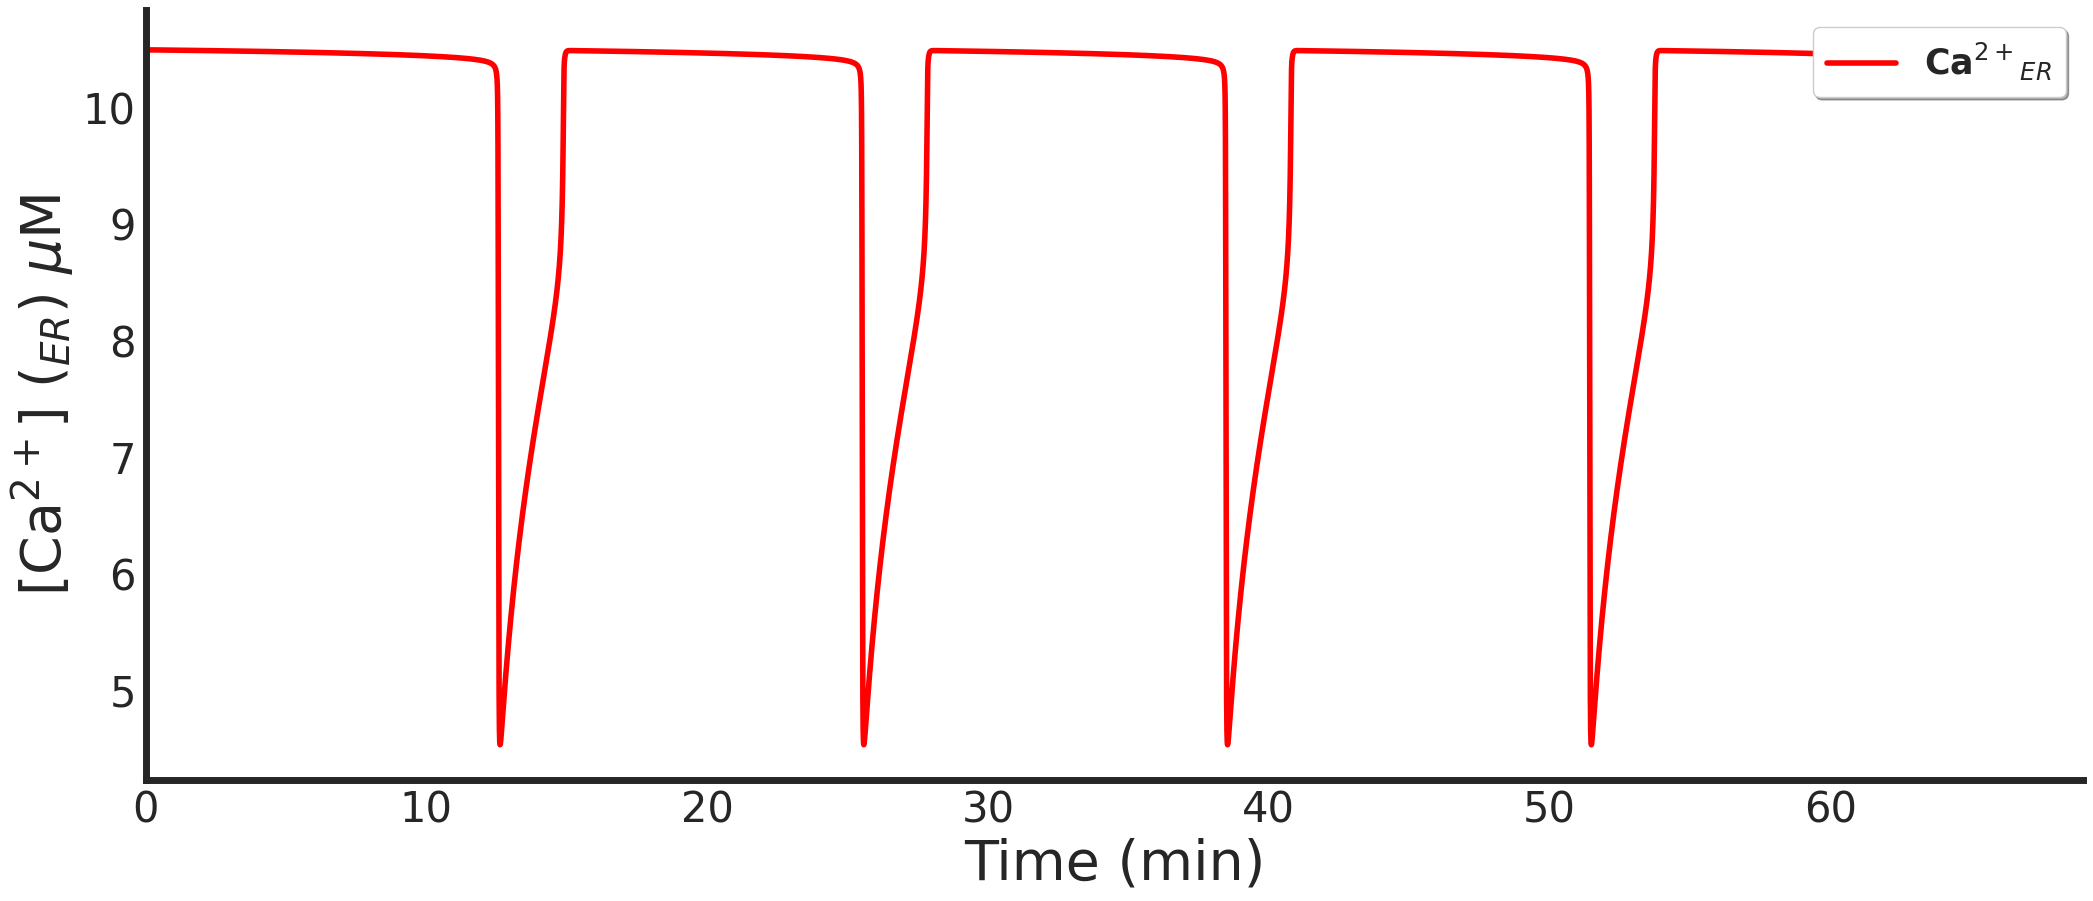

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$] ($_{ER}$) $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

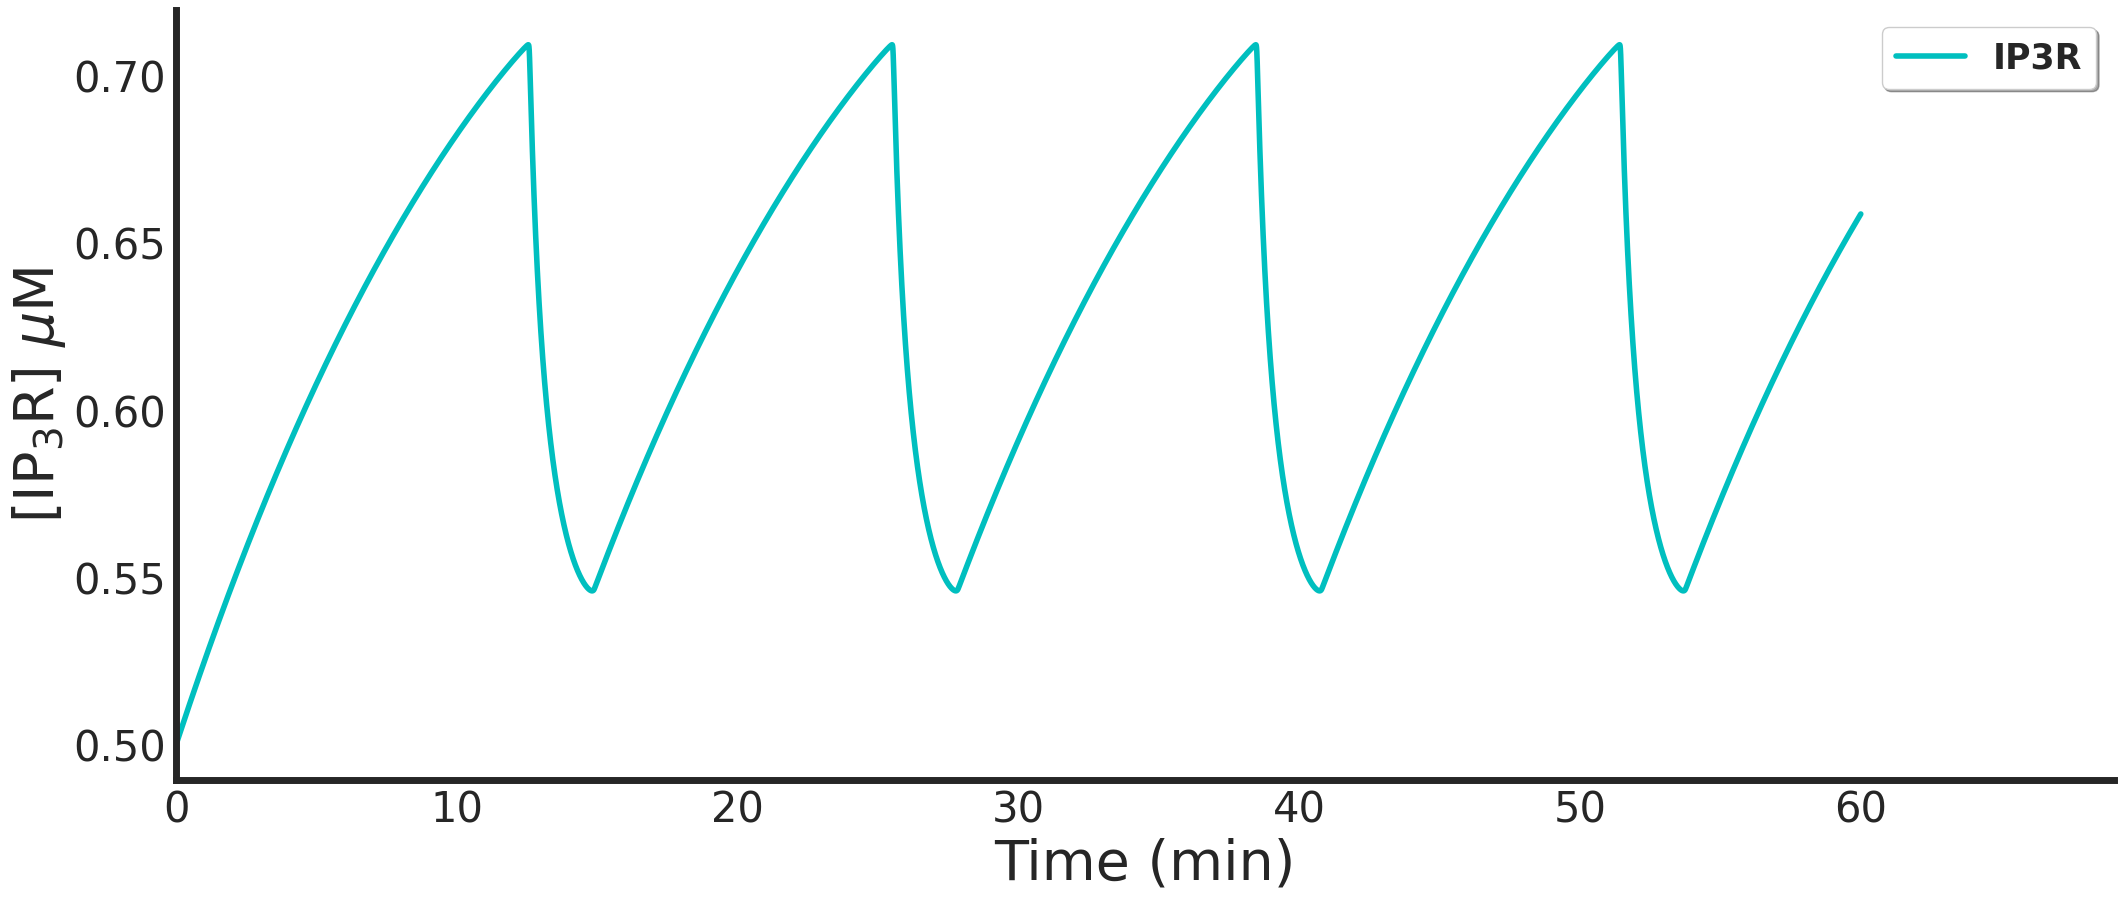

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$R] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

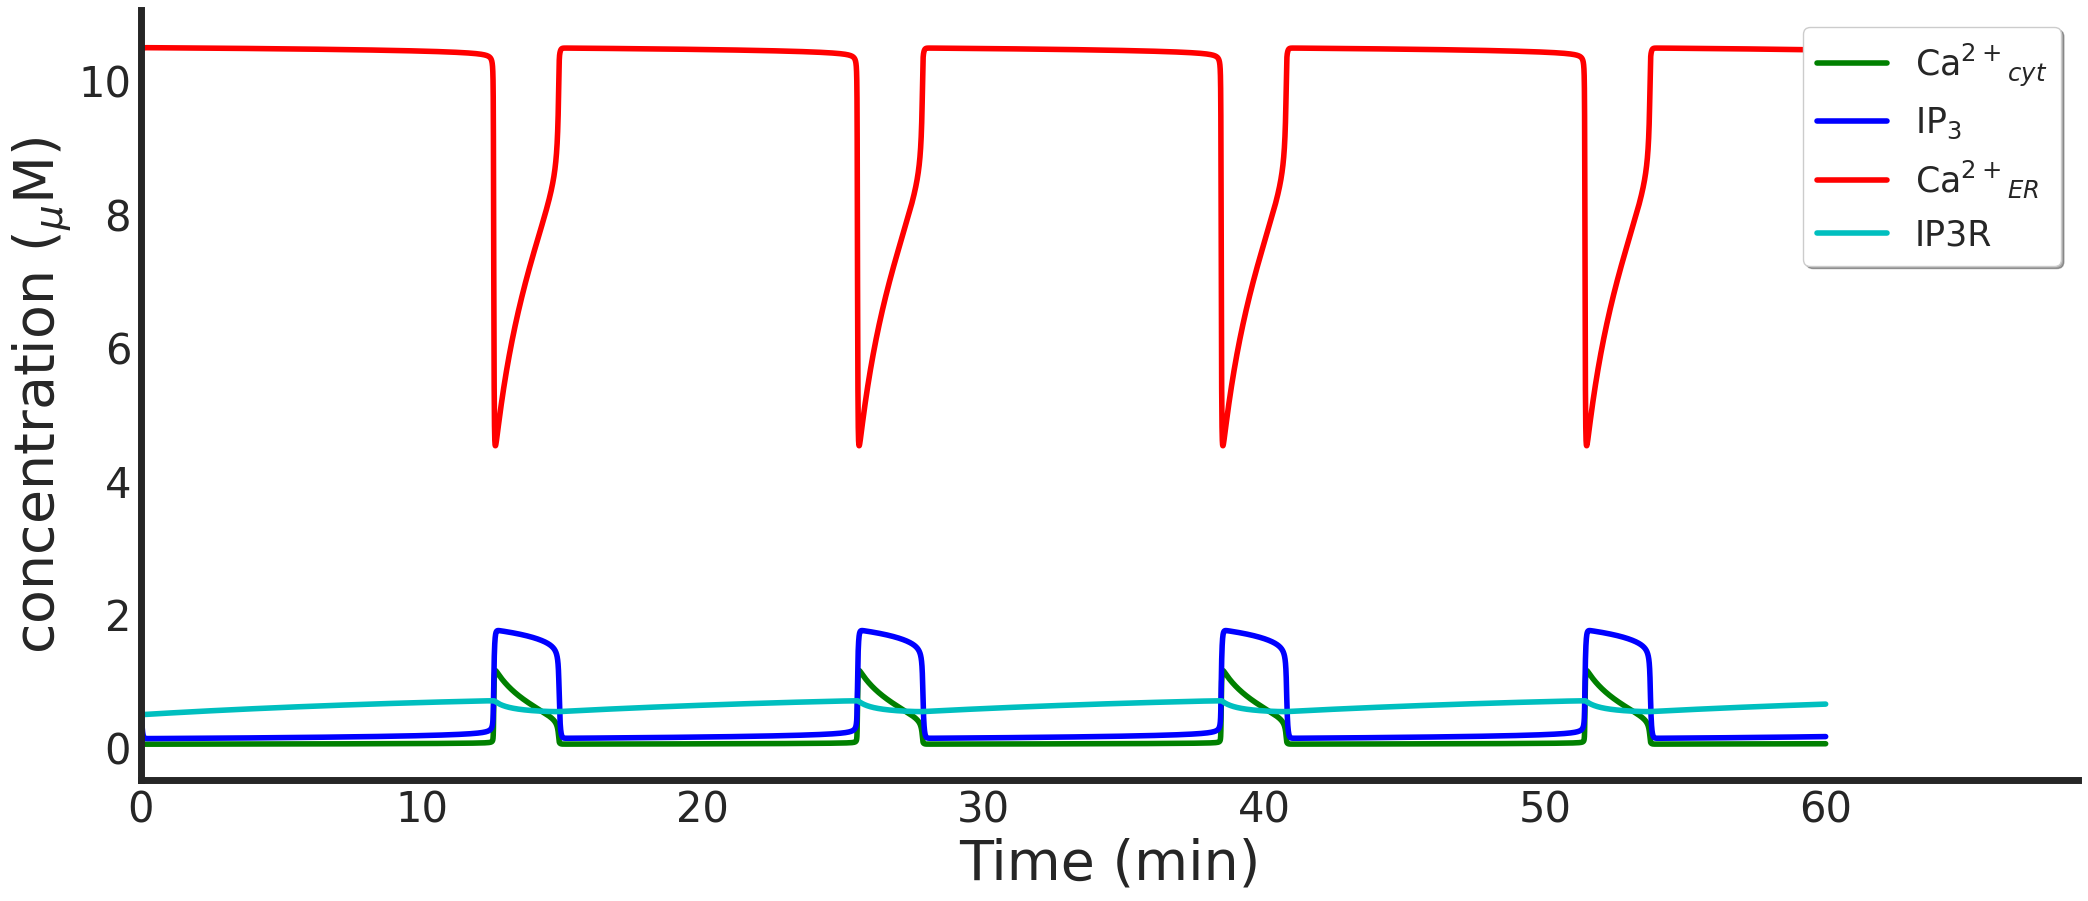

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

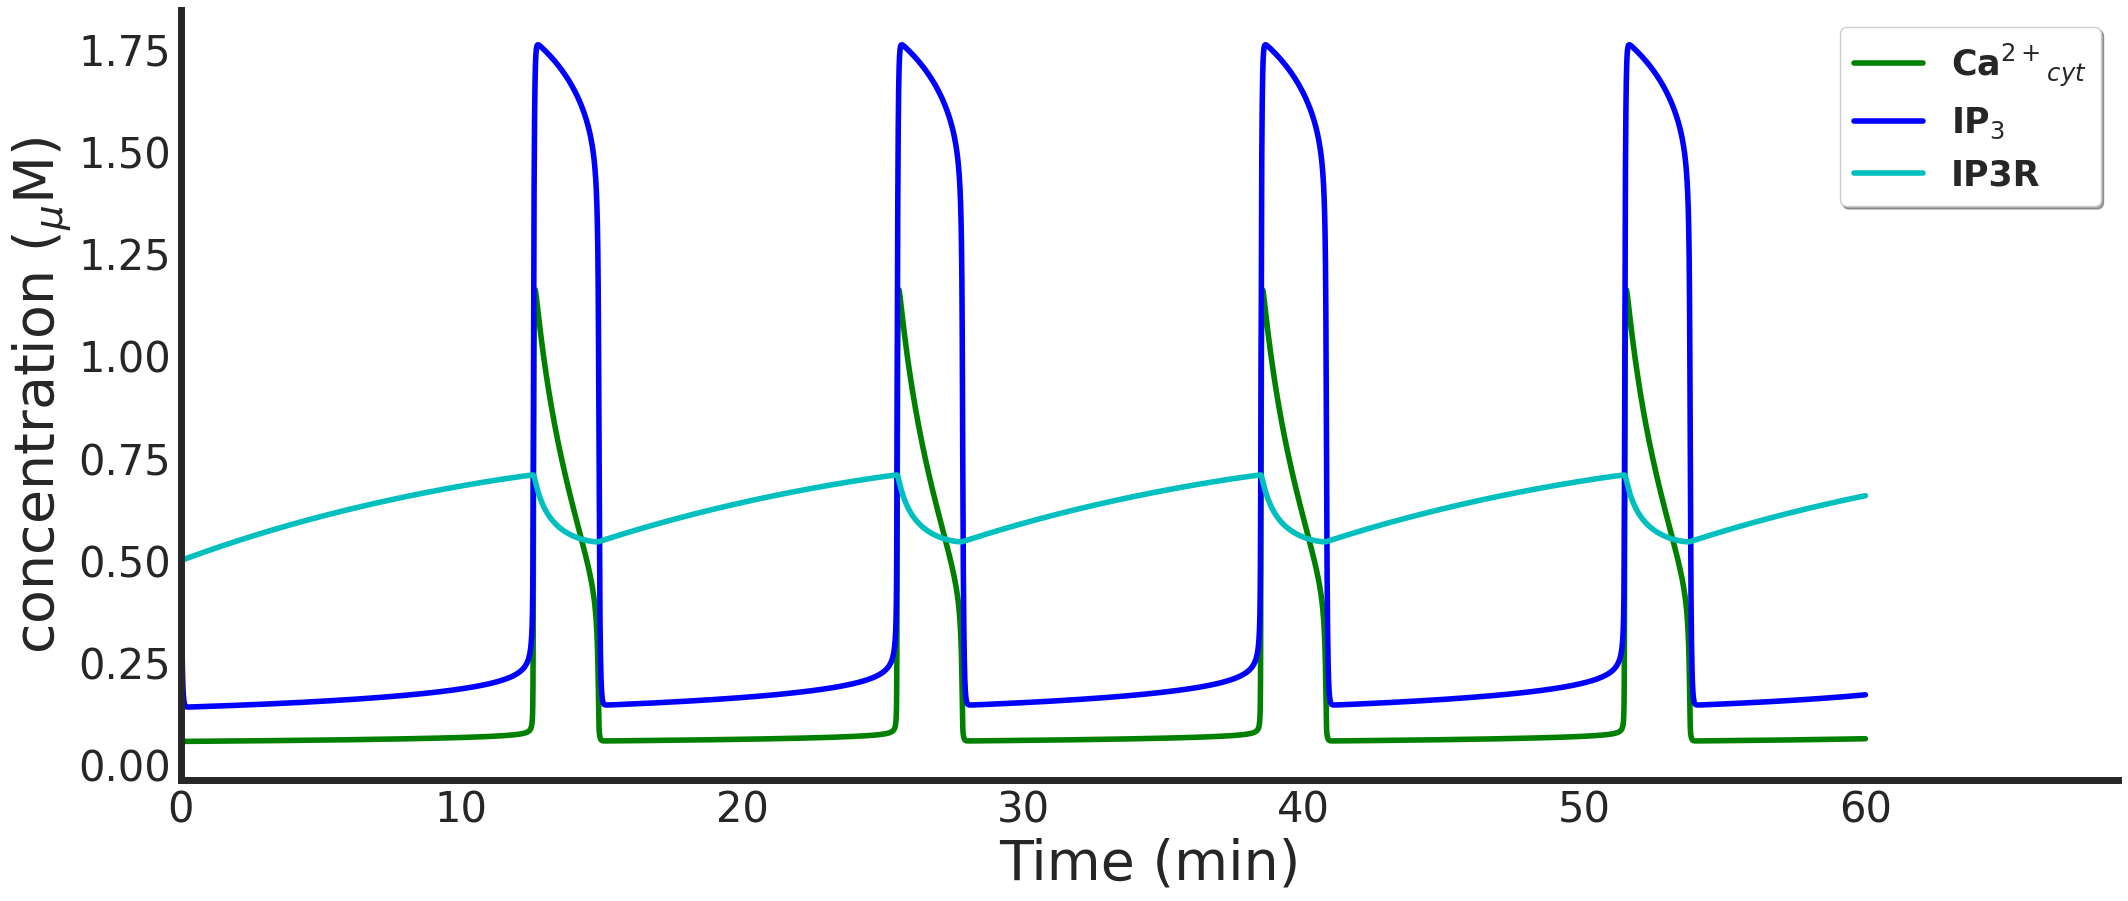

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

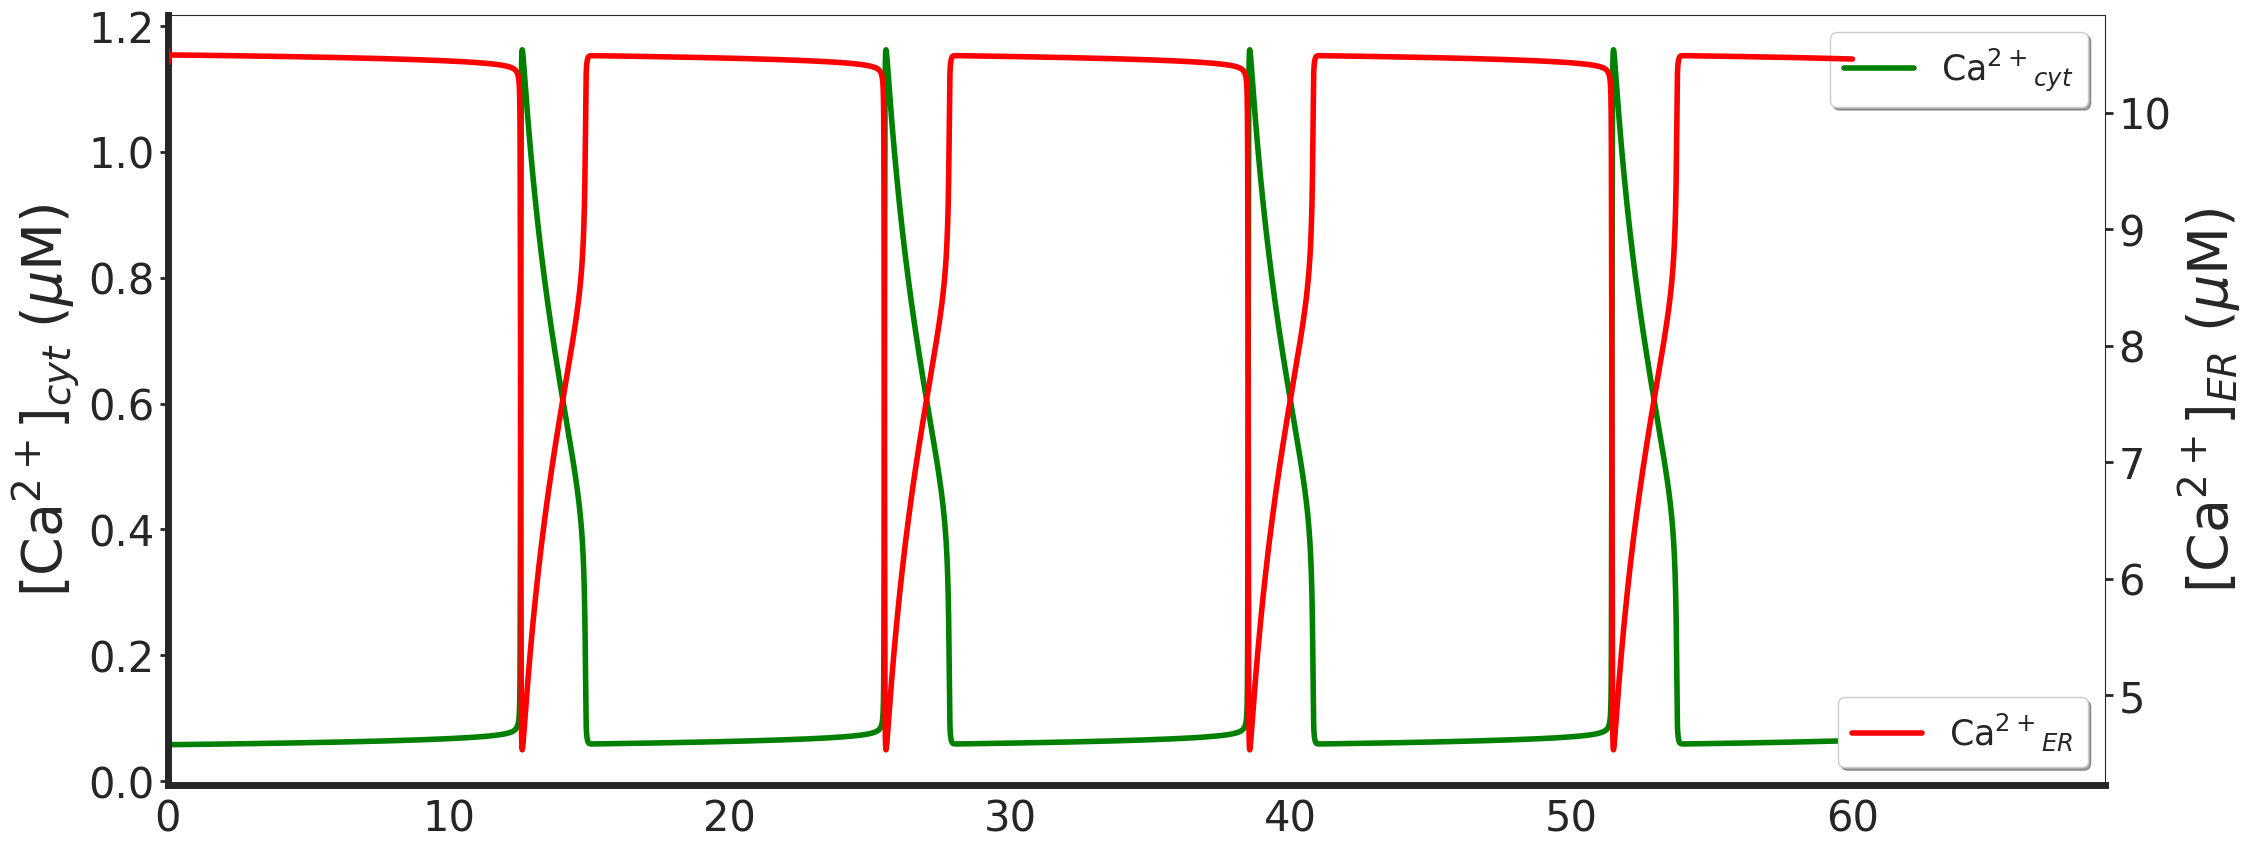

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax1 = ax.twinx()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    ax.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax1.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax1.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax.tick_params(axis='x', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='x', which='minor', labelsize=30, length=4, width=1)


    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)


    ax.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    ax1.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$]$_{cyt}$ ($\mu$M)',fontsize=40)
    ax1.set_ylabel(r'[Ca$^{2+}$]$_{ER}$ ($\mu$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax1.legend(loc=4, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

#K_Tau = 1.2

Same equations as used in the previous block, only changing the value of K_Tau. Refer to first block for detailed comments of the equations.

In [ ]:

def Ca_cyt_dot(Ca_cyt, IP3, IP3R,C_ER):
  k1 = 1.11
  k2 = 0.0203
  Ka = 0.08
  Kp = 0.13
  k3= 0.4
  k3z = 0.0
  k5 = 0.66

  Kserca = 0.1
  Vserca = 0.9
  # no need to solve Calcium in reticulum with an ODE because total Calcium is constant so
  Ctot = 2.0
  beta = 0.185
  #Ca_R = (Ctot-Ca_cyt)/beta we don't need this anymore since we have the actual calcium in reticulum ode
  eps = 0.0
  v0 = 0.0008
  vpm = 0.0
  kpm = 0.01
  phi = 0.0
  vplc = 1.6
  return (k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt) - Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)+eps*(v0+(phi*vplc)/((k3z+k5))-(vpm*Ca_cyt**2/(kpm**2+Ca_cyt**2))) #added in the calcium in the reticulum

def IP3R_dot(Ca_cyt, IP3, IP3R):
  tau_max = 1000 #add tau_new_max and rewrite
  k_tau = 1.2 #is like vplc and has range from 0.5 to 1.2 but we can only change one (either vplc or ktau)
  tau_new_update = tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4)
  ki = 0.4
  return (1.0/tau_new_update)*(1-IP3R*(ki+Ca_cyt)/ki)

def IP3_dot(Ca_cyt, IP3, IP3R):
  k5 = 0.66 # parameter
  k3 = 0.4
  k3z= 0.0
  VPLC = 1.6 # paramter (is from .1-1.5 micromoles)
  K_PLC = 0.2 # parameter
  tau_p = 1
  vplc = (VPLC*Ca_cyt**2/(K_PLC**2+Ca_cyt**2))
  vdeg = (k5+(k3z*Ca_cyt**2/(k3**2+Ca_cyt**2)))*IP3
  return tau_p * (vplc - vdeg)
def C_ER_dot(Ca_cyt, IP3, IP3R, C_ER):
  beta = 0.185
  Kserca = 0.1
  Vserca = 0.9
  k1 = 1.11
  Ka = 0.08
  Kp = 0.13
  k2 = 0.0203
  Ctot = 2.0
  Ca_R = (Ctot-Ca_cyt)/beta
  return (1.0/beta)*((((Vserca*Ca_cyt**2/(Kserca**2+Ca_cyt**2)))-(k1*((IP3R*Ca_cyt/(Ka+Ca_cyt))*(IP3/(Kp+IP3)))**3+k2)*(C_ER - Ca_cyt)))




In [ ]:
dt = 0.01 #s
t_final = 3600 # s
n_steps = int(t_final/dt)
# create arrays to store solution
Ca_cyt_vec = np.zeros((n_steps))
IP3_vec = np.zeros((n_steps))
C_ER_vec = np.zeros((n_steps))
IP3R_vec = np.zeros((n_steps))
time_vec = np.zeros((n_steps))
# Initial conditions
Ca_cyt_vec[0] = .06
IP3_vec[0] = 1
C_ER_vec[0] = (2.0 - .05)/0.185
IP3R_vec[0] = 0.5

for i in range(n_steps-1):
  Ca_cyt_vec[i+1] = Ca_cyt_vec[i]+dt*Ca_cyt_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3_vec[i+1] = IP3_vec[i]+dt*IP3_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  C_ER_vec[i+1] = C_ER_vec[i]+dt*C_ER_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i],C_ER_vec[i])
  IP3R_vec[i+1] = IP3R_vec[i]+dt*IP3R_dot(Ca_cyt_vec[i], IP3_vec[i], IP3R_vec[i])
  time_vec[i+1] = time_vec[i]+dt

Plots with K_Tau value of 1.2

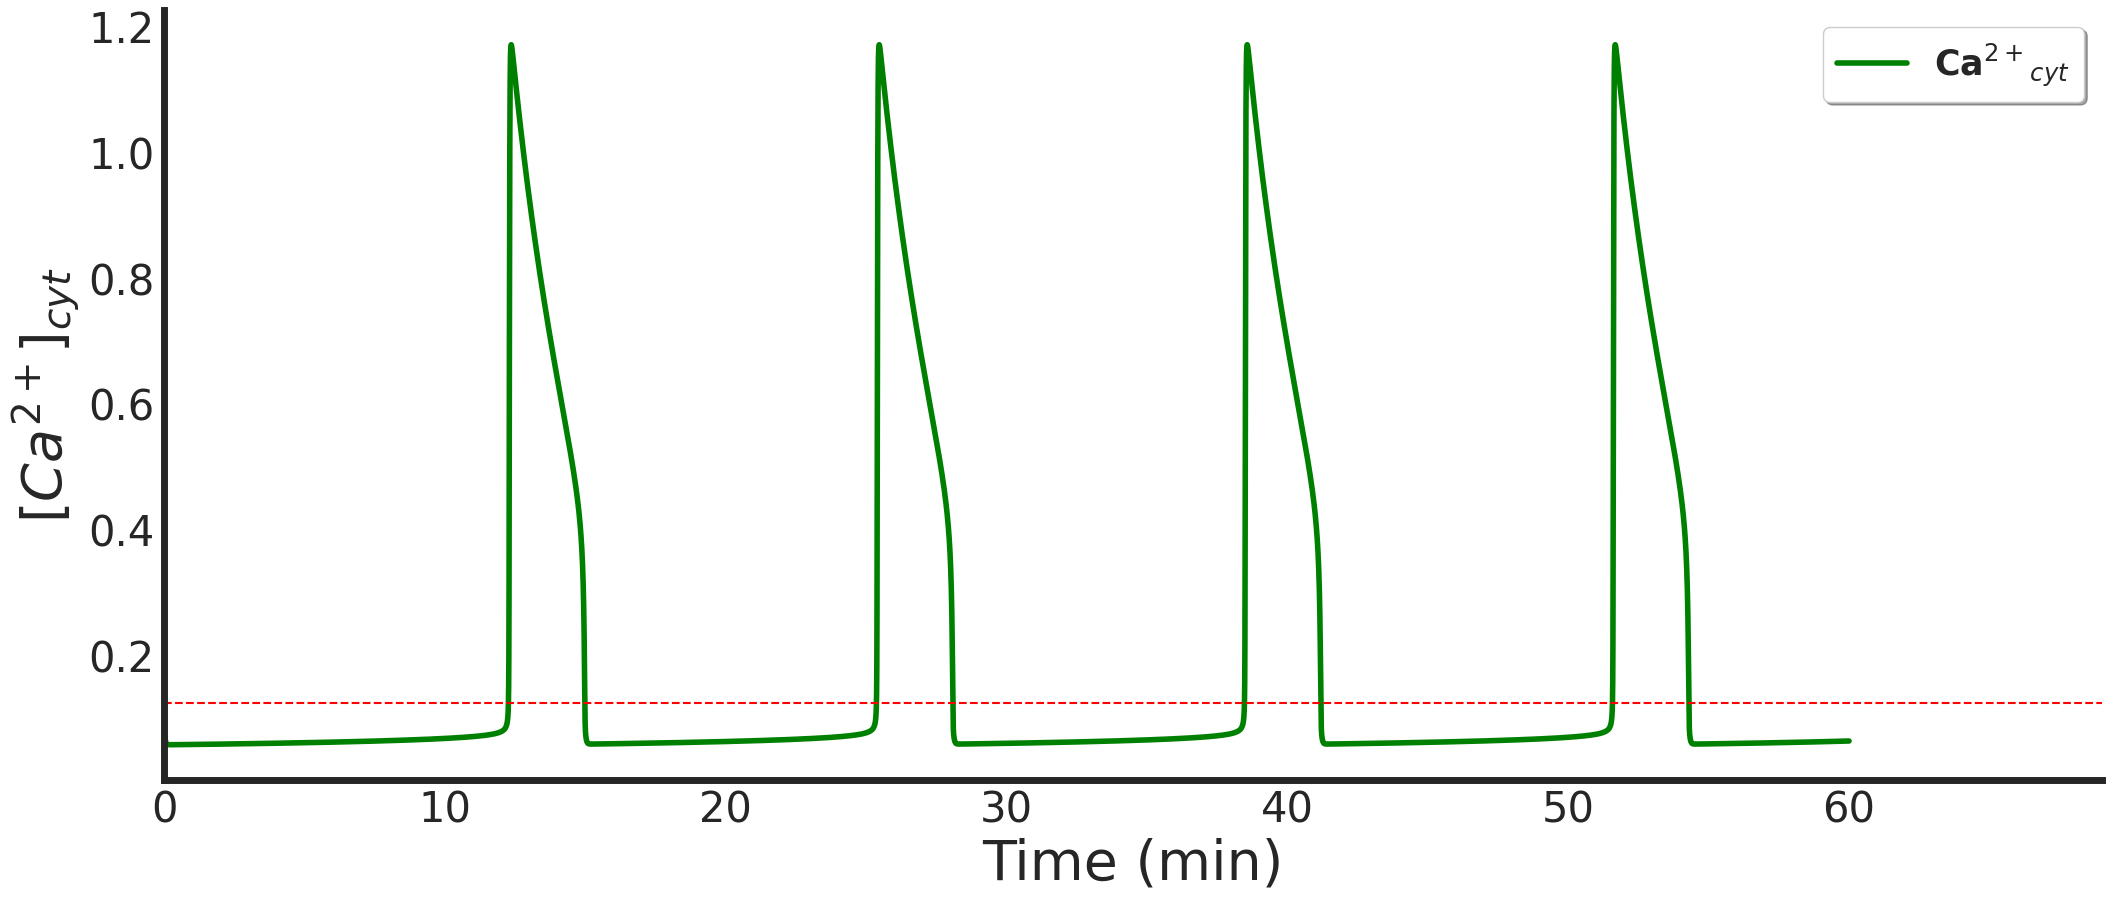

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.axhline(y=0.125, color='r', linestyle='--')

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[$Ca^{2+}$]$_{cyt}$',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

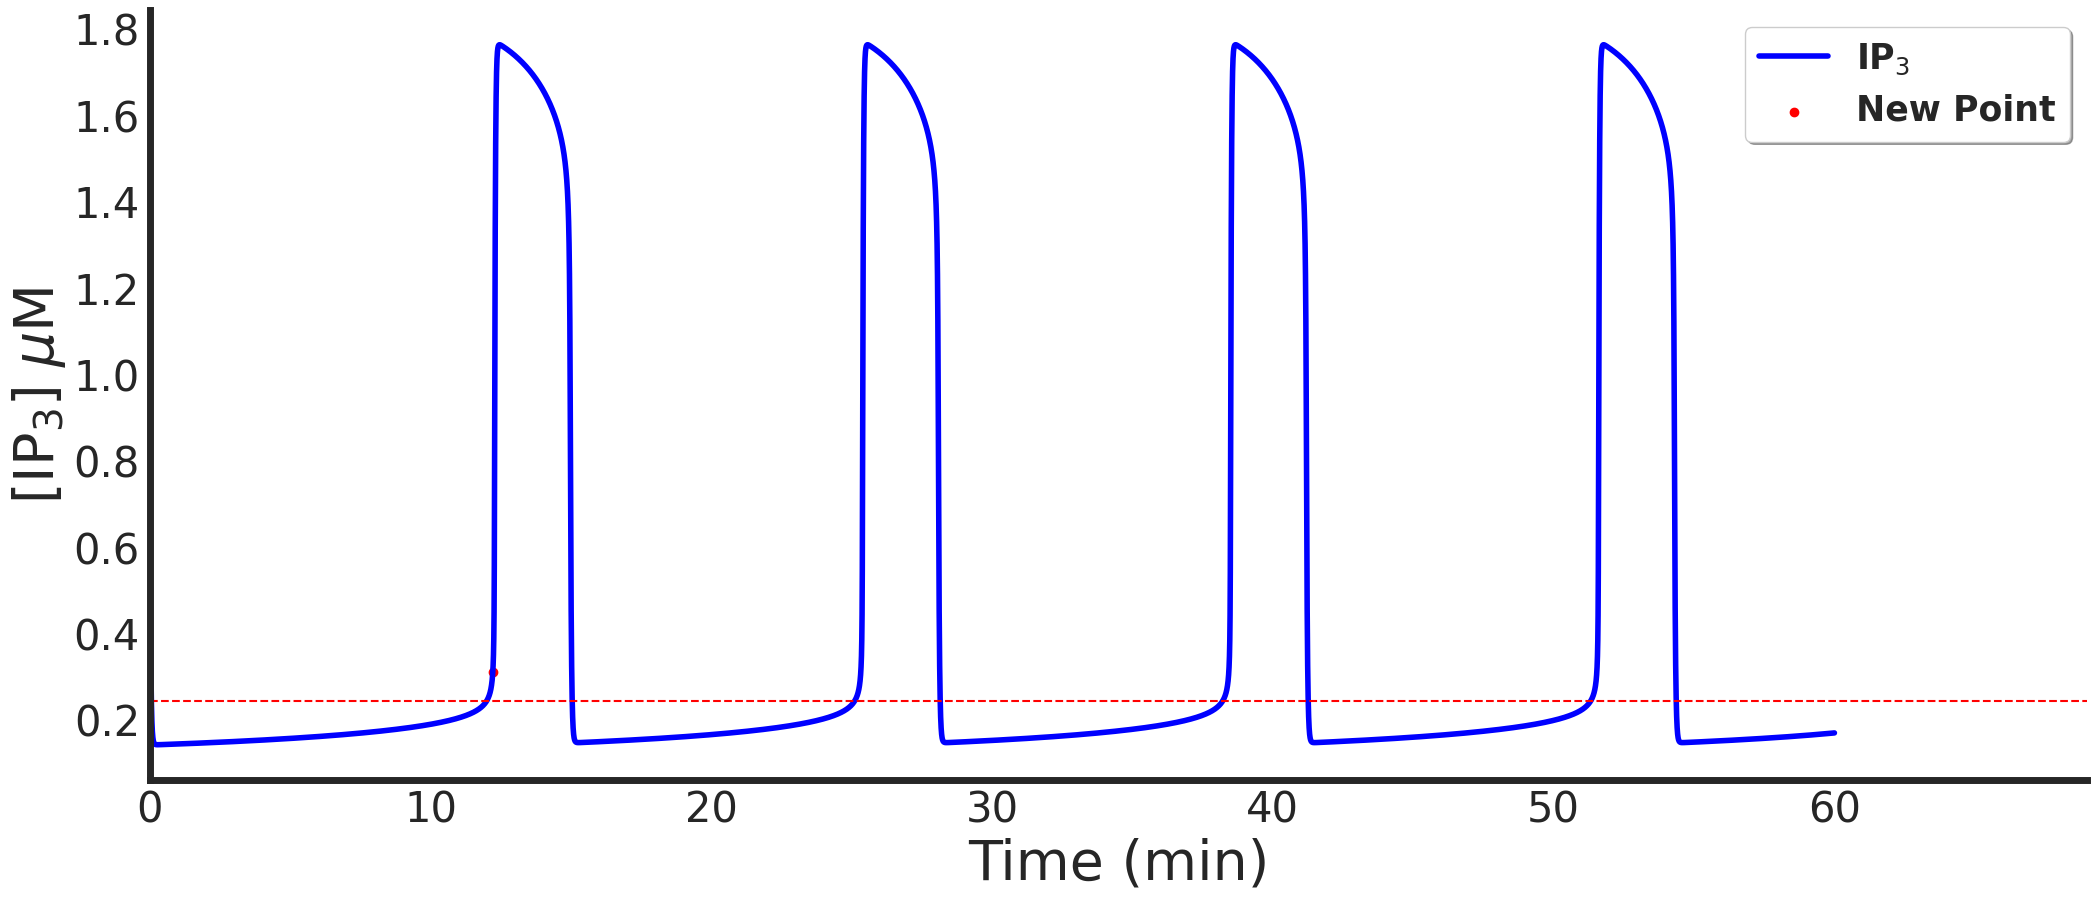

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )

    plt.axhline(y=0.245, color='r', linestyle='--')
    #new_x=(733.2)/60
    #new_y=0.31188969936412686
    #plt.scatter(new_x, new_y, color='red', label='New Point')

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

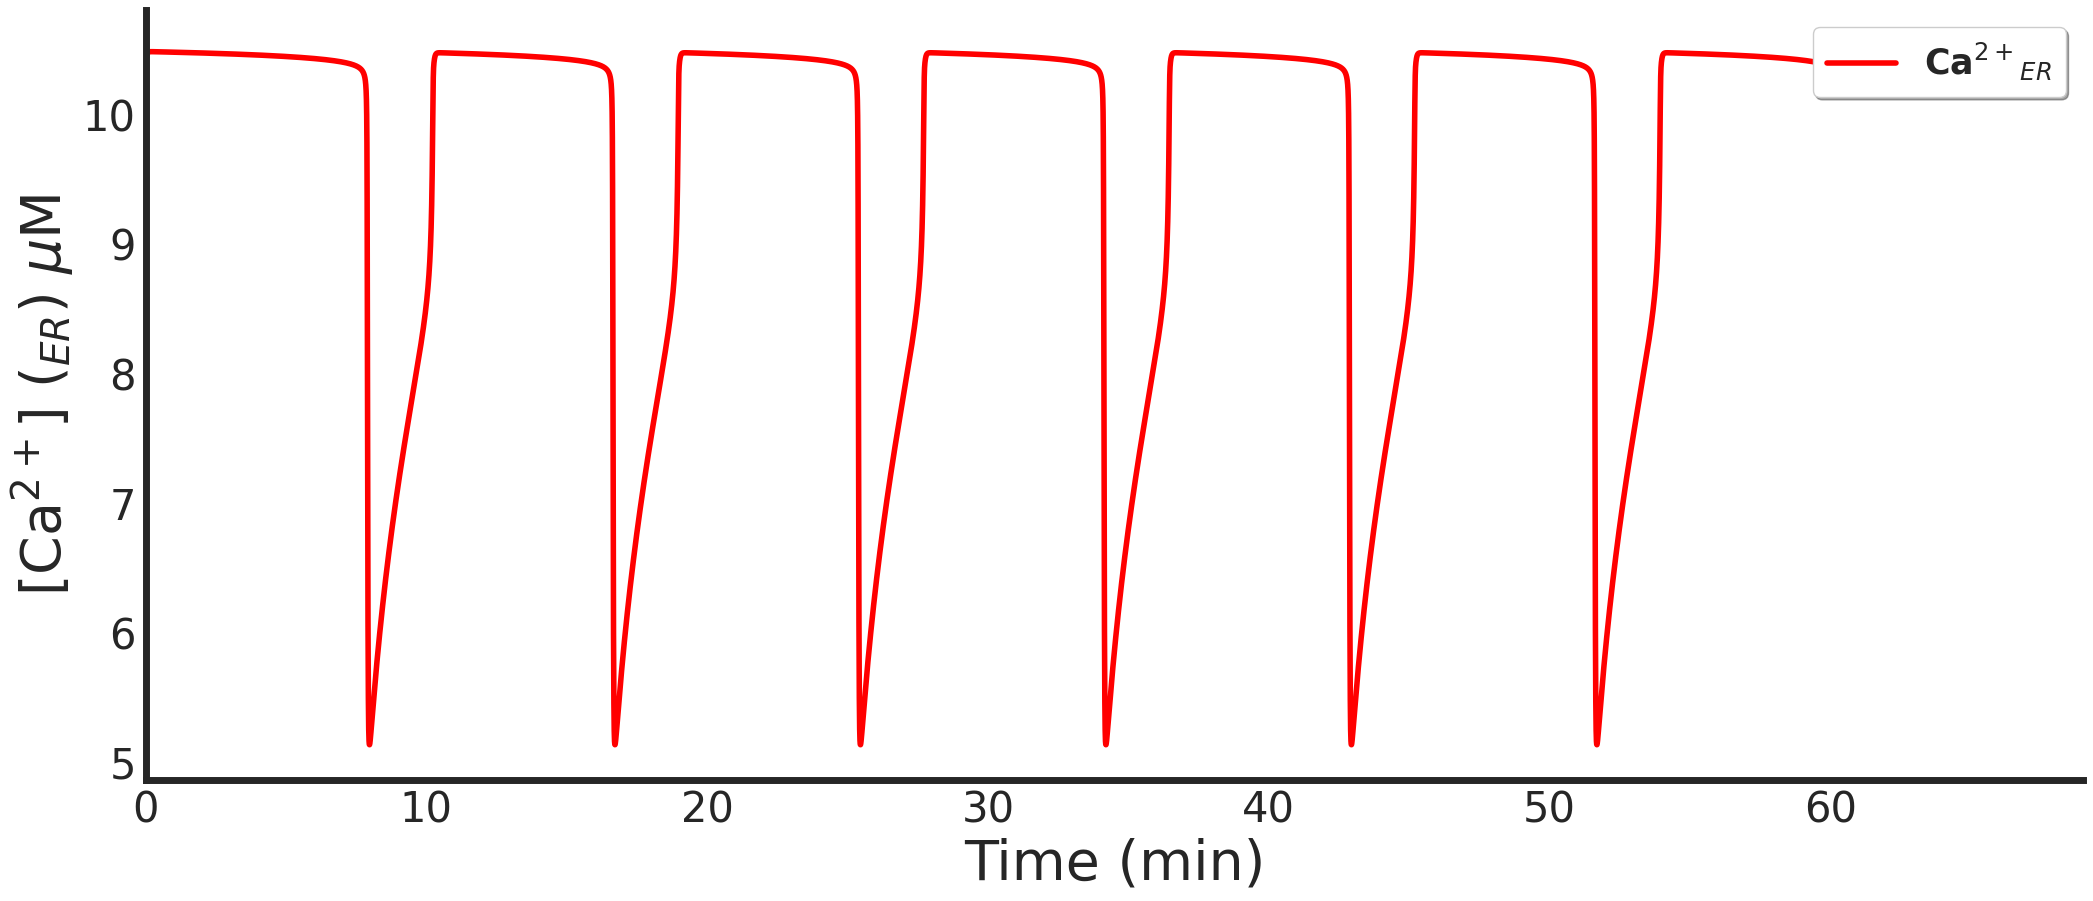

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$] ($_{ER}$) $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

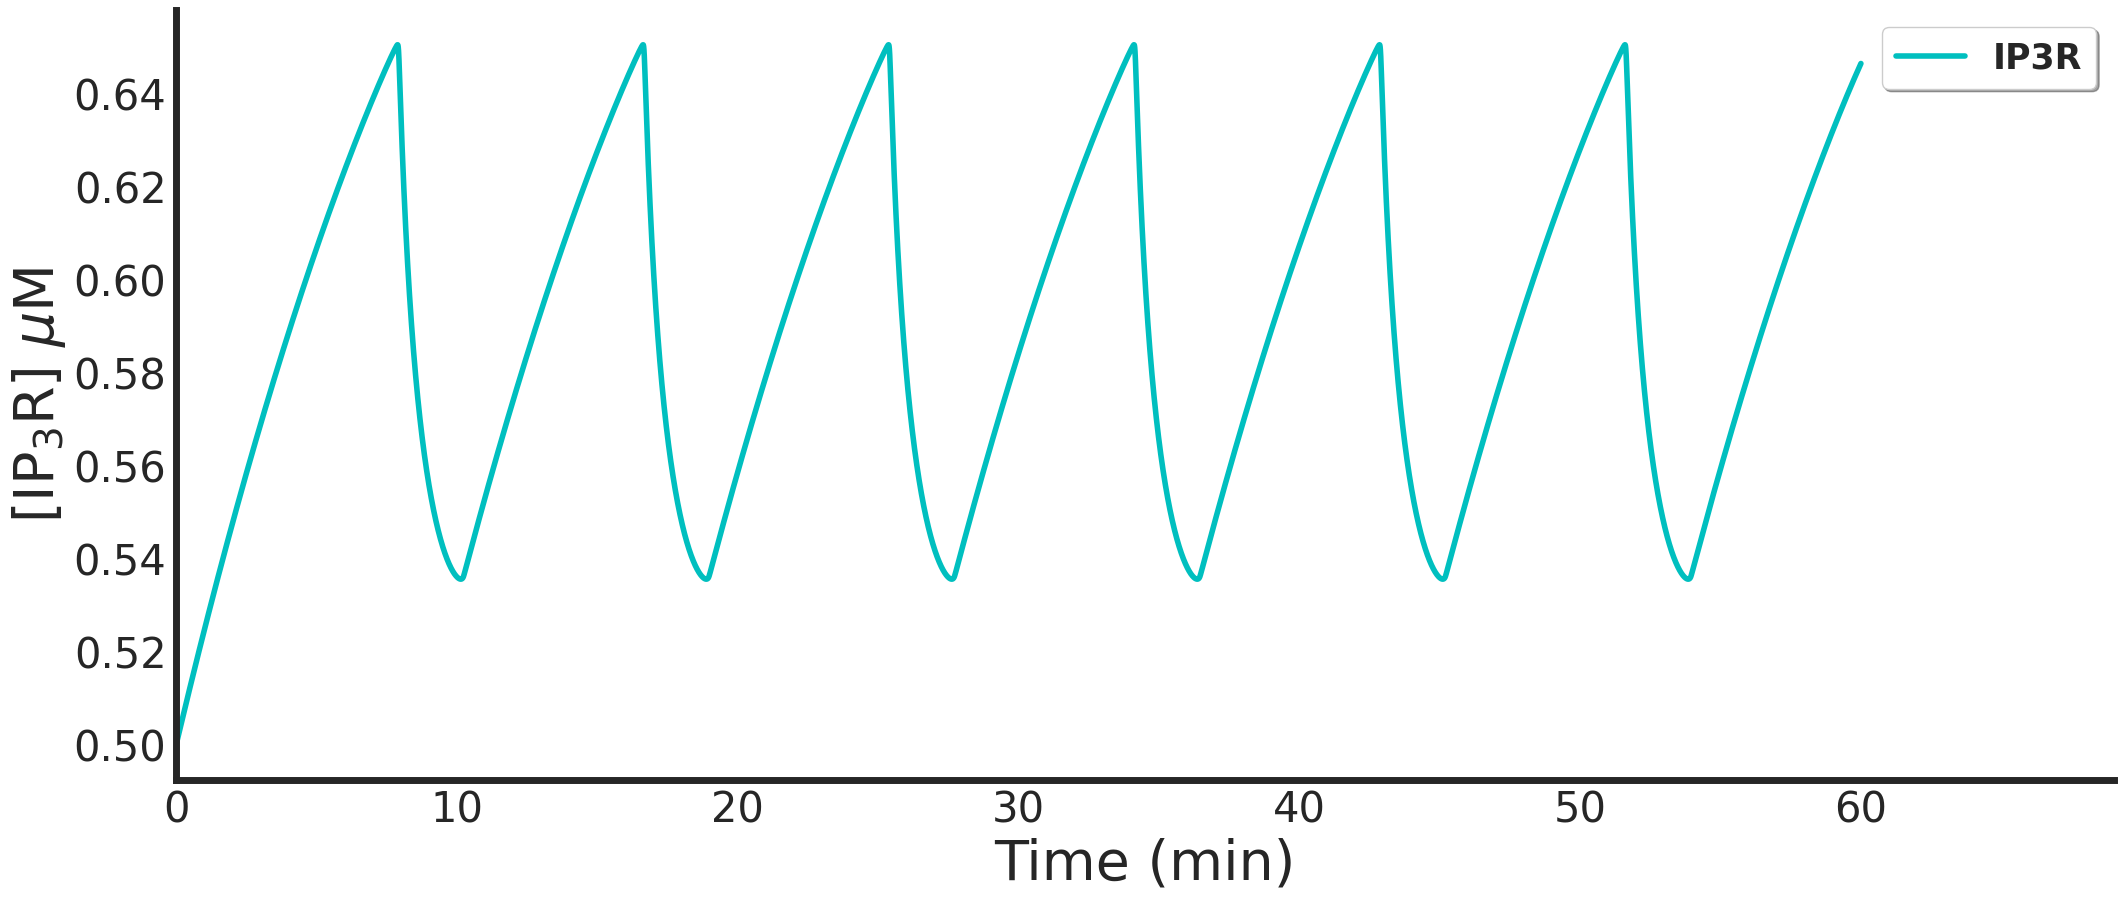

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[IP$_{3}$R] $\mu$M',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

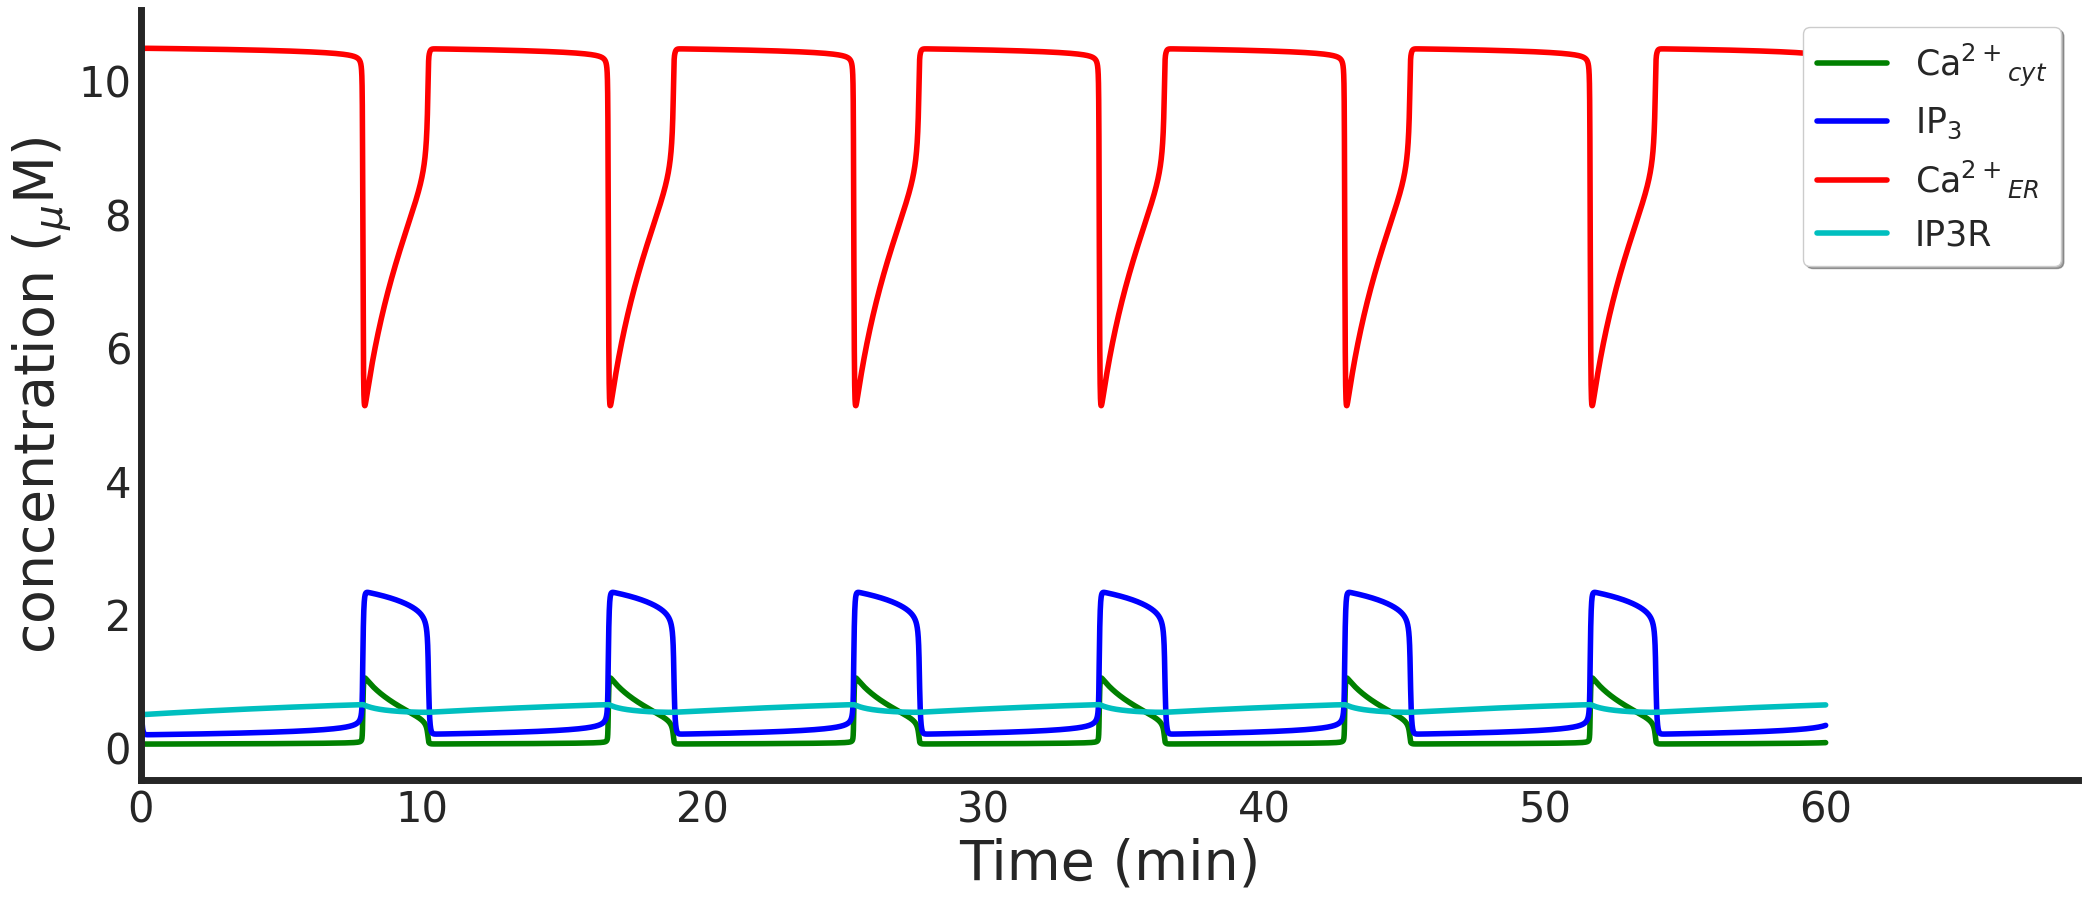

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

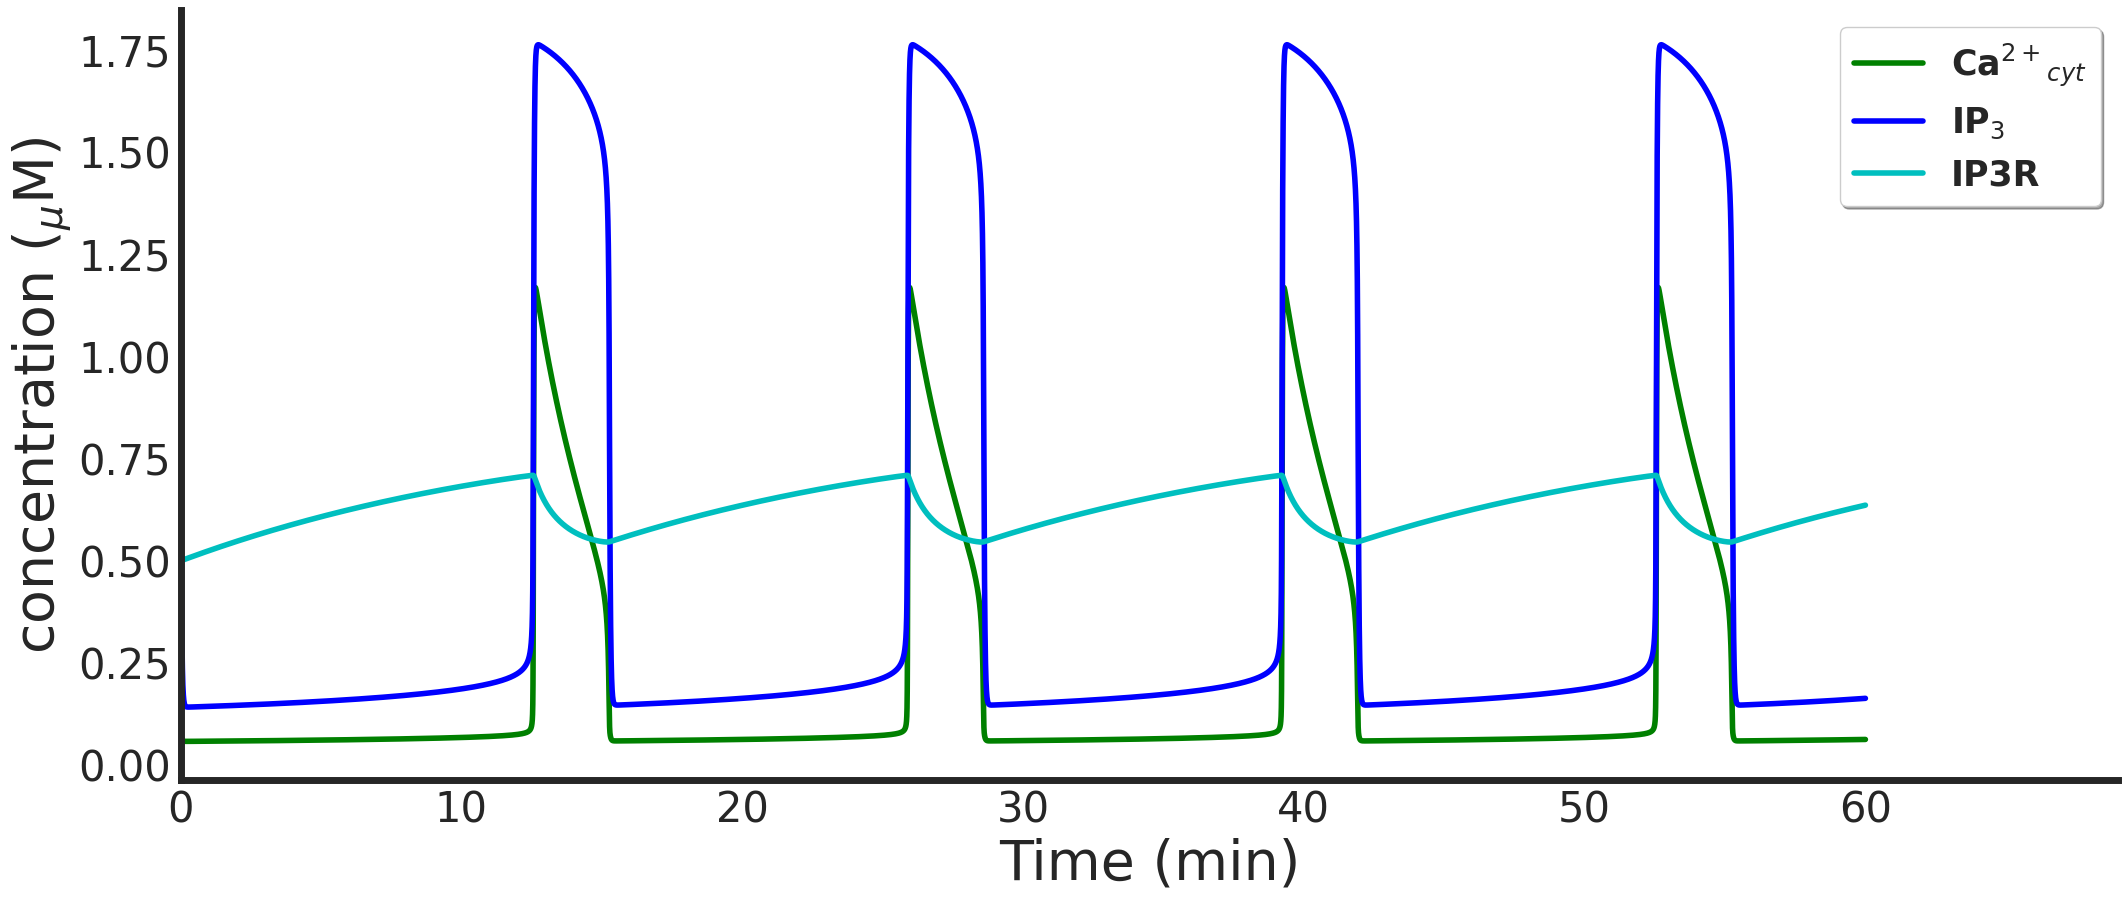

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'weight':'bold','size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    plt.plot(time_vec/60,IP3_vec,'b',linewidth=4,label=r'IP$_{3}$' )
    plt.plot(time_vec/60,IP3R_vec,'c',linewidth=4,label=r'IP3R' )

    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'concentration ($_{\mu}$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

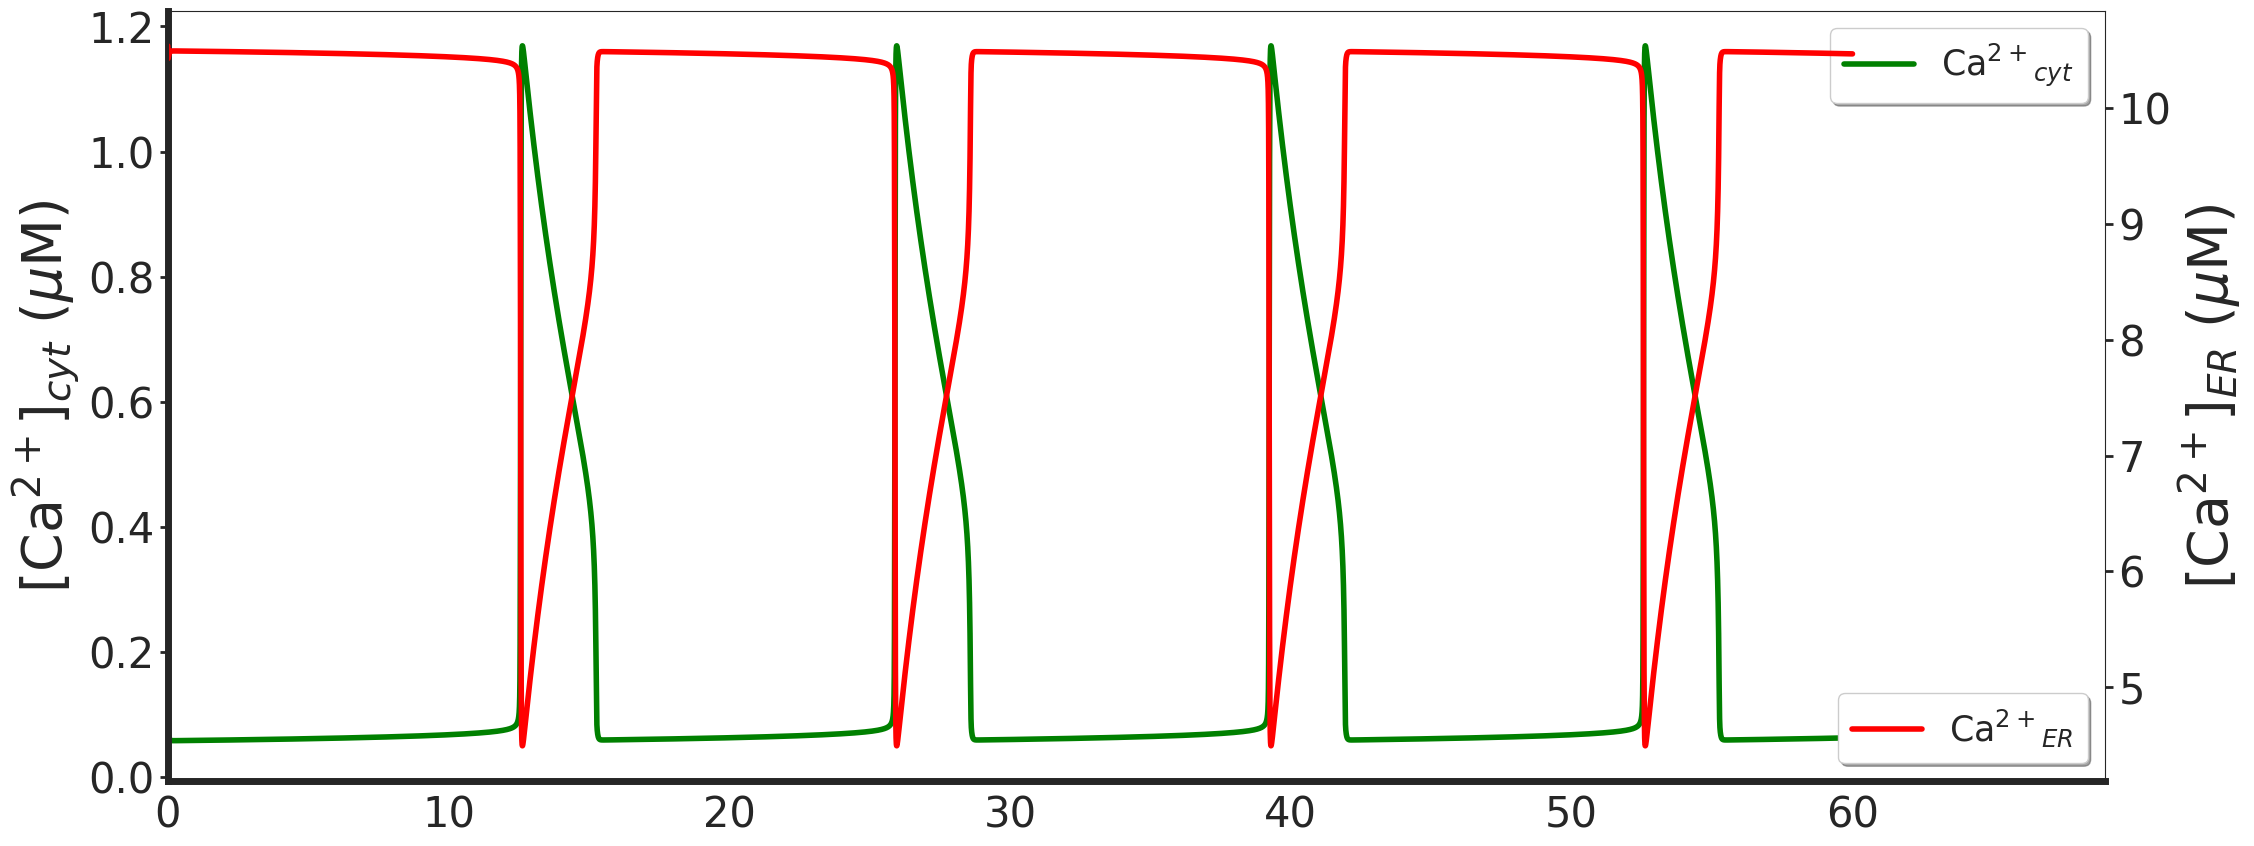

In [ ]:
with sns.axes_style("white"):
    legend_properties = {'size':25}
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax1 = ax.twinx()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    ax.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax1.tick_params(axis='y', which='major', labelsize=30, length=6, width=2)
    ax1.tick_params(axis='y', which='minor', labelsize=30, length=4, width=1)

    ax.tick_params(axis='x', which='major', labelsize=30, length=6, width=2)
    ax.tick_params(axis='x', which='minor', labelsize=30, length=4, width=1)


    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)


    ax.plot(time_vec/60,Ca_cyt_vec,'g',linewidth=4,label=r'Ca$^{2+}$$_{cyt}$' )
    ax1.plot(time_vec/60,C_ER_vec,'r',linewidth=4,label=r'Ca$^{2+}$$_{ER}$' )


    plt.xlabel('Time (min)',fontsize=40)
    ax.set_ylabel(r'[Ca$^{2+}$]$_{cyt}$ ($\mu$M)',fontsize=40)
    ax1.set_ylabel(r'[Ca$^{2+}$]$_{ER}$ ($\mu$M)',fontsize=40)
    ax.legend(loc=1, shadow=True, prop=legend_properties)
    ax1.legend(loc=4, shadow=True, prop=legend_properties)
    ax.set_xlim([0,69])

In [ ]:
def tau_func(Ca_cyt):
  tau_max = 1000 #add tau_new_max and rewrite
  k_tau = 1.2 #is like vplc and has range from 0.5 to 1.2 but we can only change one (either vplc or ktau)
  return  tau_max * (k_tau**4)/(Ca_cyt**4 + k_tau**4)

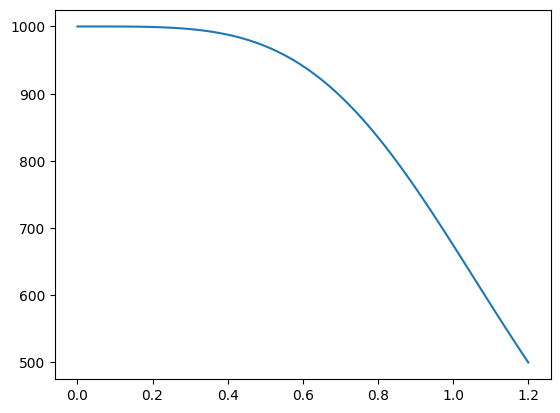

In [ ]:
ca_cyt_vecc = np.linspace(0,1.2,100)
plt.plot(ca_cyt_vecc,tau_func(ca_cyt_vecc))

Equations written in Linux

$\tau_{\text{r}} = \tau_{\text{max}} \cdot \left(\frac{{k_{\tau}^4}}{{\text{c}^4 + k_{\tau}^4}}\right)$



$J_{\text{c}} = F{_\text{c}} \cdot \left({{k_{\tau}^4}}{{\text{c}^4 + k_{\tau}^4}}\right)$



$J_{\text{c}} = F{_\text{c}} \cdot \left({{c_{1}}}{{\text{l_{1}}^4 + k_{\tau}^4}}\right)$



List of values for each ODE

In [ ]:
Ca_cyt_vec
numbers = Ca_cyt_vec

In [ ]:
IP3_vec
numbers = IP3_vec

In [ ]:
C_ER_vec
numbers = C_ER_vec

In [ ]:
IP3R_vec
numbers = IP3R_vec

In [ ]:
def find_most_common(numbers):
    unique_numbers, counts = np.unique(numbers, return_counts=True)

    # Find the most common number(s)
    max_count = np.max(counts)
    most_common_numbers = unique_numbers[counts == max_count]

    # Find the smallest number among the most common numbers
    smallest_most_common = np.min(most_common_numbers)

    # Find the index of the smallest most common number
    most_common_index = np.where(numbers == smallest_most_common)[0][0]

    return smallest_most_common, most_common_index, max_count

most_common_number, most_common_index, repetition_count = find_most_common(numbers)
print("The most common number is:", most_common_number)
print("It repeated", repetition_count, "times")
print("Its index is:", most_common_index)


The most common number is: 0.14325315315622586
It repeated 1 times
Its index is: 1664


In [ ]:
def find_smallest_number(numbers, start_index, end_index):
    if start_index < 0 or end_index >= len(numbers) or start_index > end_index:
        return None, -1

    smallest_number = float('inf')
    smallest_index = -1

    for i in range(start_index, end_index + 1):
        if numbers[i] < smallest_number:
            smallest_number = numbers[i]
            smallest_index = i

    return smallest_number, smallest_index

# Example usage
start_index = 0
end_index = 359999
smallest, index = find_smallest_number(numbers, start_index, end_index)

if smallest is not None:
    print(f"The smallest number within the range [{start_index}, {end_index}] is: {smallest}")
    print(f"Its index within the range is: {index}")
else:
    print("Invalid range specified")


The smallest number within the range [0, 359999] is: 0.5
Its index within the range is: 0


In [ ]:
def find_rapid_increase(numbers, start_index, end_index):
    max_difference = float('-inf')
    rapid_increase_index = -1

    for i in range(start_index + 1, end_index + 1):
        difference = numbers[i] - numbers[i-1]
        if difference > max_difference:
            max_difference = difference
            rapid_increase_index = i

    return rapid_increase_index, max_difference

# Example usage
start_index = 72277
end_index = 73158
rapid_increase_index, threshold = find_rapid_increase(numbers, start_index, end_index)

if rapid_increase_index != -1:
    print(f"The numbers start rapidly increasing at index {rapid_increase_index}")
    print(f"The threshold value for rapid increase is {threshold}")
else:
    print("Rapid increase not found in the specified range")


The numbers start rapidly increasing at index 73158
The threshold value for rapid increase is 2.573211549533605e-06


In [ ]:
def find_highest_number(numbers, start_index, end_index):
    if start_index < 0 or end_index >= len(numbers) or start_index > end_index:
        return None, -1

    highest_number = float('-inf')
    highest_index = -1

    for i in range(start_index, end_index + 1):
        if numbers[i] > highest_number:
            highest_number = numbers[i]
            highest_index = i

    return highest_number, highest_index

# Example usage

start_index = 0
end_index = 359999
highest, index = find_highest_number(numbers, start_index, end_index)

if highest is not None:
    print(f"The highest number within the range [{start_index}, {end_index}] is: {highest}")
    print(f"Its index within the range is: {index}")
else:
    print("Invalid range specified")


The highest number within the range [0, 359999] is: 10.54054054054054
Its index within the range is: 0


In [ ]:
numbers[30000]

0.06132538595629092

In [ ]:
def count_threshold_exceedances(numbers, threshold, start_index=None, end_index=None):
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(numbers) - 1

    count = 0
    exceedance_indexes = []

    for i in range(start_index, end_index + 1):
        if numbers[i] > threshold:
            count += 1
            exceedance_indexes.append(i)

    return count, exceedance_indexes

# Example usage

threshold = 0.69
start_index = 0
end_index = 359999

exceedance_count, exceedance_indexes = count_threshold_exceedances(numbers, threshold, start_index, end_index)

print("Threshold Exceedances:")
print(f"Count: {exceedance_count}")
print(f"Indexes: {exceedance_indexes}")


Threshold Exceedances:
Count: 37667
Indexes: [47460, 47461, 47462, 47463, 47464, 47465, 47466, 47467, 47468, 47469, 47470, 47471, 47472, 47473, 47474, 47475, 47476, 47477, 47478, 47479, 47480, 47481, 47482, 47483, 47484, 47485, 47486, 47487, 47488, 47489, 47490, 47491, 47492, 47493, 47494, 47495, 47496, 47497, 47498, 47499, 47500, 47501, 47502, 47503, 47504, 47505, 47506, 47507, 47508, 47509, 47510, 47511, 47512, 47513, 47514, 47515, 47516, 47517, 47518, 47519, 47520, 47521, 47522, 47523, 47524, 47525, 47526, 47527, 47528, 47529, 47530, 47531, 47532, 47533, 47534, 47535, 47536, 47537, 47538, 47539, 47540, 47541, 47542, 47543, 47544, 47545, 47546, 47547, 47548, 47549, 47550, 47551, 47552, 47553, 47554, 47555, 47556, 47557, 47558, 47559, 47560, 47561, 47562, 47563, 47564, 47565, 47566, 47567, 47568, 47569, 47570, 47571, 47572, 47573, 47574, 47575, 47576, 47577, 47578, 47579, 47580, 47581, 47582, 47583, 47584, 47585, 47586, 47587, 47588, 47589, 47590, 47591, 47592, 47593, 47594, 47595, 47

In [ ]:
numbers[75183]

0.12495034959142037

In [ ]:
def count_threshold_exceedances(numbers, threshold2, start_index2=None, end_index2=None):
    if start_index2 is None:
        start_index2 = 0
    if end_index2 is None:
        end_index2 = len(numbers) - 1

    count = 0
    exceedance_indexes2 = []

    for i in range(start_index2, end_index2 + 1):
        if numbers[i] > threshold2:
            count += 1
            exceedance_indexes2.append(i)

    return count, exceedance_indexes2

# Example usage

threshold2 = 1.5
start_index2 = 0
end_index2 = 359999

exceedance_count2, exceedance_indexes2 = count_threshold_exceedances(numbers, threshold2, start_index2, end_index2)

print("Threshold Exceedances:")
print(f"Count: {exceedance_count2}")
print(f"Indexes: {exceedance_indexes2}")


Threshold Exceedances:
Count: 83098
Indexes: [47457, 47458, 47459, 47460, 47461, 47462, 47463, 47464, 47465, 47466, 47467, 47468, 47469, 47470, 47471, 47472, 47473, 47474, 47475, 47476, 47477, 47478, 47479, 47480, 47481, 47482, 47483, 47484, 47485, 47486, 47487, 47488, 47489, 47490, 47491, 47492, 47493, 47494, 47495, 47496, 47497, 47498, 47499, 47500, 47501, 47502, 47503, 47504, 47505, 47506, 47507, 47508, 47509, 47510, 47511, 47512, 47513, 47514, 47515, 47516, 47517, 47518, 47519, 47520, 47521, 47522, 47523, 47524, 47525, 47526, 47527, 47528, 47529, 47530, 47531, 47532, 47533, 47534, 47535, 47536, 47537, 47538, 47539, 47540, 47541, 47542, 47543, 47544, 47545, 47546, 47547, 47548, 47549, 47550, 47551, 47552, 47553, 47554, 47555, 47556, 47557, 47558, 47559, 47560, 47561, 47562, 47563, 47564, 47565, 47566, 47567, 47568, 47569, 47570, 47571, 47572, 47573, 47574, 47575, 47576, 47577, 47578, 47579, 47580, 47581, 47582, 47583, 47584, 47585, 47586, 47587, 47588, 47589, 47590, 47591, 47592, 47

In [ ]:
if exceedance_indexes==exceedance_indexes2:
  print('Yes')




In [ ]:
all = 60000
print(IP3_vec[all])
print(Ca_cyt_vec[all])
print(C_ER_vec[all])
print(IP3R_vec[all])

1.9907791984643075
0.420135495082956
8.5398081346868
0.5360743065689573
